In [1]:
import pandas as pd
from pandas import read_csv
from matplotlib import pyplot as plt
from pandas.plotting import lag_plot
import statsmodels.api as sm

In [2]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Importing Data

In [3]:
names=["Date","Value"]
series = read_csv('INR-vs-USD.csv',index_col=0,names=names,header=0)
series.index = pd.to_datetime(series.index)
resampled_series = series['Value'].resample('D').ffill()

<AxesSubplot:xlabel='Date'>

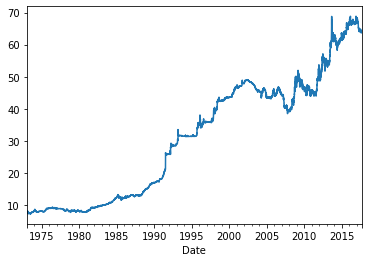

In [4]:
resampled_series.plot()

In [5]:
train_size=int(len(resampled_series)*50/100)
print(train_size)
test_size=len(resampled_series)-train_size
print(test_size)

8153
8154


In [6]:
train_data=resampled_series[:train_size]
test_data=resampled_series[train_size:]

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

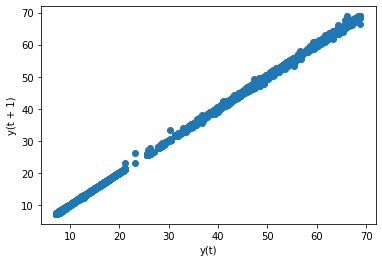

In [7]:
lag_plot(resampled_series)

### Dickey Fuller Test

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

adf_test(resampled_series)

Results of Dickey-Fuller Test:
Test Statistic                     0.310295
p-value                            0.977812
#Lags Used                        36.000000
Number of Observations Used    16270.000000
Critical Value (1%)               -3.430752
Critical Value (5%)               -2.861718
Critical Value (10%)              -2.566865
dtype: float64


###  Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test

In [9]:
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(resampled_series)

Results of KPSS Test:
Test Statistic           35.489065
p-value                   0.010000
Lags Used                43.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\stattools.py:1907: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warn_msg.format(direction="smaller"), InterpolationWarning


Conclusion: Data is NOT Stationary. 

### ACF and PACF Plots

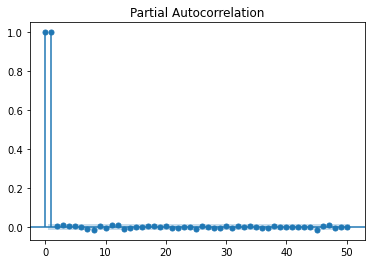

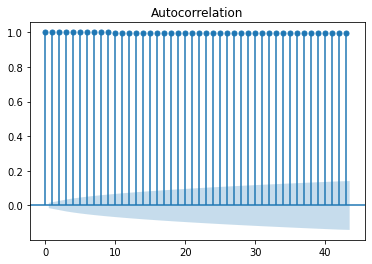

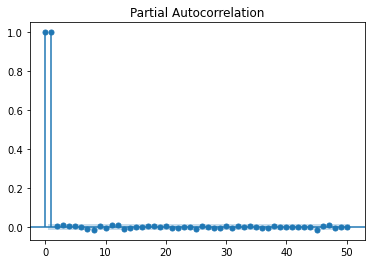

In [10]:
plot_acf(resampled_series)
plot_pacf(resampled_series, lags=50)

### TSA Decomposition

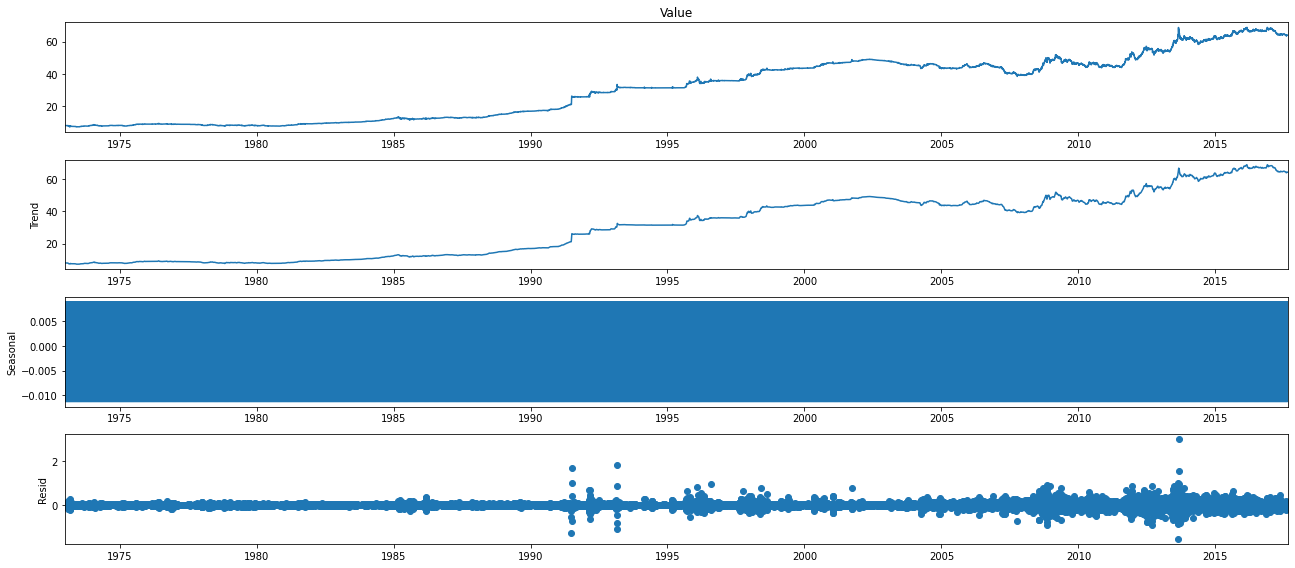

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(resampled_series, model='additive')
fig = decomposition.plot()
plt.show()

### Generating parameters for different ARIMA/SARIMAX Models

In [12]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


Every predictor added to a model increases R-squared and never decreases it. Thus, a model with more terms may seem to have a better fit just for the fact that it has more terms, while the adjusted R-squared compensates for the addition of variables and only increases if the new term enhances the model above what would be obtained by probability and decreases when a predictor enhances the model less than what is predicted by chance. In an overfitting condition, an incorrectly high value of R-squared is obtained, even when the model actually has a decreased ability to predict. This is not the case with the adjusted R-squared.

### Comparing Models for ARIMA

In [36]:
param_list=list()
aic_list=list()
bic_list=list()
sse_list=list()
R_list=list()
adjR_list=list()
SER_list=list()

for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{} \nAIC = {} \nBIC = {} \nSSE = {}'.format(param,results.aic,results.bic,results.sse))
            
            #R square calculation
            data_mean = sum(train_data)/len(train_data)
            TSS_list = train_data-data_mean
            TSS_list = [i**2 for i in TSS_list]
            TSS = sum(TSS_list)
            R_squared = 1 - results.sse/TSS
            print("R squared = ",R_squared)
            
            #Adjusted R square calculation
            N = len(train_data)
            p = sum(param)
            R_squared_adj = 1 - ((1 - R_squared)*(N-1))/(N - (p + 1))
            print("Adjusted R squared = ",R_squared_adj)
            
            #Standard Error of Regression Calculation
            std_dev = pow(TSS/N,0.5)
            SER = pow(1 - R_squared_adj,0.5) * std_dev
            print("SER = ",SER)
            
            param_list.append(param)
            aic_list.append(results.aic)
            bic_list.append(results.bic)
            sse_list.append(results.sse)
            R_list.append(R_squared)
            adjR_list.append(R_squared_adj)
            SER_list.append(SER)
            
            print("------------------------------")
            
        except:
            continue


ARIMA(0, 0, 0) 
AIC = 68452.67424370497 
BIC = 68459.68026227987 
SSE = 2115849.7783315
R squared =  -3.2949593617238024
Adjusted R squared =  -3.2949593617238024
SER =  16.109560566857272
------------------------------
ARIMA(0, 0, 1) 
AIC = 57228.82948208144 
BIC = 57242.84127387763 
SSE = 534163.8115909578
R squared =  -0.0842980852335391
Adjusted R squared =  -0.08443111162112737
SER =  8.094781842952926
------------------------------
ARIMA(0, 0, 2) 
AIC = 46661.18543042737 
BIC = 46682.202750046075 
SSE = 146293.1276251066
R squared =  0.7030398639430893
Adjusted R squared =  0.7029669902900691
SER =  4.236493285277724
------------------------------
ARIMA(0, 1, 0) 
AIC = -19113.48761608316 
BIC = -19106.481720185064 
SSE = 110.054673
R squared =  0.9997766002327086
Adjusted R squared =  0.9997765728250572
SER =  0.11619091228724354
------------------------------
ARIMA(0, 1, 1) 
AIC = -19148.355659727647 
BIC = -19134.34411331518 
SSE = 109.82996977721962
R squared =  0.999777056357

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 0) 
AIC = -19131.13110356093 
BIC = -19117.119066411124 
SSE = 109.96332832053903
R squared =  0.9997767856530962
Adjusted R squared =  0.9997767582681929
SER =  0.11614268341824238
------------------------------
ARIMA(1, 0, 1) 
AIC = -19168.471165626892 
BIC = -19147.45347793261 
SSE = 109.72489223591494
R squared =  0.9997772696540421
Adjusted R squared =  0.9997772149962885
SER =  0.11602381499396813
------------------------------


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 0, 2) 
AIC = -19219.700427684707 
BIC = -19191.677334859767 
SSE = 109.41114465411674
R squared =  0.9997779065296499
Adjusted R squared =  0.99977782476742
SER =  0.11586492537364927
------------------------------


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0) 
AIC = -19158.42378234888 
BIC = -19144.41199055269 
SSE = 109.88440530907943
R squared =  0.9997769458587642
Adjusted R squared =  0.9997768911215517
SER =  0.1161081194463228
------------------------------
ARIMA(1, 1, 1) 
AIC = -19198.623562176457 
BIC = -19177.60624255775 
SSE = 116.23059412747915
R squared =  0.999764063742389
Adjusted R squared =  0.9997639768840294
SER =  0.11942120094979795
------------------------------
ARIMA(1, 1, 2) 
AIC = -19205.97758862653 
BIC = -19177.95498662925 
SSE = 111.09830127427563
R squared =  0.9997744817736985
Adjusted R squared =  0.9997743710627381
SER =  0.11676201023650098
------------------------------
ARIMA(1, 2, 0) 
AIC = -16154.600800654765 
BIC = -16140.589254242295 
SSE = 145.58721468295485
R squared =  0.9997044727952553
Adjusted R squared =  0.999704363998886
SER =  0.13365426566669167
------------------------------
ARIMA(1, 2, 1) 
AIC = -19164.974734121923 
BIC = -19143.957782623962 
SSE = 136.12800409255328
R squared

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 0, 0) 
AIC = -19175.722323304853 
BIC = -19154.70463561057 
SSE = 110.07531041521597
R squared =  0.9997765583408594
Adjusted R squared =  0.9997765035085504
SER =  0.11620893454346014
------------------------------
ARIMA(2, 0, 1) 
AIC = -19218.11135650798 
BIC = -19190.0877729156 
SSE = 135.22543486696327
R squared =  0.9997255061520091
Adjusted R squared =  0.9997254050989297
SER =  0.12881024278754927
------------------------------
ARIMA(2, 0, 2) 
AIC = -19224.077306920823 
BIC = -19189.04844088965 
SSE = 116.91152843622064
R squared =  0.9997626815151562
Adjusted R squared =  0.9997625650112363
SER =  0.11977785276704182
------------------------------


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(2, 1, 0) 
AIC = -19209.85838387078 
BIC = -19188.841064252072 
SSE = 109.67864937409192
R squared =  0.9997773635223376
Adjusted R squared =  0.9997772815602032
SER =  0.11600648084634872
------------------------------
ARIMA(2, 1, 1) 
AIC = -19209.852244155816 
BIC = -19181.829151330876 
SSE = 110.57905652418394
R squared =  0.9997755357876098
Adjusted R squared =  0.9997754255940838
SER =  0.11648883294156095
------------------------------
ARIMA(2, 1, 2) 
AIC = -19204.56707246263 
BIC = -19169.538819966026 
SSE = 110.38502276034487
R squared =  0.9997759296563707
Adjusted R squared =  0.9997757921392825
SER =  0.11639372891731756
------------------------------
ARIMA(2, 2, 0) 
AIC = -16930.20756876242 
BIC = -16909.19061726446 
SSE = 141.17735495458084
R squared =  0.9997134243609659
Adjusted R squared =  0.9997132836758216
SER =  0.1316225724934796
------------------------------
ARIMA(2, 2, 1) 
AIC = -19214.073513099116 
BIC = -19186.050911101836 
SSE = 136.12138535477047
R squa

In [46]:
print("AIC", min((v,i) for i,v in enumerate(aic_list)))
print("BIC", min((v,i) for i,v in enumerate(bic_list)))
print("SSE", min((v,i) for i,v in enumerate(sse_list)))
print("R", max((v,i) for i,v in enumerate(R_list)))
print("ADJR", max((v,i) for i,v in enumerate(adjR_list)))
print("SER", min((v,i) for i,v in enumerate(SER_list)))

AIC (-19224.077306920823, 20)
BIC (-19191.677334859767, 11)
SSE (109.41114465411674, 11)
R (0.9997779065296499, 11)
ADJR (0.99977782476742, 11)
SER (0.11586492537364927, 11)


In [49]:
param_list[11],param_list[20]

((1, 0, 2), (2, 0, 2))

#### Best Model: ARIMA(1,0,2)

### Forecast with ARIMA

In [50]:
import statsmodels.api as sm
# walk-forward validation
predictions = list()

model = sm.tsa.statespace.SARIMAX(resampled_series,
                            order=(1, 0, 2),
                            enforce_stationarity=False,
                            enforce_invertibility=False)             

results = model.fit(disp=0)

In [51]:
resampled_df = pd.DataFrame(resampled_series)
resampled_df.iloc[train_size]

Value    31.45
Name: 1995-04-30 00:00:00, dtype: float64

In [88]:
import numpy as np
all_dates=np.array(resampled_series.keys())
test_dates=all_dates[train_size:]

In [53]:
start_date='1995-04-30'

In [54]:
pred = results.get_prediction(start=pd.to_datetime(start_date), dynamic=False)
pred_ci = pred.conf_int()

In [55]:
predictions = pred.predicted_mean
history = resampled_series[start_date:]

### Rolling forecast

Here, a monthly rolling forecast is implemented, where the future predictions are made based on previous predictions. 

In [62]:
def StartARIMAForecasting(Data, P, D, Q):
    model = sm.tsa.statespace.SARIMAX(Data,
                                order=(P, D, Q),
                                enforce_stationarity=False,
                                enforce_invertibility=False)             

    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0]
    return prediction

In [63]:
true_rolling_history = [x for x in train_data]
rolling_history = [x for x in train_data]
rolling_predictions = list()

In [64]:
for i in range(len(test_data)):
    # predict
    yhat = StartARIMAForecasting(rolling_history,1,0,2)
    rolling_predictions.append(yhat)
    # observation
    obs = test_data[i]
    if (i%30 != 0):
        rolling_history.append(yhat)
    else:
        rolling_history = true_rolling_history.copy()
    true_rolling_history.append(obs)
    print('>Predicted=%f, Expected=%f' % (yhat, obs))
    

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.461345, Expected=31.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.461345, Expected=31.440000
>Predicted=31.467616, Expected=31.432000
>Predicted=31.474154, Expected=31.430000
>Predicted=31.480695, Expected=31.420000
>Predicted=31.487236, Expected=31.420000
>Predicted=31.493779, Expected=31.420000
>Predicted=31.500323, Expected=31.420000
>Predicted=31.506869, Expected=31.400000
>Predicted=31.513415, Expected=31.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.519964, Expected=31.435000
>Predicted=31.526513, Expected=31.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.533064, Expected=31.440000
>Predicted=31.539617, Expected=31.440000
>Predicted=31.546170, Expected=31.440000
>Predicted=31.552725, Expected=31.450000
>Predicted=31.559282, Expected=31.450000
>Predicted=31.565840, Expected=31.440000
>Predicted=31.572399, Expected=31.440000
>Predicted=31.578959, Expected=31.420000
>Predicted=31.585521, Expected=31.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.592084, Expected=31.420000
>Predicted=31.598649, Expected=31.407000
>Predicted=31.605215, Expected=31.387000
>Predicted=31.611782, Expected=31.400000
>Predicted=31.618351, Expected=31.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.624921, Expected=31.400000
>Predicted=31.631492, Expected=31.400000
>Predicted=31.638065, Expected=31.400000
>Predicted=31.644639, Expected=31.400000
>Predicted=31.651215, Expected=31.372500
>Predicted=31.406369, Expected=31.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.412262, Expected=31.420000
>Predicted=31.418674, Expected=31.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.425087, Expected=31.440000
>Predicted=31.431501, Expected=31.440000
>Predicted=31.437917, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.444333, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.450752, Expected=31.412000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.457171, Expected=31.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.463592, Expected=31.420000
>Predicted=31.470014, Expected=31.420000
>Predicted=31.476437, Expected=31.420000
>Predicted=31.482862, Expected=31.420000
>Predicted=31.489288, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.495715, Expected=31.400000
>Predicted=31.502144, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.508574, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.515005, Expected=31.400000
>Predicted=31.521438, Expected=31.400000
>Predicted=31.527872, Expected=31.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.534307, Expected=31.400000
>Predicted=31.540744, Expected=31.390000
>Predicted=31.547181, Expected=31.380000
>Predicted=31.553621, Expected=31.390000
>Predicted=31.560061, Expected=31.390000
>Predicted=31.566503, Expected=31.390000
>Predicted=31.572946, Expected=31.377000
>Predicted=31.579390, Expected=31.375000
>Predicted=31.585836, Expected=31.407000
>Predicted=31.592283, Expected=31.430000
>Predicted=31.410677, Expected=31.410000
>Predicted=31.419258, Expected=31.410000
>Predicted=31.425587, Expected=31.410000
>Predicted=31.431917, Expected=31.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.438248, Expected=31.410000
>Predicted=31.444581, Expected=31.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.450915, Expected=31.380000
>Predicted=31.457250, Expected=31.390000
>Predicted=31.463587, Expected=31.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.469925, Expected=31.390000
>Predicted=31.476264, Expected=31.372000
>Predicted=31.482604, Expected=31.402000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.488946, Expected=31.370000
>Predicted=31.495289, Expected=31.372000
>Predicted=31.501633, Expected=31.370000
>Predicted=31.507979, Expected=31.370000
>Predicted=31.514326, Expected=31.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.520674, Expected=31.380000
>Predicted=31.527023, Expected=31.380000
>Predicted=31.533374, Expected=31.390000
>Predicted=31.539726, Expected=31.380000
>Predicted=31.546079, Expected=31.370000
>Predicted=31.552433, Expected=31.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.558789, Expected=31.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.565146, Expected=31.380000
>Predicted=31.571504, Expected=31.377000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.577864, Expected=31.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.584225, Expected=31.387000
>Predicted=31.590587, Expected=31.395000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.596950, Expected=31.395000
>Predicted=31.400500, Expected=31.395000
>Predicted=31.406794, Expected=31.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.413030, Expected=31.420000
>Predicted=31.419267, Expected=31.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.425506, Expected=31.417000
>Predicted=31.431745, Expected=31.420000
>Predicted=31.437986, Expected=31.420000
>Predicted=31.444228, Expected=31.420000
>Predicted=31.450472, Expected=31.440000
>Predicted=31.456717, Expected=31.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.462962, Expected=31.470000
>Predicted=31.469210, Expected=31.450000
>Predicted=31.475458, Expected=31.457000
>Predicted=31.481708, Expected=31.457000
>Predicted=31.487959, Expected=31.457000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.494211, Expected=31.495000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.500464, Expected=31.490000
>Predicted=31.506719, Expected=31.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.512975, Expected=31.595000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.519232, Expected=31.590000
>Predicted=31.525490, Expected=31.590000
>Predicted=31.531750, Expected=31.590000
>Predicted=31.538010, Expected=31.620000
>Predicted=31.544272, Expected=31.630000
>Predicted=31.550536, Expected=31.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.556800, Expected=31.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.563066, Expected=31.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.569333, Expected=31.720000
>Predicted=31.575601, Expected=31.720000
>Predicted=31.581871, Expected=31.850000
>Predicted=31.724321, Expected=31.850000
>Predicted=31.730740, Expected=31.830000
>Predicted=31.737101, Expected=31.870000
>Predicted=31.743463, Expected=31.925000
>Predicted=31.749827, Expected=31.925000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.756192, Expected=31.925000
>Predicted=31.762558, Expected=31.925000
>Predicted=31.768926, Expected=32.400000
>Predicted=31.775295, Expected=32.290000
>Predicted=31.781665, Expected=32.210000
>Predicted=31.788036, Expected=32.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.794409, Expected=32.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.800783, Expected=32.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.807158, Expected=32.470000
>Predicted=31.813535, Expected=32.710000
>Predicted=31.819913, Expected=32.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.826292, Expected=34.050000
>Predicted=31.832672, Expected=33.900000
>Predicted=31.839054, Expected=33.900000
>Predicted=31.845437, Expected=33.900000
>Predicted=31.851821, Expected=33.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.858206, Expected=33.890000
>Predicted=31.864593, Expected=33.840000
>Predicted=31.870981, Expected=34.000000
>Predicted=31.877370, Expected=33.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.883761, Expected=33.820000
>Predicted=31.890153, Expected=33.820000
>Predicted=31.896546, Expected=34.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=31.902940, Expected=33.920000
>Predicted=31.909336, Expected=33.910000
>Predicted=33.948231, Expected=33.990000
>Predicted=33.949384, Expected=33.940000
>Predicted=33.957165, Expected=33.940000
>Predicted=33.964948, Expected=33.940000
>Predicted=33.972732, Expected=33.920000
>Predicted=33.980519, Expected=33.900000
>Predicted=33.988307, Expected=33.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=33.996096, Expected=33.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.003888, Expected=33.910000
>Predicted=34.011681, Expected=33.910000
>Predicted=34.019476, Expected=33.910000
>Predicted=34.027273, Expected=33.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.035072, Expected=33.890000
>Predicted=34.042872, Expected=33.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.050675, Expected=33.965000
>Predicted=34.058479, Expected=34.350000
>Predicted=34.066285, Expected=34.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.074092, Expected=34.350000
>Predicted=34.081902, Expected=34.600000
>Predicted=34.089713, Expected=34.850000
>Predicted=34.097526, Expected=34.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.105341, Expected=35.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.113157, Expected=35.650000
>Predicted=34.120976, Expected=35.650000
>Predicted=34.128796, Expected=35.650000
>Predicted=34.136618, Expected=35.650000
>Predicted=34.144442, Expected=35.600000
>Predicted=34.152267, Expected=35.600000
>Predicted=34.160095, Expected=35.600000
>Predicted=34.167924, Expected=35.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.608255, Expected=35.500000
>Predicted=35.616754, Expected=35.500000
>Predicted=35.625678, Expected=34.900000
>Predicted=35.634605, Expected=34.300000
>Predicted=35.643533, Expected=34.600000
>Predicted=35.652464, Expected=34.500000
>Predicted=35.661397, Expected=34.700000
>Predicted=35.670333, Expected=34.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.679271, Expected=34.700000
>Predicted=35.688210, Expected=34.770000
>Predicted=35.697153, Expected=34.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.706097, Expected=34.350000
>Predicted=35.715044, Expected=34.530000
>Predicted=35.723992, Expected=34.560000
>Predicted=35.732944, Expected=34.560000
>Predicted=35.741897, Expected=34.560000
>Predicted=35.750853, Expected=34.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.759810, Expected=34.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.768770, Expected=34.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.777733, Expected=34.810000
>Predicted=35.786697, Expected=34.710000
>Predicted=35.795664, Expected=34.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.804633, Expected=34.710000
>Predicted=35.813605, Expected=34.820000
>Predicted=35.822578, Expected=34.820000
>Predicted=35.831554, Expected=34.830000
>Predicted=35.840532, Expected=34.830000
>Predicted=35.849512, Expected=34.880000
>Predicted=35.858495, Expected=34.880000
>Predicted=35.867480, Expected=34.880000
>Predicted=34.892004, Expected=34.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.899813, Expected=34.930000
>Predicted=34.908037, Expected=34.910000
>Predicted=34.916263, Expected=34.910000
>Predicted=34.924491, Expected=34.930000
>Predicted=34.932721, Expected=34.930000
>Predicted=34.940953, Expected=34.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.949186, Expected=34.920000
>Predicted=34.957422, Expected=34.870000
>Predicted=34.965660, Expected=34.840000
>Predicted=34.973899, Expected=34.840000
>Predicted=34.982141, Expected=34.930000
>Predicted=34.990384, Expected=34.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.998629, Expected=34.930000
>Predicted=35.006876, Expected=34.840000
>Predicted=35.015126, Expected=34.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.023377, Expected=34.960000
>Predicted=35.031630, Expected=34.975000
>Predicted=35.039885, Expected=34.970000
>Predicted=35.048142, Expected=34.970000
>Predicted=35.056401, Expected=34.970000
>Predicted=35.064662, Expected=34.990000
>Predicted=35.072925, Expected=34.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.081189, Expected=34.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.089456, Expected=35.030000
>Predicted=35.097725, Expected=34.990000
>Predicted=35.105995, Expected=34.990000
>Predicted=35.114268, Expected=34.990000
>Predicted=35.122542, Expected=34.990000
>Predicted=35.130819, Expected=35.010000
>Predicted=34.998175, Expected=35.070000
>Predicted=35.005744, Expected=35.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.013920, Expected=35.180000
>Predicted=35.022098, Expected=35.180000
>Predicted=35.030278, Expected=35.180000
>Predicted=35.038460, Expected=35.180000
>Predicted=35.046644, Expected=35.210000
>Predicted=35.054830, Expected=35.220000
>Predicted=35.063018, Expected=35.320000
>Predicted=35.071207, Expected=35.440000
>Predicted=35.079399, Expected=35.440000
>Predicted=35.087592, Expected=35.440000
>Predicted=35.095787, Expected=35.850000
>Predicted=35.103985, Expected=35.870000
>Predicted=35.112184, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.120385, Expected=35.810000
>Predicted=35.128588, Expected=35.780000
>Predicted=35.136793, Expected=35.780000
>Predicted=35.145000, Expected=35.780000
>Predicted=35.153209, Expected=35.780000
>Predicted=35.161419, Expected=35.910000
>Predicted=35.169632, Expected=35.860000
>Predicted=35.177846, Expected=35.895000
>Predicted=35.186063, Expected=35.910000
>Predicted=35.194281, Expected=35.910000
>Predicted=35.202502, Expected=35.910000
>Predicted=35.210724, Expected=35.850000
>Predicted=35.218948, Expected=35.760000
>Predicted=35.227174, Expected=35.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.235402, Expected=36.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.836033, Expected=36.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.850511, Expected=36.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.859196, Expected=36.070000
>Predicted=35.867882, Expected=35.990000
>Predicted=35.876571, Expected=36.140000
>Predicted=35.885262, Expected=36.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.893955, Expected=36.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.902650, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.911347, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.920047, Expected=36.800000
>Predicted=35.928748, Expected=38.050000
>Predicted=35.937452, Expected=37.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.946157, Expected=37.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.954865, Expected=37.200000
>Predicted=35.963575, Expected=36.950000
>Predicted=35.972287, Expected=36.950000
>Predicted=35.981001, Expected=36.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.989717, Expected=36.970000
>Predicted=35.998435, Expected=36.760000
>Predicted=36.007156, Expected=36.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.015878, Expected=36.530000
>Predicted=36.024603, Expected=36.550000
>Predicted=36.033330, Expected=36.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.042059, Expected=36.550000
>Predicted=36.050790, Expected=36.550000
>Predicted=36.059523, Expected=36.560000
>Predicted=36.068258, Expected=36.630000
>Predicted=36.076995, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.085735, Expected=36.280000
>Predicted=36.094476, Expected=36.280000
>Predicted=36.332131, Expected=36.280000
>Predicted=36.304189, Expected=35.920000
>Predicted=36.313069, Expected=35.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.321952, Expected=35.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.330836, Expected=34.850000
>Predicted=36.339723, Expected=34.600000
>Predicted=36.348612, Expected=34.600000
>Predicted=36.357503, Expected=34.600000
>Predicted=36.366397, Expected=34.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.375292, Expected=34.300000
>Predicted=36.384190, Expected=34.120000
>Predicted=36.393090, Expected=34.250000
>Predicted=36.401992, Expected=34.200000
>Predicted=36.410896, Expected=34.200000
>Predicted=36.419802, Expected=34.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.428711, Expected=34.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.437622, Expected=34.130000
>Predicted=36.446535, Expected=34.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.455450, Expected=34.150000
>Predicted=36.464367, Expected=34.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.473287, Expected=34.480000
>Predicted=36.482208, Expected=34.480000
>Predicted=36.491132, Expected=35.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.500058, Expected=35.350000
>Predicted=36.508987, Expected=35.500000
>Predicted=36.517917, Expected=35.000000
>Predicted=36.526850, Expected=34.600000
>Predicted=36.535784, Expected=34.600000
>Predicted=36.544721, Expected=34.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.553660, Expected=34.100000
>Predicted=34.607148, Expected=34.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.616537, Expected=34.550000
>Predicted=34.624023, Expected=34.200000
>Predicted=34.631510, Expected=34.350000
>Predicted=34.638998, Expected=34.350000
>Predicted=34.646488, Expected=34.350000
>Predicted=34.653980, Expected=34.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.661473, Expected=34.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.668968, Expected=34.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.676465, Expected=34.500000
>Predicted=34.683963, Expected=34.200000
>Predicted=34.691463, Expected=34.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.698964, Expected=34.200000
>Predicted=34.706467, Expected=34.150000
>Predicted=34.713972, Expected=34.150000
>Predicted=34.721479, Expected=34.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.728986, Expected=34.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.736496, Expected=34.250000
>Predicted=34.744007, Expected=34.250000
>Predicted=34.751520, Expected=34.250000
>Predicted=34.759034, Expected=34.500000
>Predicted=34.766551, Expected=34.400000
>Predicted=34.774068, Expected=34.250000
>Predicted=34.781588, Expected=34.300000
>Predicted=34.789109, Expected=34.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.796631, Expected=34.250000
>Predicted=34.804155, Expected=34.250000
>Predicted=34.811681, Expected=34.200000
>Predicted=34.819209, Expected=34.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.826738, Expected=34.250000
>Predicted=34.298478, Expected=34.350000
>Predicted=34.312080, Expected=34.350000
>Predicted=34.319254, Expected=34.350000
>Predicted=34.326430, Expected=34.350000
>Predicted=34.333607, Expected=34.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.340785, Expected=35.000000
>Predicted=34.347965, Expected=34.800000
>Predicted=34.355147, Expected=34.750000
>Predicted=34.362330, Expected=34.650000
>Predicted=34.369514, Expected=34.650000
>Predicted=34.376700, Expected=34.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.383888, Expected=34.650000
>Predicted=34.391077, Expected=34.450000
>Predicted=34.398267, Expected=34.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.405459, Expected=35.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.412653, Expected=35.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.419848, Expected=35.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.427045, Expected=35.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.434243, Expected=35.400000
>Predicted=34.441442, Expected=35.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.448643, Expected=34.900000
>Predicted=34.455846, Expected=35.000000
>Predicted=34.463050, Expected=35.100000
>Predicted=34.470255, Expected=35.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.477463, Expected=35.100000
>Predicted=34.484671, Expected=35.100000
>Predicted=34.491881, Expected=35.200000
>Predicted=34.499093, Expected=35.050000
>Predicted=34.506306, Expected=35.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=34.513521, Expected=35.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.095860, Expected=35.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.105375, Expected=35.250000
>Predicted=35.112982, Expected=35.250000
>Predicted=35.120590, Expected=35.180000
>Predicted=35.128200, Expected=35.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.135811, Expected=35.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.143425, Expected=35.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.151039, Expected=35.230000
>Predicted=35.158656, Expected=35.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.166274, Expected=35.100000
>Predicted=35.173894, Expected=35.100000
>Predicted=35.181515, Expected=35.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.189138, Expected=35.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.196763, Expected=35.000000
>Predicted=35.204390, Expected=35.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.212018, Expected=35.000000
>Predicted=35.219647, Expected=35.000000
>Predicted=35.227279, Expected=35.050000
>Predicted=35.234912, Expected=35.050000
>Predicted=35.242546, Expected=35.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.250183, Expected=35.100000
>Predicted=35.257821, Expected=35.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.265460, Expected=35.100000
>Predicted=35.273101, Expected=35.100000
>Predicted=35.280744, Expected=35.150000
>Predicted=35.288389, Expected=35.100000
>Predicted=35.296035, Expected=35.100000
>Predicted=35.303683, Expected=35.050000
>Predicted=35.311333, Expected=35.050000
>Predicted=35.318984, Expected=35.050000
>Predicted=35.054280, Expected=35.100000
>Predicted=35.061115, Expected=35.100000
>Predicted=35.068583, Expected=35.100000
>Predicted=35.076052, Expected=35.200000
>Predicted=35.083523, Expected=35.430000
>Predicted=35.090995, Expected=35.430000
>Predicted=35.098469, Expected=35.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.105944, Expected=35.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.113422, Expected=35.150000
>Predicted=35.120900, Expected=35.150000
>Predicted=35.128380, Expected=35.150000
>Predicted=35.135862, Expected=35.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.143346, Expected=35.200000
>Predicted=35.150831, Expected=35.200000
>Predicted=35.158318, Expected=35.450000
>Predicted=35.165806, Expected=35.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.173296, Expected=35.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.180787, Expected=35.600000
>Predicted=35.188280, Expected=35.600000
>Predicted=35.195775, Expected=35.600000
>Predicted=35.203271, Expected=35.600000
>Predicted=35.210769, Expected=35.700000
>Predicted=35.218268, Expected=35.950000
>Predicted=35.225769, Expected=36.000000
>Predicted=35.233272, Expected=35.830000
>Predicted=35.240776, Expected=35.800000
>Predicted=35.248282, Expected=35.800000
>Predicted=35.255789, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.263298, Expected=35.750000
>Predicted=35.270809, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.760498, Expected=35.750000
>Predicted=35.764495, Expected=35.850000
>Predicted=35.772338, Expected=35.800000
>Predicted=35.780184, Expected=35.800000
>Predicted=35.788031, Expected=35.800000
>Predicted=35.795880, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.803731, Expected=36.850000
>Predicted=35.811583, Expected=35.700000
>Predicted=35.819437, Expected=35.650000
>Predicted=35.827293, Expected=35.550000
>Predicted=35.835151, Expected=35.550000
>Predicted=35.843010, Expected=35.550000
>Predicted=35.850871, Expected=35.800000
>Predicted=35.858734, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.866599, Expected=35.800000
>Predicted=35.874465, Expected=35.950000
>Predicted=35.882333, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.890202, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.898074, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.905947, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.913822, Expected=35.800000
>Predicted=35.921698, Expected=35.800000
>Predicted=35.929577, Expected=35.800000
>Predicted=35.937457, Expected=35.800000
>Predicted=35.945338, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.953222, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.961107, Expected=35.800000
>Predicted=35.968994, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.976883, Expected=35.700000
>Predicted=35.984773, Expected=35.800000
>Predicted=35.714428, Expected=35.800000
>Predicted=35.715169, Expected=35.800000
>Predicted=35.722864, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.730560, Expected=35.850000
>Predicted=35.738257, Expected=35.850000
>Predicted=35.745956, Expected=35.850000
>Predicted=35.753657, Expected=35.850000
>Predicted=35.761360, Expected=35.850000
>Predicted=35.769064, Expected=35.850000
>Predicted=35.776770, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.784478, Expected=35.850000
>Predicted=35.792187, Expected=35.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.799898, Expected=35.950000
>Predicted=35.807610, Expected=35.950000
>Predicted=35.815324, Expected=35.850000
>Predicted=35.823040, Expected=35.850000
>Predicted=35.830758, Expected=35.850000
>Predicted=35.838477, Expected=35.850000
>Predicted=35.846198, Expected=35.850000
>Predicted=35.853920, Expected=35.850000
>Predicted=35.861644, Expected=35.950000
>Predicted=35.869370, Expected=35.850000
>Predicted=35.877098, Expected=35.850000
>Predicted=35.884827, Expected=35.850000
>Predicted=35.892558, Expected=35.900000
>Predicted=35.900290, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.908024, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.915760, Expected=35.850000
>Predicted=35.923498, Expected=35.900000
>Predicted=35.931237, Expected=35.900000
>Predicted=35.901346, Expected=35.900000
>Predicted=35.911565, Expected=35.850000
>Predicted=35.919285, Expected=35.850000
>Predicted=35.927006, Expected=35.850000
>Predicted=35.934729, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.942454, Expected=35.850000
>Predicted=35.950181, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.957909, Expected=35.850000
>Predicted=35.965639, Expected=35.850000
>Predicted=35.973370, Expected=35.850000
>Predicted=35.981103, Expected=35.850000
>Predicted=35.988838, Expected=35.800000
>Predicted=35.996574, Expected=35.800000
>Predicted=36.004313, Expected=35.800000
>Predicted=36.012052, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.019794, Expected=35.850000
>Predicted=36.027537, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.035282, Expected=35.850000
>Predicted=36.043028, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.050776, Expected=35.700000
>Predicted=36.058526, Expected=35.700000
>Predicted=36.066277, Expected=35.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.074031, Expected=35.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.081785, Expected=35.750000
>Predicted=36.089542, Expected=35.750000
>Predicted=36.097300, Expected=35.800000
>Predicted=36.105060, Expected=35.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.112821, Expected=35.730000
>Predicted=36.120584, Expected=35.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.128349, Expected=35.850000
>Predicted=35.736781, Expected=35.850000
>Predicted=35.744038, Expected=35.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.751536, Expected=35.750000
>Predicted=35.759036, Expected=35.750000
>Predicted=35.766538, Expected=35.750000
>Predicted=35.774040, Expected=35.750000
>Predicted=35.781545, Expected=35.800000
>Predicted=35.789051, Expected=35.850000
>Predicted=35.796559, Expected=35.850000
>Predicted=35.804068, Expected=35.900000
>Predicted=35.811579, Expected=35.840000
>Predicted=35.819091, Expected=35.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.826605, Expected=35.840000
>Predicted=35.834121, Expected=35.750000
>Predicted=35.841638, Expected=35.740000
>Predicted=35.849156, Expected=35.850000
>Predicted=35.856677, Expected=35.850000
>Predicted=35.864198, Expected=36.120000
>Predicted=35.871722, Expected=36.120000
>Predicted=35.879247, Expected=36.120000
>Predicted=35.886773, Expected=36.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.894302, Expected=35.900000
>Predicted=35.901831, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.909363, Expected=36.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.916896, Expected=35.950000
>Predicted=35.924430, Expected=35.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.931966, Expected=35.950000
>Predicted=35.939504, Expected=35.850000
>Predicted=35.947043, Expected=35.757000
>Predicted=35.954584, Expected=35.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.764886, Expected=35.750000
>Predicted=35.765469, Expected=35.750000
>Predicted=35.772877, Expected=35.750000
>Predicted=35.780286, Expected=35.750000
>Predicted=35.787696, Expected=35.850000
>Predicted=35.795109, Expected=35.900000
>Predicted=35.802522, Expected=35.740000
>Predicted=35.809938, Expected=35.740000
>Predicted=35.817354, Expected=35.747000
>Predicted=35.824773, Expected=35.747000
>Predicted=35.832193, Expected=35.747000
>Predicted=35.839614, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.847037, Expected=35.750000
>Predicted=35.854462, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.861888, Expected=35.870000
>Predicted=35.869315, Expected=35.900000
>Predicted=35.876744, Expected=35.900000
>Predicted=35.884175, Expected=35.900000
>Predicted=35.891607, Expected=35.922000
>Predicted=35.899041, Expected=35.910000
>Predicted=35.906476, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.913913, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.921351, Expected=35.900000
>Predicted=35.928791, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.936232, Expected=35.900000
>Predicted=35.943675, Expected=35.890000
>Predicted=35.951120, Expected=35.850000
>Predicted=35.958566, Expected=35.950000
>Predicted=35.966014, Expected=35.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.973463, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.935061, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.940693, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.948115, Expected=35.880000
>Predicted=35.955539, Expected=35.850000
>Predicted=35.962964, Expected=35.850000
>Predicted=35.970391, Expected=35.850000
>Predicted=35.977819, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.985249, Expected=35.850000
>Predicted=35.992680, Expected=35.850000
>Predicted=36.000113, Expected=35.950000
>Predicted=36.007548, Expected=35.950000
>Predicted=36.014983, Expected=35.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.022421, Expected=36.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.029860, Expected=35.950000
>Predicted=36.037300, Expected=35.950000
>Predicted=36.044742, Expected=35.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.052186, Expected=35.930000
>Predicted=36.059631, Expected=35.970000
>Predicted=36.067078, Expected=35.950000
>Predicted=36.074526, Expected=35.897000
>Predicted=36.081976, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.089427, Expected=35.900000
>Predicted=36.096880, Expected=35.900000
>Predicted=36.104334, Expected=35.900000
>Predicted=36.111790, Expected=35.900000
>Predicted=36.119248, Expected=35.880000
>Predicted=36.126707, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.134167, Expected=35.890000
>Predicted=36.141629, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.149093, Expected=35.890000
>Predicted=35.897979, Expected=35.890000
>Predicted=35.904865, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.912164, Expected=35.900000
>Predicted=35.919464, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.926765, Expected=35.820000
>Predicted=35.934068, Expected=35.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.941373, Expected=35.820000
>Predicted=35.948679, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.955986, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.963295, Expected=35.900000
>Predicted=35.970606, Expected=35.830000
>Predicted=35.977918, Expected=35.900000
>Predicted=35.985231, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.992546, Expected=35.900000
>Predicted=35.999862, Expected=35.880000
>Predicted=36.007180, Expected=35.870000
>Predicted=36.014499, Expected=35.880000
>Predicted=36.021820, Expected=35.900000
>Predicted=36.029143, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.036466, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.043792, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.051119, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.058447, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.065777, Expected=35.840000
>Predicted=36.073108, Expected=35.950000
>Predicted=36.080441, Expected=35.890000
>Predicted=36.087775, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.095111, Expected=35.890000
>Predicted=36.102448, Expected=35.890000
>Predicted=36.109786, Expected=35.900000
>Predicted=35.897332, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.904125, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.911326, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.918529, Expected=35.900000
>Predicted=35.925733, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.932938, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.940145, Expected=35.900000
>Predicted=35.947353, Expected=35.860000
>Predicted=35.954563, Expected=35.900000
>Predicted=35.961774, Expected=35.910000
>Predicted=35.968986, Expected=35.910000
>Predicted=35.976200, Expected=35.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.983416, Expected=35.860000
>Predicted=35.990633, Expected=35.895000
>Predicted=35.997851, Expected=35.880000
>Predicted=36.005071, Expected=35.880000
>Predicted=36.012292, Expected=35.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.019515, Expected=35.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.026739, Expected=35.870000
>Predicted=36.033965, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.041192, Expected=35.860000
>Predicted=36.048420, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.055650, Expected=35.870000
>Predicted=36.062882, Expected=35.850000
>Predicted=36.070114, Expected=35.850000
>Predicted=36.077349, Expected=35.850000
>Predicted=36.084584, Expected=35.890000
>Predicted=36.091822, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.099060, Expected=35.900000
>Predicted=36.106300, Expected=35.910000
>Predicted=35.906794, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.913936, Expected=35.900000
>Predicted=35.921049, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.928163, Expected=35.885000
>Predicted=35.935279, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.942396, Expected=35.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.949514, Expected=35.900000
>Predicted=35.956634, Expected=35.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.963755, Expected=35.910000
>Predicted=35.970878, Expected=35.910000
>Predicted=35.978002, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.985128, Expected=35.890000
>Predicted=35.992254, Expected=35.900000
>Predicted=35.999383, Expected=35.870000
>Predicted=36.006512, Expected=35.880000
>Predicted=36.013643, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.020776, Expected=35.880000
>Predicted=36.027910, Expected=35.880000
>Predicted=36.035045, Expected=35.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.042182, Expected=35.860000
>Predicted=36.049320, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.056460, Expected=35.880000
>Predicted=36.063601, Expected=35.880000
>Predicted=36.070743, Expected=35.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.077887, Expected=35.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.085032, Expected=35.837000
>Predicted=36.092179, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.099327, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.106476, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.113627, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.810545, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.815428, Expected=35.780000
>Predicted=35.822387, Expected=35.790000
>Predicted=35.829348, Expected=35.760000
>Predicted=35.836310, Expected=35.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.843273, Expected=35.782000
>Predicted=35.850237, Expected=35.782000
>Predicted=35.857203, Expected=35.782000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.864170, Expected=35.770000
>Predicted=35.871138, Expected=35.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.878108, Expected=35.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.885079, Expected=35.770000
>Predicted=35.892052, Expected=35.760000
>Predicted=35.899026, Expected=35.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.906001, Expected=35.760000
>Predicted=35.912978, Expected=35.800000
>Predicted=35.919956, Expected=35.860000
>Predicted=35.926935, Expected=35.889000
>Predicted=35.933916, Expected=35.872000
>Predicted=35.940898, Expected=35.860000
>Predicted=35.947881, Expected=35.860000
>Predicted=35.954866, Expected=35.860000
>Predicted=35.961852, Expected=35.860000
>Predicted=35.968839, Expected=35.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.975828, Expected=35.855000
>Predicted=35.982818, Expected=35.840000
>Predicted=35.989810, Expected=35.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.996803, Expected=35.840000
>Predicted=36.003797, Expected=35.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.010792, Expected=35.820000
>Predicted=35.846974, Expected=35.795000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.853435, Expected=35.810000
>Predicted=35.860329, Expected=35.790000
>Predicted=35.867224, Expected=35.760000
>Predicted=35.874120, Expected=35.760000
>Predicted=35.881018, Expected=35.760000
>Predicted=35.887917, Expected=35.760000
>Predicted=35.894817, Expected=35.840000
>Predicted=35.901719, Expected=35.820000
>Predicted=35.908622, Expected=35.820000
>Predicted=35.915526, Expected=35.800000
>Predicted=35.922432, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.929339, Expected=35.800000
>Predicted=35.936248, Expected=35.830000
>Predicted=35.943157, Expected=35.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.950068, Expected=35.797000
>Predicted=35.956981, Expected=35.755000
>Predicted=35.963894, Expected=35.800000
>Predicted=35.970809, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.977726, Expected=35.800000
>Predicted=35.984643, Expected=35.800000
>Predicted=35.991562, Expected=35.800000
>Predicted=35.998482, Expected=35.827000
>Predicted=36.005404, Expected=35.850000
>Predicted=36.012327, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.019251, Expected=35.830000
>Predicted=36.026177, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.033104, Expected=35.830000
>Predicted=36.040032, Expected=35.820000
>Predicted=36.046962, Expected=35.790000
>Predicted=35.827522, Expected=35.845000
>Predicted=35.833248, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.840042, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.846838, Expected=35.830000
>Predicted=35.853636, Expected=35.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.860434, Expected=35.840000
>Predicted=35.867234, Expected=35.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.874035, Expected=35.830000
>Predicted=35.880838, Expected=35.830000
>Predicted=35.887642, Expected=35.830000
>Predicted=35.894447, Expected=35.830000
>Predicted=35.901253, Expected=35.850000
>Predicted=35.908061, Expected=35.830000
>Predicted=35.914870, Expected=35.800000
>Predicted=35.921680, Expected=35.790000
>Predicted=35.928492, Expected=35.790000
>Predicted=35.935304, Expected=35.790000
>Predicted=35.942119, Expected=35.790000
>Predicted=35.948934, Expected=35.820000
>Predicted=35.955751, Expected=35.800000
>Predicted=35.962569, Expected=35.780000
>Predicted=35.969388, Expected=35.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.976208, Expected=35.730000
>Predicted=35.983030, Expected=35.730000
>Predicted=35.989853, Expected=35.730000
>Predicted=35.996678, Expected=35.750000
>Predicted=36.003504, Expected=35.730000
>Predicted=36.010331, Expected=35.730000
>Predicted=36.017159, Expected=35.720000
>Predicted=36.023989, Expected=35.710000
>Predicted=35.727125, Expected=35.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.732783, Expected=35.710000
>Predicted=35.739433, Expected=35.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.746084, Expected=35.710000
>Predicted=35.752737, Expected=35.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.759391, Expected=35.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.766046, Expected=35.705000
>Predicted=35.772702, Expected=35.705000
>Predicted=35.779360, Expected=35.705000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.786018, Expected=35.750000
>Predicted=35.792679, Expected=35.737000
>Predicted=35.799340, Expected=35.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.806002, Expected=35.720000
>Predicted=35.812666, Expected=35.800000
>Predicted=35.819331, Expected=35.800000
>Predicted=35.825998, Expected=35.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.832665, Expected=35.800000
>Predicted=35.839334, Expected=35.737000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.846004, Expected=35.735000
>Predicted=35.852675, Expected=35.727000
>Predicted=35.859347, Expected=35.740000
>Predicted=35.866021, Expected=35.740000
>Predicted=35.872696, Expected=35.740000
>Predicted=35.879372, Expected=35.727000
>Predicted=35.886050, Expected=35.730000
>Predicted=35.892728, Expected=35.732000
>Predicted=35.899408, Expected=35.740000
>Predicted=35.906090, Expected=35.810000
>Predicted=35.912772, Expected=35.810000
>Predicted=35.919456, Expected=35.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.820817, Expected=35.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.827290, Expected=35.730000
>Predicted=35.833915, Expected=36.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.840541, Expected=36.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.847168, Expected=36.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.853796, Expected=36.400000
>Predicted=35.860426, Expected=36.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.867057, Expected=36.600000
>Predicted=35.873689, Expected=36.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.880323, Expected=36.500000
>Predicted=35.886957, Expected=36.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.893593, Expected=36.480000
>Predicted=35.900230, Expected=36.480000
>Predicted=35.906869, Expected=36.480000
>Predicted=35.913508, Expected=36.480000
>Predicted=35.920149, Expected=36.570000
>Predicted=35.926791, Expected=36.480000
>Predicted=35.933434, Expected=36.510000
>Predicted=35.940078, Expected=37.000000
>Predicted=35.946724, Expected=37.000000
>Predicted=35.953371, Expected=37.000000
>Predicted=35.960019, Expected=36.560000
>Predicted=35.966669, Expected=36.660000
>Predicted=35.973319, Expected=36.470000
>Predicted=35.979971, Expected=36.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.986624, Expected=36.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=35.993278, Expected=36.600000
>Predicted=35.999934, Expected=36.600000
>Predicted=36.006591, Expected=36.460000
>Predicted=36.013249, Expected=36.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.476456, Expected=36.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.474123, Expected=36.400000
>Predicted=36.481046, Expected=36.500000
>Predicted=36.487970, Expected=36.500000
>Predicted=36.494896, Expected=36.500000
>Predicted=36.501823, Expected=36.400000
>Predicted=36.508752, Expected=36.400000
>Predicted=36.515682, Expected=36.300000
>Predicted=36.522613, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.529545, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.536479, Expected=36.250000
>Predicted=36.543414, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.550350, Expected=36.227000
>Predicted=36.557288, Expected=36.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.564227, Expected=36.200000
>Predicted=36.571167, Expected=37.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.578109, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.585052, Expected=36.250000
>Predicted=36.591996, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.598941, Expected=36.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.605888, Expected=36.250000
>Predicted=36.612837, Expected=36.250000
>Predicted=36.619786, Expected=36.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.626737, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.633689, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.640643, Expected=36.250000
>Predicted=36.647597, Expected=36.250000
>Predicted=36.654553, Expected=36.300000
>Predicted=36.661511, Expected=36.257000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.668470, Expected=36.235000
>Predicted=36.269903, Expected=36.237000
>Predicted=36.273784, Expected=36.237000
>Predicted=36.280502, Expected=36.237000
>Predicted=36.287222, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.293943, Expected=36.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.300665, Expected=36.200000
>Predicted=36.307388, Expected=36.300000
>Predicted=36.314113, Expected=36.300000
>Predicted=36.320839, Expected=36.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.327566, Expected=36.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.334294, Expected=36.340000
>Predicted=36.341024, Expected=36.300000
>Predicted=36.347755, Expected=36.345000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.354487, Expected=36.320000
>Predicted=36.361220, Expected=36.390000
>Predicted=36.367955, Expected=36.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.374691, Expected=36.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.381428, Expected=36.405000
>Predicted=36.388166, Expected=36.400000
>Predicted=36.394906, Expected=36.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.401647, Expected=36.500000
>Predicted=36.408389, Expected=36.550000
>Predicted=36.415132, Expected=36.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.421877, Expected=36.550000
>Predicted=36.428622, Expected=36.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.435370, Expected=36.640000
>Predicted=36.442118, Expected=36.760000
>Predicted=36.448868, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.455618, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.462370, Expected=36.800000
>Predicted=36.810311, Expected=36.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.816622, Expected=36.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.823582, Expected=37.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.830543, Expected=37.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.837505, Expected=37.540000
>Predicted=36.844468, Expected=37.830000
>Predicted=36.851433, Expected=37.830000
>Predicted=36.858399, Expected=37.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.865366, Expected=38.320000
>Predicted=36.872335, Expected=38.265000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.879305, Expected=38.750000
>Predicted=36.886276, Expected=38.750000
>Predicted=36.893249, Expected=39.100000
>Predicted=36.900223, Expected=39.100000
>Predicted=36.907198, Expected=39.100000
>Predicted=36.914175, Expected=39.450000
>Predicted=36.921153, Expected=39.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.928132, Expected=39.450000
>Predicted=36.935112, Expected=39.150000
>Predicted=36.942094, Expected=39.000000
>Predicted=36.949077, Expected=39.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.956062, Expected=39.000000
>Predicted=36.963048, Expected=38.995000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=36.970035, Expected=39.150000
>Predicted=36.977023, Expected=39.150000
>Predicted=36.984013, Expected=39.600000
>Predicted=36.991004, Expected=39.600000
>Predicted=36.997997, Expected=39.600000
>Predicted=37.004990, Expected=39.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=37.011985, Expected=39.575000
>Predicted=39.607230, Expected=40.000000
>Predicted=39.615031, Expected=40.000000
>Predicted=39.623686, Expected=40.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.632342, Expected=40.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.641000, Expected=40.000000
>Predicted=39.649661, Expected=40.000000
>Predicted=39.658323, Expected=39.060000
>Predicted=39.666987, Expected=39.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.675653, Expected=39.000000
>Predicted=39.684321, Expected=39.000000
>Predicted=39.692990, Expected=39.300000
>Predicted=39.701662, Expected=39.300000
>Predicted=39.710335, Expected=39.300000
>Predicted=39.719011, Expected=39.160000
>Predicted=39.727688, Expected=39.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.736367, Expected=39.300000
>Predicted=39.745048, Expected=39.300000
>Predicted=39.753731, Expected=39.400000
>Predicted=39.762416, Expected=39.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.771103, Expected=39.400000
>Predicted=39.779791, Expected=39.480000
>Predicted=39.788482, Expected=39.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.797174, Expected=39.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.805869, Expected=39.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.814565, Expected=39.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.823263, Expected=39.950000
>Predicted=39.831963, Expected=39.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.840665, Expected=39.970000
>Predicted=39.849369, Expected=40.000000
>Predicted=39.858075, Expected=40.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.007805, Expected=40.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.018133, Expected=40.000000
>Predicted=40.026936, Expected=40.000000
>Predicted=40.035740, Expected=40.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.044547, Expected=40.000000
>Predicted=40.053355, Expected=39.200000
>Predicted=40.062165, Expected=38.900000
>Predicted=40.070978, Expected=38.900000
>Predicted=40.079792, Expected=38.850000
>Predicted=40.088608, Expected=38.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.097426, Expected=38.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.106246, Expected=38.410000
>Predicted=40.115068, Expected=38.450000
>Predicted=40.123892, Expected=38.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.132718, Expected=38.800000
>Predicted=40.141546, Expected=38.800000
>Predicted=40.150376, Expected=38.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.159208, Expected=38.800000
>Predicted=40.168041, Expected=38.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.176877, Expected=38.900000
>Predicted=40.185715, Expected=38.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.194554, Expected=38.850000
>Predicted=40.203395, Expected=38.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.212239, Expected=38.850000
>Predicted=40.221084, Expected=38.850000
>Predicted=40.229931, Expected=38.560000
>Predicted=40.238781, Expected=38.900000
>Predicted=40.247632, Expected=38.790000
>Predicted=40.256485, Expected=38.850000
>Predicted=40.265340, Expected=38.850000
>Predicted=38.851228, Expected=38.850000
>Predicted=38.860814, Expected=38.850000
>Predicted=38.868717, Expected=38.850000
>Predicted=38.876622, Expected=38.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=38.884528, Expected=38.900000
>Predicted=38.892436, Expected=38.900000
>Predicted=38.900346, Expected=39.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=38.908257, Expected=39.390000
>Predicted=38.916170, Expected=39.390000
>Predicted=38.924084, Expected=39.300000
>Predicted=38.932000, Expected=39.350000
>Predicted=38.939918, Expected=39.260000
>Predicted=38.947837, Expected=39.300000
>Predicted=38.955758, Expected=39.450000
>Predicted=38.963681, Expected=39.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=38.971605, Expected=39.450000
>Predicted=38.979530, Expected=39.600000
>Predicted=38.987458, Expected=39.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=38.995387, Expected=39.540000
>Predicted=39.003317, Expected=39.540000
>Predicted=39.011249, Expected=39.550000
>Predicted=39.019183, Expected=39.550000
>Predicted=39.027119, Expected=39.550000
>Predicted=39.035056, Expected=39.455000
>Predicted=39.042994, Expected=39.550000
>Predicted=39.050934, Expected=39.530000
>Predicted=39.058876, Expected=39.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.066820, Expected=39.800000
>Predicted=39.074765, Expected=39.800000
>Predicted=39.082712, Expected=39.800000
>Predicted=39.822412, Expected=39.575000
>Predicted=39.831333, Expected=39.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.839764, Expected=39.650000
>Predicted=39.848198, Expected=39.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.856633, Expected=39.550000
>Predicted=39.865070, Expected=39.550000
>Predicted=39.873508, Expected=39.550000
>Predicted=39.881949, Expected=39.540000
>Predicted=39.890391, Expected=39.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.898835, Expected=39.600000
>Predicted=39.907281, Expected=39.550000
>Predicted=39.915728, Expected=39.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.924178, Expected=39.510000
>Predicted=39.932629, Expected=39.510000
>Predicted=39.941082, Expected=39.550000
>Predicted=39.949537, Expected=39.530000
>Predicted=39.957993, Expected=39.550000
>Predicted=39.966452, Expected=39.550000
>Predicted=39.974912, Expected=39.560000
>Predicted=39.983374, Expected=39.560000
>Predicted=39.991837, Expected=39.560000
>Predicted=40.000303, Expected=39.580000
>Predicted=40.008770, Expected=39.740000
>Predicted=40.017239, Expected=39.409000
>Predicted=40.025710, Expected=39.800000
>Predicted=40.034183, Expected=39.900000
>Predicted=40.042657, Expected=39.900000
>Predicted=40.051134, Expected=39.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.059612, Expected=39.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.068092, Expected=39.650000
>Predicted=39.722049, Expected=39.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.717939, Expected=39.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.726181, Expected=39.730000
>Predicted=39.734425, Expected=39.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.742670, Expected=39.730000
>Predicted=39.750918, Expected=39.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.759166, Expected=39.800000
>Predicted=39.767417, Expected=39.750000
>Predicted=39.775669, Expected=39.780000
>Predicted=39.783923, Expected=39.720000
>Predicted=39.792179, Expected=39.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.800437, Expected=39.720000
>Predicted=39.808696, Expected=39.750000
>Predicted=39.816957, Expected=39.805000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.825219, Expected=39.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.833484, Expected=39.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.841750, Expected=39.820000
>Predicted=39.850017, Expected=39.820000
>Predicted=39.858287, Expected=39.820000
>Predicted=39.866558, Expected=39.750000
>Predicted=39.874831, Expected=39.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.883105, Expected=39.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.891382, Expected=39.800000
>Predicted=39.899660, Expected=39.805000
>Predicted=39.907940, Expected=39.805000
>Predicted=39.916221, Expected=39.805000
>Predicted=39.924504, Expected=39.790000
>Predicted=39.932789, Expected=39.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.941076, Expected=39.850000
>Predicted=39.949364, Expected=40.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.861439, Expected=40.650000
>Predicted=39.869477, Expected=40.650000
>Predicted=39.877707, Expected=40.650000
>Predicted=39.885939, Expected=40.570000
>Predicted=39.894173, Expected=40.572000
>Predicted=39.902409, Expected=40.530000
>Predicted=39.910646, Expected=40.546000
>Predicted=39.918885, Expected=40.700000
>Predicted=39.927125, Expected=40.700000
>Predicted=39.935368, Expected=40.700000
>Predicted=39.943612, Expected=40.700000
>Predicted=39.951857, Expected=41.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.960105, Expected=41.450000
>Predicted=39.968354, Expected=42.350000
>Predicted=39.976605, Expected=41.750000
>Predicted=39.984857, Expected=41.750000
>Predicted=39.993112, Expected=41.750000
>Predicted=40.001368, Expected=41.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.009625, Expected=41.870000
>Predicted=40.017885, Expected=41.800000
>Predicted=40.026146, Expected=41.950000
>Predicted=40.034408, Expected=41.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.042673, Expected=41.850000
>Predicted=40.050939, Expected=41.850000
>Predicted=40.059207, Expected=41.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.067476, Expected=42.450000
>Predicted=40.075748, Expected=42.450000
>Predicted=40.084021, Expected=42.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.092295, Expected=42.200000
>Predicted=40.100572, Expected=42.200000
>Predicted=42.226313, Expected=42.200000
>Predicted=42.219415, Expected=42.400000
>Predicted=42.229123, Expected=42.350000
>Predicted=42.238834, Expected=42.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.248546, Expected=42.300000
>Predicted=42.258261, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.267979, Expected=42.600000
>Predicted=42.277698, Expected=42.600000
>Predicted=42.287420, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.297144, Expected=42.950000
>Predicted=42.306870, Expected=42.850000
>Predicted=42.316598, Expected=42.850000
>Predicted=42.326329, Expected=42.900000
>Predicted=42.336062, Expected=42.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.345797, Expected=42.900000
>Predicted=42.355534, Expected=42.590000
>Predicted=42.365274, Expected=42.500000
>Predicted=42.375016, Expected=42.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.384760, Expected=42.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.394506, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.404255, Expected=42.600000
>Predicted=42.414005, Expected=42.600000
>Predicted=42.423758, Expected=42.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.433514, Expected=42.600000
>Predicted=42.443271, Expected=42.750000
>Predicted=42.453031, Expected=42.750000
>Predicted=42.462793, Expected=42.600000
>Predicted=42.472557, Expected=42.600000
>Predicted=42.482324, Expected=42.600000
>Predicted=42.492092, Expected=42.700000
>Predicted=42.608588, Expected=42.650000
>Predicted=42.618362, Expected=42.750000
>Predicted=42.628212, Expected=42.750000
>Predicted=42.638064, Expected=42.550000
>Predicted=42.647918, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.657775, Expected=42.550000
>Predicted=42.667633, Expected=42.550000
>Predicted=42.677494, Expected=42.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.687358, Expected=42.470000
>Predicted=42.697223, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.707091, Expected=42.632000
>Predicted=42.716962, Expected=42.632000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.726834, Expected=42.632000
>Predicted=42.736709, Expected=42.600000
>Predicted=42.746586, Expected=42.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.756465, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.766347, Expected=42.620000
>Predicted=42.776231, Expected=42.600000
>Predicted=42.786117, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.796005, Expected=42.600000
>Predicted=42.805896, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.815789, Expected=42.570000
>Predicted=42.825685, Expected=42.600000
>Predicted=42.835582, Expected=42.560000
>Predicted=42.845482, Expected=42.700000
>Predicted=42.855384, Expected=42.700000
>Predicted=42.865289, Expected=42.700000
>Predicted=42.875196, Expected=42.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.885105, Expected=43.000000
>Predicted=42.895016, Expected=43.050000
>Predicted=42.994463, Expected=43.050000
>Predicted=43.019228, Expected=43.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.029223, Expected=43.230000
>Predicted=43.039220, Expected=43.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.049219, Expected=43.280000
>Predicted=43.059221, Expected=43.400000
>Predicted=43.069225, Expected=43.600000
>Predicted=43.079231, Expected=42.900000
>Predicted=43.089239, Expected=42.700000
>Predicted=43.099250, Expected=42.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.109263, Expected=42.700000
>Predicted=43.119279, Expected=42.600000
>Predicted=43.129297, Expected=42.560000
>Predicted=43.139317, Expected=42.550000
>Predicted=43.149339, Expected=42.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.159364, Expected=42.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.169391, Expected=42.700000
>Predicted=43.179421, Expected=42.700000
>Predicted=43.189452, Expected=42.650000
>Predicted=43.199486, Expected=42.650000
>Predicted=43.209523, Expected=42.580000
>Predicted=43.219562, Expected=42.600000
>Predicted=43.229603, Expected=42.655000
>Predicted=43.239646, Expected=42.655000
>Predicted=43.249692, Expected=42.655000
>Predicted=43.259740, Expected=42.655000
>Predicted=43.269791, Expected=42.600000
>Predicted=43.279843, Expected=42.600000
>Predicted=43.289899, Expected=42.600000
>Predicted=43.299956, Expected=42.570000
>Predicted=42.609244, Expected=42.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.618404, Expected=42.570000
>Predicted=42.627963, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.637523, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.647085, Expected=42.550000
>Predicted=42.656650, Expected=42.550000
>Predicted=42.666217, Expected=42.585000
>Predicted=42.675786, Expected=42.585000
>Predicted=42.685357, Expected=42.585000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.694930, Expected=42.550000
>Predicted=42.704505, Expected=42.600000
>Predicted=42.714083, Expected=42.630000
>Predicted=42.723662, Expected=42.550000
>Predicted=42.733244, Expected=42.550000
>Predicted=42.742828, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.752414, Expected=42.550000
>Predicted=42.762002, Expected=42.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.771593, Expected=42.550000
>Predicted=42.781185, Expected=42.480000
>Predicted=42.790780, Expected=42.500000
>Predicted=42.800377, Expected=42.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.809976, Expected=42.450000
>Predicted=42.819577, Expected=42.450000
>Predicted=42.829180, Expected=42.500000
>Predicted=42.838786, Expected=42.450000
>Predicted=42.848393, Expected=42.400000
>Predicted=42.858003, Expected=42.400000
>Predicted=42.867615, Expected=42.400000
>Predicted=42.877229, Expected=42.400000
>Predicted=42.886845, Expected=42.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.409569, Expected=42.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.418317, Expected=42.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.427600, Expected=42.350000
>Predicted=42.436885, Expected=42.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.446172, Expected=42.350000
>Predicted=42.455461, Expected=42.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.464752, Expected=42.350000
>Predicted=42.474044, Expected=42.350000
>Predicted=42.483339, Expected=42.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.492636, Expected=42.340000
>Predicted=42.501935, Expected=42.320000
>Predicted=42.511237, Expected=42.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.520540, Expected=42.350000
>Predicted=42.529845, Expected=42.350000
>Predicted=42.539152, Expected=42.400000
>Predicted=42.548461, Expected=42.400000
>Predicted=42.557772, Expected=42.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.567086, Expected=42.450000
>Predicted=42.576401, Expected=42.450000
>Predicted=42.585718, Expected=42.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.595038, Expected=42.450000
>Predicted=42.604359, Expected=42.350000
>Predicted=42.613683, Expected=42.400000
>Predicted=42.623008, Expected=42.330000
>Predicted=42.632336, Expected=42.390000
>Predicted=42.641665, Expected=42.300000
>Predicted=42.650997, Expected=42.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.660331, Expected=42.300000
>Predicted=42.669666, Expected=42.320000
>Predicted=42.679004, Expected=42.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.327963, Expected=42.330000
>Predicted=42.337742, Expected=42.370000
>Predicted=42.346840, Expected=42.390000
>Predicted=42.355940, Expected=42.390000
>Predicted=42.365042, Expected=42.390000
>Predicted=42.374146, Expected=42.410000
>Predicted=42.383252, Expected=42.500000
>Predicted=42.392360, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.401470, Expected=42.500000
>Predicted=42.410582, Expected=42.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.419696, Expected=42.450000
>Predicted=42.428812, Expected=42.450000
>Predicted=42.437930, Expected=42.440000
>Predicted=42.447050, Expected=42.480000
>Predicted=42.456171, Expected=42.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.465295, Expected=42.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.474421, Expected=42.600000
>Predicted=42.483548, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.492678, Expected=42.600000
>Predicted=42.501809, Expected=42.650000
>Predicted=42.510943, Expected=42.610000
>Predicted=42.520078, Expected=42.610000
>Predicted=42.529215, Expected=42.560000
>Predicted=42.538355, Expected=42.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.547496, Expected=42.580000
>Predicted=42.556639, Expected=42.580000
>Predicted=42.565785, Expected=42.590000
>Predicted=42.574932, Expected=42.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.584081, Expected=42.600000
>Predicted=42.593232, Expected=42.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.612406, Expected=42.610000
>Predicted=42.619948, Expected=42.610000
>Predicted=42.629110, Expected=42.610000
>Predicted=42.638274, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.647441, Expected=42.600000
>Predicted=42.656609, Expected=42.600000
>Predicted=42.665779, Expected=42.620000
>Predicted=42.674952, Expected=42.600000
>Predicted=42.684126, Expected=42.600000
>Predicted=42.693302, Expected=42.600000
>Predicted=42.702480, Expected=42.580000
>Predicted=42.711660, Expected=42.580000
>Predicted=42.720842, Expected=42.550000
>Predicted=42.730026, Expected=42.600000
>Predicted=42.739212, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.748400, Expected=42.600000
>Predicted=42.757590, Expected=42.600000
>Predicted=42.766782, Expected=42.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.775976, Expected=42.600000
>Predicted=42.785172, Expected=42.580000
>Predicted=42.794370, Expected=42.520000
>Predicted=42.803570, Expected=42.520000
>Predicted=42.812772, Expected=42.520000
>Predicted=42.821976, Expected=42.520000
>Predicted=42.831182, Expected=42.600000
>Predicted=42.840389, Expected=42.560000
>Predicted=42.849599, Expected=42.550000
>Predicted=42.858811, Expected=42.550000
>Predicted=42.868025, Expected=42.550000
>Predicted=42.877240, Expected=42.550000
>Predicted=42.559089, Expected=42.550000
>Predicted=42.567617, Expected=42.550000
>Predicted=42.576619, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.585622, Expected=42.530000
>Predicted=42.594628, Expected=42.550000
>Predicted=42.603635, Expected=42.500000
>Predicted=42.612644, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.621656, Expected=42.500000
>Predicted=42.630669, Expected=42.500000
>Predicted=42.639684, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.648701, Expected=42.550000
>Predicted=42.657720, Expected=42.540000
>Predicted=42.666740, Expected=42.550000
>Predicted=42.675763, Expected=42.550000
>Predicted=42.684788, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.693814, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.702842, Expected=42.520000
>Predicted=42.711873, Expected=42.520000
>Predicted=42.720905, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.729939, Expected=42.540000
>Predicted=42.738975, Expected=42.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.748013, Expected=42.540000
>Predicted=42.757053, Expected=42.550000
>Predicted=42.766095, Expected=42.540000
>Predicted=42.775138, Expected=42.500000
>Predicted=42.784184, Expected=42.520000
>Predicted=42.793231, Expected=42.500000
>Predicted=42.802281, Expected=42.500000
>Predicted=42.811332, Expected=42.500000
>Predicted=42.820385, Expected=42.500000
>Predicted=42.508776, Expected=42.500000
>Predicted=42.517143, Expected=42.450000
>Predicted=42.525990, Expected=42.510000
>Predicted=42.534839, Expected=42.600000
>Predicted=42.543689, Expected=42.600000
>Predicted=42.552542, Expected=42.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.561396, Expected=42.600000
>Predicted=42.570252, Expected=42.510000
>Predicted=42.579110, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.587970, Expected=42.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.596832, Expected=42.470000
>Predicted=42.605695, Expected=42.470000
>Predicted=42.614561, Expected=42.470000
>Predicted=42.623428, Expected=42.430000
>Predicted=42.632297, Expected=42.480000
>Predicted=42.641168, Expected=42.600000
>Predicted=42.650041, Expected=42.600000
>Predicted=42.658915, Expected=42.830000
>Predicted=42.667792, Expected=42.830000
>Predicted=42.676670, Expected=42.830000
>Predicted=42.685550, Expected=42.540000
>Predicted=42.694432, Expected=42.580000
>Predicted=42.703316, Expected=42.580000
>Predicted=42.712202, Expected=42.550000
>Predicted=42.721089, Expected=42.550000
>Predicted=42.729979, Expected=42.550000
>Predicted=42.738870, Expected=42.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.747763, Expected=42.560000
>Predicted=42.756658, Expected=42.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.765555, Expected=42.500000
>Predicted=42.541548, Expected=42.480000
>Predicted=42.548054, Expected=42.520000
>Predicted=42.556802, Expected=42.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.565552, Expected=42.520000
>Predicted=42.574303, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.583056, Expected=42.500000
>Predicted=42.591812, Expected=42.500000
>Predicted=42.600569, Expected=42.500000
>Predicted=42.609327, Expected=42.500000
>Predicted=42.618088, Expected=42.500000
>Predicted=42.626850, Expected=42.500000
>Predicted=42.635615, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.644381, Expected=42.500000
>Predicted=42.653148, Expected=42.500000
>Predicted=42.661918, Expected=42.500000
>Predicted=42.670689, Expected=42.500000
>Predicted=42.679463, Expected=42.500000
>Predicted=42.688238, Expected=42.500000
>Predicted=42.697014, Expected=42.480000
>Predicted=42.705793, Expected=42.500000
>Predicted=42.714573, Expected=42.500000
>Predicted=42.723356, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.732140, Expected=42.500000
>Predicted=42.740925, Expected=42.500000
>Predicted=42.749713, Expected=42.500000
>Predicted=42.758502, Expected=42.500000
>Predicted=42.767294, Expected=42.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.776087, Expected=42.750000
>Predicted=42.784882, Expected=42.760000
>Predicted=42.793678, Expected=42.780000
>Predicted=42.770189, Expected=42.780000
>Predicted=42.778248, Expected=42.780000
>Predicted=42.787030, Expected=42.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.795813, Expected=42.900000
>Predicted=42.804597, Expected=42.850000
>Predicted=42.813384, Expected=42.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.822172, Expected=42.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.830962, Expected=42.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.839754, Expected=42.750000
>Predicted=42.848548, Expected=42.950000
>Predicted=42.857344, Expected=42.900000
>Predicted=42.866141, Expected=42.900000
>Predicted=42.874940, Expected=42.810000
>Predicted=42.883741, Expected=42.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.892544, Expected=42.850000
>Predicted=42.901348, Expected=42.850000
>Predicted=42.910155, Expected=42.900000
>Predicted=42.918963, Expected=42.910000
>Predicted=42.927773, Expected=42.900000
>Predicted=42.936585, Expected=42.860000
>Predicted=42.945398, Expected=42.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.954214, Expected=42.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.963031, Expected=42.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.971850, Expected=42.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.980671, Expected=42.800000
>Predicted=42.989494, Expected=42.800000
>Predicted=42.998318, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.007144, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.015973, Expected=42.800000
>Predicted=43.024803, Expected=42.800000
>Predicted=42.808837, Expected=42.800000
>Predicted=42.817001, Expected=42.800000
>Predicted=42.825691, Expected=42.800000
>Predicted=42.834383, Expected=42.800000
>Predicted=42.843076, Expected=42.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.851772, Expected=42.830000
>Predicted=42.860469, Expected=42.830000
>Predicted=42.869168, Expected=42.760000
>Predicted=42.877868, Expected=42.770000
>Predicted=42.886571, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.895275, Expected=42.800000
>Predicted=42.903981, Expected=42.800000
>Predicted=42.912688, Expected=42.800000
>Predicted=42.921398, Expected=42.800000
>Predicted=42.930109, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.938822, Expected=42.800000
>Predicted=42.947537, Expected=42.950000
>Predicted=42.956253, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.964972, Expected=43.170000
>Predicted=42.973692, Expected=43.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.982414, Expected=43.170000
>Predicted=42.991137, Expected=43.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.999863, Expected=43.000000
>Predicted=43.008590, Expected=43.000000
>Predicted=43.017319, Expected=43.000000
>Predicted=43.026049, Expected=43.000000
>Predicted=43.034782, Expected=43.000000
>Predicted=43.043516, Expected=43.000000
>Predicted=43.052252, Expected=43.050000
>Predicted=43.060990, Expected=43.050000
>Predicted=43.055228, Expected=43.070000
>Predicted=43.066338, Expected=43.150000
>Predicted=43.075073, Expected=43.060000
>Predicted=43.083809, Expected=43.060000
>Predicted=43.092547, Expected=43.060000
>Predicted=43.101287, Expected=43.250000
>Predicted=43.110029, Expected=43.450000
>Predicted=43.118772, Expected=43.200000
>Predicted=43.127518, Expected=43.200000
>Predicted=43.136265, Expected=43.160000
>Predicted=43.145013, Expected=43.160000
>Predicted=43.153764, Expected=43.160000
>Predicted=43.162516, Expected=43.170000
>Predicted=43.171270, Expected=43.300000
>Predicted=43.180026, Expected=43.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.188784, Expected=43.450000
>Predicted=43.197543, Expected=43.450000
>Predicted=43.206305, Expected=43.450000
>Predicted=43.215068, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.223832, Expected=43.450000
>Predicted=43.232599, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.241367, Expected=43.450000
>Predicted=43.250137, Expected=43.350000
>Predicted=43.258909, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.267683, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.276458, Expected=43.450000
>Predicted=43.285236, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.294015, Expected=43.400000
>Predicted=43.302795, Expected=43.450000
>Predicted=43.311578, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.452779, Expected=43.350000
>Predicted=43.463790, Expected=43.350000
>Predicted=43.472663, Expected=43.350000
>Predicted=43.481538, Expected=43.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.490415, Expected=43.350000
>Predicted=43.499294, Expected=43.350000
>Predicted=43.508174, Expected=43.260000
>Predicted=43.517056, Expected=43.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.525940, Expected=43.350000
>Predicted=43.534826, Expected=43.350000
>Predicted=43.543714, Expected=43.250000
>Predicted=43.552604, Expected=43.260000
>Predicted=43.561495, Expected=43.350000
>Predicted=43.570388, Expected=43.350000
>Predicted=43.579283, Expected=43.280000
>Predicted=43.588180, Expected=43.280000
>Predicted=43.597078, Expected=43.280000
>Predicted=43.605979, Expected=43.280000
>Predicted=43.614881, Expected=43.400000
>Predicted=43.623785, Expected=43.330000
>Predicted=43.632691, Expected=43.430000
>Predicted=43.641599, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.650508, Expected=43.450000
>Predicted=43.659419, Expected=43.450000
>Predicted=43.668333, Expected=43.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.677248, Expected=43.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.686164, Expected=43.400000
>Predicted=43.695083, Expected=43.450000
>Predicted=43.704003, Expected=43.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.712926, Expected=43.480000
>Predicted=43.489506, Expected=43.480000
>Predicted=43.499624, Expected=43.350000
>Predicted=43.508405, Expected=43.450000
>Predicted=43.517188, Expected=43.470000
>Predicted=43.525972, Expected=43.500000
>Predicted=43.534759, Expected=43.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.543547, Expected=43.520000
>Predicted=43.552336, Expected=43.520000
>Predicted=43.561128, Expected=43.500000
>Predicted=43.569921, Expected=43.540000
>Predicted=43.578716, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.587513, Expected=43.590000
>Predicted=43.596312, Expected=43.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.605113, Expected=43.590000
>Predicted=43.613915, Expected=43.590000
>Predicted=43.622719, Expected=43.530000
>Predicted=43.631525, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.640332, Expected=43.550000
>Predicted=43.649141, Expected=43.550000
>Predicted=43.657953, Expected=43.530000
>Predicted=43.666765, Expected=43.530000
>Predicted=43.675580, Expected=43.530000
>Predicted=43.684397, Expected=43.560000
>Predicted=43.693215, Expected=43.550000
>Predicted=43.702035, Expected=43.550000
>Predicted=43.710857, Expected=43.600000
>Predicted=43.719680, Expected=43.570000
>Predicted=43.728505, Expected=43.570000
>Predicted=43.737333, Expected=43.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.746162, Expected=43.570000
>Predicted=43.578509, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.586790, Expected=43.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.595513, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.604237, Expected=43.550000
>Predicted=43.612963, Expected=43.550000
>Predicted=43.621690, Expected=43.550000
>Predicted=43.630420, Expected=43.580000
>Predicted=43.639151, Expected=43.600000
>Predicted=43.647884, Expected=43.600000
>Predicted=43.656619, Expected=43.610000
>Predicted=43.665355, Expected=43.610000
>Predicted=43.674093, Expected=43.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.682833, Expected=43.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.691575, Expected=43.610000
>Predicted=43.700319, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.709064, Expected=43.580000
>Predicted=43.717811, Expected=43.590000
>Predicted=43.726559, Expected=43.590000
>Predicted=43.735310, Expected=43.590000
>Predicted=43.744062, Expected=43.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.752816, Expected=43.590000
>Predicted=43.761572, Expected=43.680000
>Predicted=43.770329, Expected=43.700000
>Predicted=43.779088, Expected=43.590000
>Predicted=43.787849, Expected=43.730000
>Predicted=43.796612, Expected=43.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.805377, Expected=43.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.814143, Expected=43.730000
>Predicted=43.822911, Expected=43.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.831681, Expected=43.700000
>Predicted=43.738761, Expected=43.650000
>Predicted=43.746981, Expected=43.550000
>Predicted=43.755692, Expected=43.550000
>Predicted=43.764405, Expected=43.550000
>Predicted=43.773120, Expected=43.550000
>Predicted=43.781836, Expected=43.550000
>Predicted=43.790554, Expected=43.560000
>Predicted=43.799274, Expected=43.550000
>Predicted=43.807996, Expected=43.560000
>Predicted=43.816719, Expected=43.560000
>Predicted=43.825444, Expected=43.560000
>Predicted=43.834171, Expected=43.520000
>Predicted=43.842900, Expected=43.400000
>Predicted=43.851630, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.860362, Expected=43.500000
>Predicted=43.869096, Expected=43.500000
>Predicted=43.877831, Expected=43.500000
>Predicted=43.886568, Expected=43.500000
>Predicted=43.895307, Expected=43.385000
>Predicted=43.904048, Expected=43.400000
>Predicted=43.912791, Expected=43.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.921535, Expected=43.510000
>Predicted=43.930281, Expected=43.510000
>Predicted=43.939029, Expected=43.510000
>Predicted=43.947778, Expected=43.510000
>Predicted=43.956529, Expected=43.510000
>Predicted=43.965282, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.974037, Expected=43.460000
>Predicted=43.982793, Expected=43.450000
>Predicted=43.991551, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.459342, Expected=43.450000
>Predicted=43.466933, Expected=43.450000
>Predicted=43.475362, Expected=43.460000
>Predicted=43.483793, Expected=43.460000
>Predicted=43.492226, Expected=43.450000
>Predicted=43.500660, Expected=43.450000
>Predicted=43.509095, Expected=43.450000
>Predicted=43.517533, Expected=43.450000
>Predicted=43.525972, Expected=43.450000
>Predicted=43.534412, Expected=43.450000
>Predicted=43.542855, Expected=43.470000
>Predicted=43.551299, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.559744, Expected=43.450000
>Predicted=43.568191, Expected=43.460000
>Predicted=43.576640, Expected=43.460000
>Predicted=43.585091, Expected=43.460000
>Predicted=43.593543, Expected=43.450000
>Predicted=43.601997, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.610452, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.618909, Expected=43.450000
>Predicted=43.627368, Expected=43.480000
>Predicted=43.635828, Expected=43.480000
>Predicted=43.644290, Expected=43.480000
>Predicted=43.652753, Expected=43.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.661219, Expected=43.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.669686, Expected=43.450000
>Predicted=43.678154, Expected=43.450000
>Predicted=43.686624, Expected=43.450000
>Predicted=43.695096, Expected=43.450000
>Predicted=43.703569, Expected=43.450000
>Predicted=43.458498, Expected=43.430000
>Predicted=43.466360, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.474684, Expected=43.500000
>Predicted=43.483010, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.491338, Expected=43.500000
>Predicted=43.499668, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.507998, Expected=43.500000
>Predicted=43.516331, Expected=43.570000
>Predicted=43.524665, Expected=43.600000
>Predicted=43.533001, Expected=43.540000
>Predicted=43.541338, Expected=43.550000
>Predicted=43.549677, Expected=43.550000
>Predicted=43.558018, Expected=43.550000
>Predicted=43.566360, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.574704, Expected=43.550000
>Predicted=43.583049, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.591396, Expected=43.550000
>Predicted=43.599744, Expected=43.550000
>Predicted=43.608095, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.616446, Expected=43.550000
>Predicted=43.624800, Expected=43.550000
>Predicted=43.633155, Expected=43.550000
>Predicted=43.641511, Expected=43.550000
>Predicted=43.649869, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.658229, Expected=43.550000
>Predicted=43.666590, Expected=43.510000
>Predicted=43.674953, Expected=43.510000
>Predicted=43.683318, Expected=43.510000
>Predicted=43.691684, Expected=43.550000
>Predicted=43.700052, Expected=43.550000
>Predicted=43.555572, Expected=43.550000
>Predicted=43.565660, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.573942, Expected=43.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.582225, Expected=43.550000
>Predicted=43.590510, Expected=43.550000
>Predicted=43.598797, Expected=43.550000
>Predicted=43.607085, Expected=43.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.615375, Expected=43.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.623666, Expected=43.550000
>Predicted=43.631959, Expected=43.550000
>Predicted=43.640253, Expected=43.550000
>Predicted=43.648549, Expected=43.550000
>Predicted=43.656847, Expected=43.550000
>Predicted=43.665146, Expected=43.600000
>Predicted=43.673447, Expected=43.600000
>Predicted=43.681749, Expected=43.600000
>Predicted=43.690053, Expected=43.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.698359, Expected=43.600000
>Predicted=43.706666, Expected=43.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.714975, Expected=43.620000
>Predicted=43.723285, Expected=43.590000
>Predicted=43.731597, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.739910, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.748225, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.756542, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.764860, Expected=43.650000
>Predicted=43.773180, Expected=43.650000
>Predicted=43.781501, Expected=43.620000
>Predicted=43.789824, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.798148, Expected=43.650000
>Predicted=43.654635, Expected=43.650000
>Predicted=43.663973, Expected=43.650000
>Predicted=43.672213, Expected=43.650000
>Predicted=43.680454, Expected=43.640000
>Predicted=43.688697, Expected=43.630000
>Predicted=43.696941, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.705187, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.713434, Expected=43.650000
>Predicted=43.721683, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.729934, Expected=43.650000
>Predicted=43.738186, Expected=43.650000
>Predicted=43.746439, Expected=43.640000
>Predicted=43.754695, Expected=43.750000
>Predicted=43.762951, Expected=43.680000
>Predicted=43.771210, Expected=43.680000
>Predicted=43.779469, Expected=43.680000
>Predicted=43.787731, Expected=43.680000
>Predicted=43.795994, Expected=43.680000
>Predicted=43.804258, Expected=43.650000
>Predicted=43.812524, Expected=43.680000
>Predicted=43.820792, Expected=43.650000
>Predicted=43.829061, Expected=43.650000
>Predicted=43.837332, Expected=43.650000
>Predicted=43.845604, Expected=43.650000
>Predicted=43.853878, Expected=43.680000
>Predicted=43.862154, Expected=43.650000
>Predicted=43.870431, Expected=43.630000
>Predicted=43.878709, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.886989, Expected=43.650000
>Predicted=43.895271, Expected=43.650000
>Predicted=43.659197, Expected=43.650000
>Predicted=43.667028, Expected=43.630000
>Predicted=43.675170, Expected=43.630000
>Predicted=43.683314, Expected=43.650000
>Predicted=43.691459, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.699606, Expected=43.650000
>Predicted=43.707754, Expected=43.650000
>Predicted=43.715904, Expected=43.650000
>Predicted=43.724056, Expected=43.650000
>Predicted=43.732208, Expected=43.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.740363, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.748519, Expected=43.580000
>Predicted=43.756676, Expected=43.650000
>Predicted=43.764835, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.772996, Expected=43.650000
>Predicted=43.781158, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.789321, Expected=43.590000
>Predicted=43.797486, Expected=43.650000
>Predicted=43.805653, Expected=43.650000
>Predicted=43.813821, Expected=43.650000
>Predicted=43.821991, Expected=43.650000
>Predicted=43.830162, Expected=43.650000
>Predicted=43.838334, Expected=43.620000
>Predicted=43.846509, Expected=43.650000
>Predicted=43.854684, Expected=43.650000
>Predicted=43.862862, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.871040, Expected=43.650000
>Predicted=43.879221, Expected=43.650000
>Predicted=43.887402, Expected=43.650000
>Predicted=43.895586, Expected=43.632000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.658183, Expected=43.650000
>Predicted=43.665764, Expected=43.680000
>Predicted=43.673809, Expected=43.650000
>Predicted=43.681855, Expected=43.670000
>Predicted=43.689903, Expected=43.670000
>Predicted=43.697952, Expected=43.670000
>Predicted=43.706002, Expected=43.660000
>Predicted=43.714055, Expected=43.680000
>Predicted=43.722108, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.730163, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.738220, Expected=43.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.746278, Expected=43.750000
>Predicted=43.754338, Expected=43.750000
>Predicted=43.762399, Expected=43.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.770461, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.778525, Expected=43.700000
>Predicted=43.786591, Expected=43.687000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.794658, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.802726, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.810796, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.818868, Expected=43.655000
>Predicted=43.826941, Expected=43.700000
>Predicted=43.835015, Expected=43.700000
>Predicted=43.843091, Expected=43.700000
>Predicted=43.851169, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.859248, Expected=43.700000
>Predicted=43.867328, Expected=43.700000
>Predicted=43.875410, Expected=43.670000
>Predicted=43.883493, Expected=43.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.891578, Expected=43.730000
>Predicted=43.750694, Expected=43.670000
>Predicted=43.762648, Expected=43.700000
>Predicted=43.770653, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.778661, Expected=43.700000
>Predicted=43.786669, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.794680, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.802691, Expected=44.300000
>Predicted=43.810704, Expected=44.440000
>Predicted=43.818719, Expected=44.150000
>Predicted=43.826735, Expected=44.150000
>Predicted=43.834752, Expected=44.150000
>Predicted=43.842771, Expected=44.440000
>Predicted=43.850792, Expected=44.050000
>Predicted=43.858813, Expected=44.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.866837, Expected=44.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.874862, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.882888, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.890916, Expected=44.000000
>Predicted=43.898945, Expected=44.020000
>Predicted=43.906976, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.915008, Expected=44.250000
>Predicted=43.923041, Expected=44.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.931076, Expected=44.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.939113, Expected=44.400000
>Predicted=43.947151, Expected=44.400000
>Predicted=43.955191, Expected=44.400000
>Predicted=43.963232, Expected=44.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.971274, Expected=44.650000
>Predicted=43.979318, Expected=44.650000
>Predicted=43.987363, Expected=44.700000
>Predicted=44.660496, Expected=44.700000
>Predicted=44.667832, Expected=44.700000
>Predicted=44.676268, Expected=44.750000
>Predicted=44.684706, Expected=44.750000
>Predicted=44.693145, Expected=44.830000
>Predicted=44.701586, Expected=44.850000
>Predicted=44.710028, Expected=44.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.718472, Expected=44.850000
>Predicted=44.726917, Expected=44.850000
>Predicted=44.735364, Expected=44.850000
>Predicted=44.743813, Expected=44.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.752263, Expected=44.720000
>Predicted=44.760715, Expected=44.800000
>Predicted=44.769168, Expected=44.830000
>Predicted=44.777623, Expected=44.830000
>Predicted=44.786080, Expected=44.830000
>Predicted=44.794538, Expected=44.850000
>Predicted=44.802998, Expected=44.750000
>Predicted=44.811459, Expected=44.700000
>Predicted=44.819922, Expected=44.700000
>Predicted=44.828387, Expected=44.750000
>Predicted=44.836853, Expected=44.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.845321, Expected=44.750000
>Predicted=44.853790, Expected=44.750000
>Predicted=44.862261, Expected=44.700000
>Predicted=44.870734, Expected=44.720000
>Predicted=44.879208, Expected=44.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.887684, Expected=44.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.896161, Expected=44.700000
>Predicted=44.904640, Expected=44.700000
>Predicted=44.707167, Expected=44.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.714915, Expected=44.720000
>Predicted=44.723277, Expected=44.690000
>Predicted=44.731640, Expected=44.810000
>Predicted=44.740005, Expected=44.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.748371, Expected=44.780000
>Predicted=44.756739, Expected=44.780000
>Predicted=44.765108, Expected=44.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.773479, Expected=44.750000
>Predicted=44.781852, Expected=44.750000
>Predicted=44.790226, Expected=44.780000
>Predicted=44.798601, Expected=44.780000
>Predicted=44.806979, Expected=44.780000
>Predicted=44.815357, Expected=44.780000
>Predicted=44.823738, Expected=44.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.832120, Expected=44.830000
>Predicted=44.840503, Expected=44.850000
>Predicted=44.848888, Expected=45.020000
>Predicted=44.857275, Expected=44.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.865663, Expected=44.800000
>Predicted=44.874053, Expected=44.800000
>Predicted=44.882444, Expected=44.770000
>Predicted=44.890837, Expected=44.950000
>Predicted=44.899232, Expected=44.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.907628, Expected=44.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.916025, Expected=44.960000
>Predicted=44.924425, Expected=44.960000
>Predicted=44.932825, Expected=44.960000
>Predicted=44.941228, Expected=45.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.949632, Expected=45.150000
>Predicted=45.144539, Expected=45.400000
>Predicted=45.162693, Expected=45.400000
>Predicted=45.171217, Expected=45.400000
>Predicted=45.179743, Expected=45.400000
>Predicted=45.188270, Expected=45.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.196799, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.205330, Expected=45.800000
>Predicted=45.213862, Expected=45.700000
>Predicted=45.222396, Expected=45.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.230931, Expected=45.900000
>Predicted=45.239468, Expected=45.900000
>Predicted=45.248006, Expected=45.900000
>Predicted=45.256547, Expected=45.850000
>Predicted=45.265088, Expected=45.800000
>Predicted=45.273632, Expected=45.800000
>Predicted=45.282177, Expected=45.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.290723, Expected=45.900000
>Predicted=45.299272, Expected=45.900000
>Predicted=45.307822, Expected=45.900000
>Predicted=45.316373, Expected=45.730000
>Predicted=45.324926, Expected=45.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.333481, Expected=45.900000
>Predicted=45.342037, Expected=46.050000
>Predicted=45.350595, Expected=46.050000
>Predicted=45.359155, Expected=46.050000
>Predicted=45.367716, Expected=46.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.376278, Expected=45.830000
>Predicted=45.384843, Expected=46.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.393409, Expected=45.900000
>Predicted=45.401976, Expected=45.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.923028, Expected=45.800000
>Predicted=45.927306, Expected=45.800000
>Predicted=45.936179, Expected=45.800000
>Predicted=45.945054, Expected=45.800000
>Predicted=45.953930, Expected=45.740000
>Predicted=45.962808, Expected=45.650000
>Predicted=45.971688, Expected=46.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.980569, Expected=45.730000
>Predicted=45.989453, Expected=45.730000
>Predicted=45.998338, Expected=45.730000
>Predicted=46.007224, Expected=45.650000
>Predicted=46.016113, Expected=45.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.025003, Expected=45.700000
>Predicted=46.033895, Expected=45.800000
>Predicted=46.042788, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.051683, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.060580, Expected=45.850000
>Predicted=46.069479, Expected=46.150000
>Predicted=46.078379, Expected=46.450000
>Predicted=46.087282, Expected=46.300000
>Predicted=46.096185, Expected=46.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.105091, Expected=46.180000
>Predicted=46.113998, Expected=46.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.122907, Expected=46.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.131818, Expected=46.160000
>Predicted=46.140730, Expected=46.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.149645, Expected=46.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.158560, Expected=46.050000
>Predicted=46.167478, Expected=46.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.176397, Expected=46.060000
>Predicted=46.064196, Expected=46.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.072604, Expected=46.100000
>Predicted=46.081455, Expected=46.180000
>Predicted=46.090307, Expected=46.170000
>Predicted=46.099161, Expected=46.170000
>Predicted=46.108017, Expected=46.170000
>Predicted=46.116875, Expected=46.170000
>Predicted=46.125734, Expected=46.170000
>Predicted=46.134595, Expected=46.170000
>Predicted=46.143458, Expected=46.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.152323, Expected=46.350000
>Predicted=46.161189, Expected=46.300000
>Predicted=46.170057, Expected=46.450000
>Predicted=46.178926, Expected=46.450000
>Predicted=46.187798, Expected=46.450000
>Predicted=46.196671, Expected=46.400000
>Predicted=46.205545, Expected=46.350000
>Predicted=46.214422, Expected=46.450000
>Predicted=46.223300, Expected=46.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.232180, Expected=46.400000
>Predicted=46.241061, Expected=46.400000
>Predicted=46.249944, Expected=46.400000
>Predicted=46.258829, Expected=46.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.267716, Expected=46.480000
>Predicted=46.276604, Expected=46.700000
>Predicted=46.285494, Expected=46.700000
>Predicted=46.294386, Expected=46.780000
>Predicted=46.303279, Expected=46.780000
>Predicted=46.312175, Expected=46.780000
>Predicted=46.321071, Expected=46.780000
>Predicted=46.789883, Expected=46.900000
>Predicted=46.798401, Expected=46.820000
>Predicted=46.807581, Expected=46.850000
>Predicted=46.816763, Expected=46.700000
>Predicted=46.825946, Expected=46.700000
>Predicted=46.835131, Expected=46.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.844319, Expected=46.640000
>Predicted=46.853507, Expected=46.700000
>Predicted=46.862698, Expected=46.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.871891, Expected=46.750000
>Predicted=46.881085, Expected=46.780000
>Predicted=46.890281, Expected=46.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.899479, Expected=46.780000
>Predicted=46.908679, Expected=46.770000
>Predicted=46.917880, Expected=46.850000
>Predicted=46.927084, Expected=46.830000
>Predicted=46.936289, Expected=46.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.945496, Expected=46.820000
>Predicted=46.954704, Expected=46.820000
>Predicted=46.963915, Expected=46.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.973127, Expected=46.900000
>Predicted=46.982342, Expected=46.850000
>Predicted=46.991558, Expected=46.860000
>Predicted=47.000775, Expected=46.860000
>Predicted=47.009995, Expected=46.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.019216, Expected=46.910000
>Predicted=47.028440, Expected=46.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.037665, Expected=46.900000
>Predicted=47.046891, Expected=46.930000
>Predicted=47.056120, Expected=46.950000
>Predicted=46.936604, Expected=46.870000
>Predicted=46.946801, Expected=46.890000
>Predicted=46.955957, Expected=46.890000
>Predicted=46.965115, Expected=46.890000
>Predicted=46.974275, Expected=46.880000
>Predicted=46.983437, Expected=46.800000
>Predicted=46.992600, Expected=46.780000
>Predicted=47.001765, Expected=46.800000
>Predicted=47.010932, Expected=46.800000
>Predicted=47.020100, Expected=46.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.029271, Expected=46.800000
>Predicted=47.038443, Expected=46.780000
>Predicted=47.047617, Expected=46.780000
>Predicted=47.056793, Expected=46.800000
>Predicted=47.065970, Expected=46.800000
>Predicted=47.075150, Expected=46.800000
>Predicted=47.084331, Expected=46.800000
>Predicted=47.093514, Expected=46.800000
>Predicted=47.102698, Expected=46.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.111885, Expected=46.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.121073, Expected=46.750000
>Predicted=47.130263, Expected=46.740000
>Predicted=47.139455, Expected=46.770000
>Predicted=47.148649, Expected=46.770000
>Predicted=47.157844, Expected=46.770000
>Predicted=47.167042, Expected=46.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.176241, Expected=46.750000
>Predicted=47.185442, Expected=46.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.194644, Expected=46.750000
>Predicted=47.203849, Expected=46.750000
>Predicted=46.756552, Expected=46.750000
>Predicted=46.766022, Expected=46.750000
>Predicted=46.774957, Expected=46.750000
>Predicted=46.783894, Expected=46.740000
>Predicted=46.792833, Expected=46.750000
>Predicted=46.801773, Expected=46.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.810715, Expected=46.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.819659, Expected=46.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.828605, Expected=46.760000
>Predicted=46.837552, Expected=46.730000
>Predicted=46.846501, Expected=46.680000
>Predicted=46.855452, Expected=46.680000
>Predicted=46.864404, Expected=46.680000
>Predicted=46.873358, Expected=47.470000
>Predicted=46.882314, Expected=47.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.891271, Expected=47.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.900231, Expected=47.470000
>Predicted=46.909192, Expected=46.550000
>Predicted=46.918154, Expected=46.480000
>Predicted=46.927119, Expected=46.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.936085, Expected=46.430000
>Predicted=46.945053, Expected=46.430000
>Predicted=46.954022, Expected=46.430000
>Predicted=46.962993, Expected=46.430000
>Predicted=46.971966, Expected=46.390000
>Predicted=46.980941, Expected=46.420000
>Predicted=46.989917, Expected=46.540000
>Predicted=46.998896, Expected=46.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.007875, Expected=46.530000
>Predicted=47.016857, Expected=46.530000
>Predicted=46.539247, Expected=46.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.547130, Expected=46.460000
>Predicted=46.555821, Expected=46.440000
>Predicted=46.564514, Expected=46.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.573209, Expected=46.440000
>Predicted=46.581905, Expected=46.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.590603, Expected=46.440000
>Predicted=46.599302, Expected=46.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.608003, Expected=46.420000
>Predicted=46.616706, Expected=46.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.625410, Expected=46.460000
>Predicted=46.634116, Expected=46.540000
>Predicted=46.642823, Expected=46.540000
>Predicted=46.651533, Expected=46.540000
>Predicted=46.660243, Expected=46.560000
>Predicted=46.668956, Expected=46.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.677670, Expected=46.650000
>Predicted=46.686386, Expected=46.630000
>Predicted=46.695103, Expected=46.550000
>Predicted=46.703822, Expected=46.550000
>Predicted=46.712542, Expected=46.550000
>Predicted=46.721264, Expected=46.550000
>Predicted=46.729988, Expected=46.660000
>Predicted=46.738714, Expected=46.650000
>Predicted=46.747441, Expected=46.630000
>Predicted=46.756169, Expected=46.650000
>Predicted=46.764900, Expected=46.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.773632, Expected=46.650000
>Predicted=46.782365, Expected=46.660000
>Predicted=46.791100, Expected=46.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.668091, Expected=46.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.676803, Expected=46.590000
>Predicted=46.685466, Expected=46.590000
>Predicted=46.694132, Expected=46.590000
>Predicted=46.702798, Expected=46.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.711467, Expected=46.570000
>Predicted=46.720137, Expected=46.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.728809, Expected=46.570000
>Predicted=46.737482, Expected=46.560000
>Predicted=46.746157, Expected=46.550000
>Predicted=46.754833, Expected=46.550000
>Predicted=46.763511, Expected=46.550000
>Predicted=46.772191, Expected=46.570000
>Predicted=46.780872, Expected=46.700000
>Predicted=46.789555, Expected=46.690000
>Predicted=46.798240, Expected=46.660000
>Predicted=46.806926, Expected=46.690000
>Predicted=46.815614, Expected=46.690000
>Predicted=46.824303, Expected=46.690000
>Predicted=46.832994, Expected=46.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.841687, Expected=46.710000
>Predicted=46.850381, Expected=46.710000
>Predicted=46.859077, Expected=46.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.867774, Expected=46.720000
>Predicted=46.876473, Expected=46.720000
>Predicted=46.885174, Expected=46.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.893876, Expected=46.690000
>Predicted=46.902580, Expected=46.650000
>Predicted=46.911286, Expected=46.650000
>Predicted=46.919993, Expected=46.660000
>Predicted=46.656660, Expected=46.850000
>Predicted=46.664679, Expected=46.850000
>Predicted=46.673234, Expected=46.850000
>Predicted=46.681791, Expected=46.650000
>Predicted=46.690349, Expected=46.670000
>Predicted=46.698908, Expected=46.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.707469, Expected=46.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.716032, Expected=46.580000
>Predicted=46.724597, Expected=46.580000
>Predicted=46.733162, Expected=46.580000
>Predicted=46.741730, Expected=46.580000
>Predicted=46.750299, Expected=46.600000
>Predicted=46.758870, Expected=46.750000
>Predicted=46.767442, Expected=46.750000
>Predicted=46.776016, Expected=46.890000
>Predicted=46.784591, Expected=46.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.793168, Expected=46.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.801746, Expected=47.070000
>Predicted=46.810326, Expected=46.950000
>Predicted=46.818908, Expected=46.950000
>Predicted=46.827491, Expected=46.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.836076, Expected=46.880000
>Predicted=46.844662, Expected=46.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.853250, Expected=46.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.861840, Expected=46.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.870431, Expected=46.880000
>Predicted=46.879023, Expected=46.880000
>Predicted=46.887618, Expected=46.780000
>Predicted=46.896213, Expected=46.880000
>Predicted=46.904811, Expected=46.880000
>Predicted=46.876621, Expected=46.880000
>Predicted=46.889562, Expected=46.880000
>Predicted=46.898144, Expected=46.870000
>Predicted=46.906729, Expected=46.870000
>Predicted=46.915314, Expected=46.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.923902, Expected=46.870000
>Predicted=46.932490, Expected=46.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.941081, Expected=46.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.949673, Expected=46.840000
>Predicted=46.958267, Expected=46.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.966862, Expected=46.850000
>Predicted=46.975459, Expected=46.880000
>Predicted=46.984057, Expected=46.850000
>Predicted=46.992657, Expected=46.850000
>Predicted=47.001258, Expected=46.850000
>Predicted=47.009861, Expected=47.000000
>Predicted=47.018466, Expected=47.030000
>Predicted=47.027072, Expected=46.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.035680, Expected=46.990000
>Predicted=47.044289, Expected=46.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.052900, Expected=46.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.061513, Expected=46.980000
>Predicted=47.070127, Expected=47.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.078742, Expected=47.060000
>Predicted=47.087360, Expected=47.020000
>Predicted=47.095978, Expected=47.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.104599, Expected=47.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.113221, Expected=47.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.121844, Expected=47.020000
>Predicted=47.130469, Expected=47.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.028777, Expected=47.020000
>Predicted=47.036884, Expected=47.000000
>Predicted=47.045451, Expected=47.000000
>Predicted=47.054019, Expected=47.050000
>Predicted=47.062589, Expected=47.050000
>Predicted=47.071160, Expected=47.050000
>Predicted=47.079733, Expected=47.060000
>Predicted=47.088308, Expected=47.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.096884, Expected=47.030000
>Predicted=47.105462, Expected=47.000000
>Predicted=47.114041, Expected=47.030000
>Predicted=47.122622, Expected=47.030000
>Predicted=47.131204, Expected=47.030000
>Predicted=47.139788, Expected=47.040000
>Predicted=47.148373, Expected=47.080000
>Predicted=47.156961, Expected=47.090000
>Predicted=47.165549, Expected=47.000000
>Predicted=47.174139, Expected=47.050000
>Predicted=47.182731, Expected=47.050000
>Predicted=47.191324, Expected=47.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.199919, Expected=47.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.208516, Expected=47.020000
>Predicted=47.217114, Expected=47.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.225713, Expected=47.050000
>Predicted=47.234315, Expected=47.040000
>Predicted=47.242917, Expected=47.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.251522, Expected=47.040000
>Predicted=47.260127, Expected=47.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.268735, Expected=47.070000
>Predicted=47.277344, Expected=47.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.078885, Expected=47.060000
>Predicted=47.087526, Expected=47.090000
>Predicted=47.096023, Expected=47.090000
>Predicted=47.104521, Expected=47.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.113021, Expected=47.180000
>Predicted=47.121522, Expected=47.170000
>Predicted=47.130025, Expected=47.170000
>Predicted=47.138529, Expected=47.180000
>Predicted=47.147035, Expected=47.170000
>Predicted=47.155542, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.164051, Expected=47.170000
>Predicted=47.172561, Expected=47.190000
>Predicted=47.181073, Expected=47.190000
>Predicted=47.189587, Expected=47.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.198102, Expected=47.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.206619, Expected=47.210000
>Predicted=47.215137, Expected=47.210000
>Predicted=47.223656, Expected=47.210000
>Predicted=47.232178, Expected=47.200000
>Predicted=47.240700, Expected=47.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.249225, Expected=47.120000
>Predicted=47.257750, Expected=47.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.266278, Expected=47.170000
>Predicted=47.274807, Expected=47.170000
>Predicted=47.283337, Expected=47.170000
>Predicted=47.291869, Expected=47.170000
>Predicted=47.300403, Expected=47.110000
>Predicted=47.308938, Expected=47.190000
>Predicted=47.317474, Expected=47.200000
>Predicted=47.326012, Expected=47.190000
>Predicted=47.211216, Expected=47.190000
>Predicted=47.220211, Expected=47.190000
>Predicted=47.228685, Expected=47.190000
>Predicted=47.237160, Expected=47.180000
>Predicted=47.245637, Expected=47.160000
>Predicted=47.254115, Expected=47.110000
>Predicted=47.262595, Expected=47.170000
>Predicted=47.271076, Expected=47.170000
>Predicted=47.279559, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.288043, Expected=47.160000
>Predicted=47.296529, Expected=47.110000
>Predicted=47.305016, Expected=47.190000
>Predicted=47.313505, Expected=47.180000
>Predicted=47.321995, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.330487, Expected=47.170000
>Predicted=47.338981, Expected=47.170000
>Predicted=47.347476, Expected=47.170000
>Predicted=47.355972, Expected=47.150000
>Predicted=47.364470, Expected=47.160000
>Predicted=47.372970, Expected=47.160000
>Predicted=47.381471, Expected=47.170000
>Predicted=47.389974, Expected=47.170000
>Predicted=47.398478, Expected=47.170000
>Predicted=47.406983, Expected=47.180000
>Predicted=47.415491, Expected=47.180000
>Predicted=47.423999, Expected=47.180000
>Predicted=47.432509, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.441021, Expected=47.170000
>Predicted=47.449535, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.458049, Expected=47.170000
>Predicted=47.178470, Expected=47.190000
>Predicted=47.186407, Expected=47.190000
>Predicted=47.194766, Expected=47.160000
>Predicted=47.203126, Expected=47.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.211488, Expected=47.170000
>Predicted=47.219851, Expected=47.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.228216, Expected=47.170000
>Predicted=47.236583, Expected=47.170000
>Predicted=47.244951, Expected=47.220000
>Predicted=47.253320, Expected=47.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.261691, Expected=47.220000
>Predicted=47.270063, Expected=47.270000
>Predicted=47.278437, Expected=47.270000
>Predicted=47.286812, Expected=47.270000
>Predicted=47.295189, Expected=47.380000
>Predicted=47.303567, Expected=47.380000
>Predicted=47.311947, Expected=47.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.320328, Expected=47.490000
>Predicted=47.328710, Expected=47.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.337095, Expected=47.750000
>Predicted=47.345480, Expected=47.750000
>Predicted=47.353867, Expected=47.770000
>Predicted=47.362256, Expected=48.050000
>Predicted=47.370646, Expected=47.960000
>Predicted=47.379038, Expected=48.030000
>Predicted=47.387431, Expected=48.080000
>Predicted=47.395825, Expected=48.080000
>Predicted=47.404221, Expected=48.080000
>Predicted=47.412619, Expected=48.080000
>Predicted=47.421018, Expected=48.910000
>Predicted=48.088839, Expected=47.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.097129, Expected=47.910000
>Predicted=48.105901, Expected=47.900000
>Predicted=48.114675, Expected=47.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.123451, Expected=47.900000
>Predicted=48.132229, Expected=48.030000
>Predicted=48.141008, Expected=48.030000
>Predicted=48.149788, Expected=47.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.158571, Expected=48.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.167355, Expected=48.050000
>Predicted=48.176140, Expected=48.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.184927, Expected=48.050000
>Predicted=48.193716, Expected=48.050000
>Predicted=48.202506, Expected=48.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.211298, Expected=48.090000
>Predicted=48.220091, Expected=48.090000
>Predicted=48.228887, Expected=48.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.237683, Expected=48.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.246481, Expected=48.070000
>Predicted=48.255281, Expected=48.070000
>Predicted=48.264083, Expected=48.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.272886, Expected=48.050000
>Predicted=48.281691, Expected=48.080000
>Predicted=48.290497, Expected=48.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.299305, Expected=48.080000
>Predicted=48.308115, Expected=48.080000
>Predicted=48.316926, Expected=48.050000
>Predicted=48.325738, Expected=48.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.334553, Expected=48.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.343369, Expected=48.000000
>Predicted=48.083709, Expected=48.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.094445, Expected=48.020000
>Predicted=48.103115, Expected=48.020000
>Predicted=48.111787, Expected=48.020000
>Predicted=48.120460, Expected=48.030000
>Predicted=48.129135, Expected=48.040000
>Predicted=48.137811, Expected=48.050000
>Predicted=48.146490, Expected=48.040000
>Predicted=48.155169, Expected=48.040000
>Predicted=48.163850, Expected=48.040000
>Predicted=48.172533, Expected=48.020000
>Predicted=48.181217, Expected=48.040000
>Predicted=48.189903, Expected=48.040000
>Predicted=48.198591, Expected=48.070000
>Predicted=48.207280, Expected=48.050000
>Predicted=48.215970, Expected=48.050000
>Predicted=48.224662, Expected=48.050000
>Predicted=48.233356, Expected=48.050000
>Predicted=48.242051, Expected=48.110000
>Predicted=48.250748, Expected=48.110000
>Predicted=48.259447, Expected=48.030000
>Predicted=48.268146, Expected=48.030000
>Predicted=48.276848, Expected=48.030000
>Predicted=48.285551, Expected=48.030000
>Predicted=48.294256, Expected=48.000000
>Predicted=48.30

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.337803, Expected=48.100000
>Predicted=48.103046, Expected=48.100000
>Predicted=48.114716, Expected=48.050000
>Predicted=48.123299, Expected=48.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.131884, Expected=47.990000
>Predicted=48.140470, Expected=48.010000
>Predicted=48.149058, Expected=47.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.157647, Expected=47.980000
>Predicted=48.166238, Expected=47.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.174830, Expected=47.930000
>Predicted=48.183424, Expected=47.930000
>Predicted=48.192019, Expected=47.940000
>Predicted=48.200616, Expected=47.900000
>Predicted=48.209214, Expected=47.860000
>Predicted=48.217814, Expected=47.860000
>Predicted=48.226416, Expected=47.860000
>Predicted=48.235019, Expected=47.870000
>Predicted=48.243623, Expected=47.850000
>Predicted=48.252230, Expected=47.840000
>Predicted=48.260837, Expected=47.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.269446, Expected=47.860000
>Predicted=48.278057, Expected=47.860000
>Predicted=48.286669, Expected=47.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.295283, Expected=47.860000
>Predicted=48.303898, Expected=47.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.312515, Expected=47.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.321133, Expected=47.830000
>Predicted=48.329753, Expected=47.850000
>Predicted=48.338375, Expected=47.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.346998, Expected=47.850000
>Predicted=48.355622, Expected=47.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.858763, Expected=47.950000
>Predicted=47.866612, Expected=47.950000
>Predicted=47.874963, Expected=48.210000
>Predicted=47.883315, Expected=48.290000
>Predicted=47.891669, Expected=48.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.900025, Expected=48.290000
>Predicted=47.908382, Expected=48.270000
>Predicted=47.916740, Expected=48.270000
>Predicted=47.925100, Expected=48.270000
>Predicted=47.933461, Expected=48.280000
>Predicted=47.941824, Expected=48.300000
>Predicted=47.950188, Expected=48.300000
>Predicted=47.958553, Expected=48.300000
>Predicted=47.966921, Expected=48.280000
>Predicted=47.975289, Expected=48.300000
>Predicted=47.983659, Expected=48.320000
>Predicted=47.992031, Expected=48.410000
>Predicted=48.000403, Expected=48.440000
>Predicted=48.008778, Expected=48.440000
>Predicted=48.017154, Expected=48.440000
>Predicted=48.025531, Expected=48.360000
>Predicted=48.033910, Expected=48.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.042290, Expected=48.300000
>Predicted=48.050672, Expected=48.310000
>Predicted=48.059055, Expected=48.270000
>Predicted=48.067439, Expected=48.270000
>Predicted=48.075825, Expected=48.270000
>Predicted=48.084213, Expected=48.270000
>Predicted=48.092602, Expected=48.300000
>Predicted=48.100992, Expected=48.350000
>Predicted=48.306329, Expected=48.350000
>Predicted=48.315905, Expected=48.380000
>Predicted=48.324406, Expected=48.380000
>Predicted=48.332909, Expected=48.380000
>Predicted=48.341414, Expected=48.370000
>Predicted=48.349920, Expected=48.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.358428, Expected=48.530000
>Predicted=48.366937, Expected=48.560000
>Predicted=48.375447, Expected=48.550000
>Predicted=48.383959, Expected=48.550000
>Predicted=48.392473, Expected=48.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.400988, Expected=48.610000
>Predicted=48.409505, Expected=48.690000
>Predicted=48.418023, Expected=48.710000
>Predicted=48.426542, Expected=48.720000
>Predicted=48.435064, Expected=48.700000
>Predicted=48.443586, Expected=48.700000
>Predicted=48.452110, Expected=48.700000
>Predicted=48.460636, Expected=48.750000
>Predicted=48.469163, Expected=48.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.477691, Expected=48.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.486222, Expected=48.710000
>Predicted=48.494753, Expected=48.710000
>Predicted=48.503286, Expected=48.710000
>Predicted=48.511821, Expected=48.710000
>Predicted=48.520357, Expected=48.710000
>Predicted=48.528894, Expected=48.670000
>Predicted=48.537434, Expected=48.640000
>Predicted=48.545974, Expected=48.690000
>Predicted=48.554516, Expected=48.790000
>Predicted=48.693128, Expected=48.790000
>Predicted=48.703803, Expected=48.790000
>Predicted=48.712422, Expected=48.820000
>Predicted=48.721042, Expected=48.750000
>Predicted=48.729663, Expected=48.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.738286, Expected=48.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.746911, Expected=48.760000
>Predicted=48.755537, Expected=48.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.764165, Expected=48.760000
>Predicted=48.772794, Expected=48.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.781425, Expected=48.720000
>Predicted=48.790057, Expected=48.710000
>Predicted=48.798691, Expected=48.760000
>Predicted=48.807326, Expected=48.760000
>Predicted=48.815963, Expected=48.760000
>Predicted=48.824601, Expected=48.760000
>Predicted=48.833241, Expected=48.760000
>Predicted=48.841883, Expected=48.760000
>Predicted=48.850526, Expected=48.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.859170, Expected=48.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.867816, Expected=48.730000
>Predicted=48.876464, Expected=48.730000
>Predicted=48.885113, Expected=48.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.893764, Expected=48.740000
>Predicted=48.902416, Expected=48.760000
>Predicted=48.911069, Expected=48.760000
>Predicted=48.919725, Expected=48.780000
>Predicted=48.928381, Expected=48.800000
>Predicted=48.937040, Expected=48.800000
>Predicted=48.945699, Expected=48.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.809891, Expected=48.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.818064, Expected=48.780000
>Predicted=48.826649, Expected=48.830000
>Predicted=48.835235, Expected=48.830000
>Predicted=48.843823, Expected=48.830000
>Predicted=48.852412, Expected=48.830000
>Predicted=48.861003, Expected=48.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.869595, Expected=48.830000
>Predicted=48.878189, Expected=48.850000
>Predicted=48.886784, Expected=48.910000
>Predicted=48.895381, Expected=48.920000
>Predicted=48.903980, Expected=48.860000
>Predicted=48.912579, Expected=48.860000
>Predicted=48.921181, Expected=48.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.929784, Expected=48.910000
>Predicted=48.938388, Expected=48.920000
>Predicted=48.946994, Expected=48.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.955601, Expected=48.930000
>Predicted=48.964210, Expected=48.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.972821, Expected=48.940000
>Predicted=48.981433, Expected=48.940000
>Predicted=48.990046, Expected=48.960000
>Predicted=48.998661, Expected=48.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.007277, Expected=48.960000
>Predicted=49.015896, Expected=48.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.024515, Expected=48.920000
>Predicted=49.033136, Expected=48.920000
>Predicted=49.041759, Expected=48.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.050383, Expected=48.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.059008, Expected=49.010000
>Predicted=48.956402, Expected=49.000000
>Predicted=48.966048, Expected=49.000000
>Predicted=48.974618, Expected=48.990000
>Predicted=48.983190, Expected=48.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.991762, Expected=48.990000
>Predicted=49.000337, Expected=49.010000
>Predicted=49.008913, Expected=48.980000
>Predicted=49.017490, Expected=48.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.026069, Expected=48.980000
>Predicted=49.034650, Expected=49.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.043232, Expected=49.000000
>Predicted=49.051815, Expected=49.000000
>Predicted=49.060400, Expected=48.970000
>Predicted=49.068986, Expected=48.990000
>Predicted=49.077574, Expected=48.970000
>Predicted=49.086164, Expected=48.990000
>Predicted=49.094755, Expected=49.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.103347, Expected=49.020000
>Predicted=49.111941, Expected=49.020000
>Predicted=49.120537, Expected=49.030000
>Predicted=49.129134, Expected=49.020000
>Predicted=49.137732, Expected=49.040000
>Predicted=49.146332, Expected=49.050000
>Predicted=49.154934, Expected=49.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.163537, Expected=49.040000
>Predicted=49.172141, Expected=49.040000
>Predicted=49.180747, Expected=49.060000
>Predicted=49.189355, Expected=49.010000
>Predicted=49.197964, Expected=49.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.206574, Expected=49.070000
>Predicted=49.016737, Expected=49.020000
>Predicted=49.024541, Expected=49.020000
>Predicted=49.033048, Expected=49.020000
>Predicted=49.041556, Expected=49.020000
>Predicted=49.050066, Expected=49.020000
>Predicted=49.058578, Expected=49.010000
>Predicted=49.067090, Expected=49.030000
>Predicted=49.075605, Expected=49.060000
>Predicted=49.084121, Expected=49.060000
>Predicted=49.092638, Expected=49.060000
>Predicted=49.101157, Expected=49.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.109677, Expected=49.070000
>Predicted=49.118199, Expected=49.050000
>Predicted=49.126722, Expected=49.030000
>Predicted=49.135246, Expected=49.050000
>Predicted=49.143773, Expected=49.050000
>Predicted=49.152300, Expected=49.050000
>Predicted=49.160829, Expected=49.020000
>Predicted=49.169360, Expected=49.000000
>Predicted=49.177892, Expected=49.000000
>Predicted=49.186425, Expected=49.040000
>Predicted=49.194960, Expected=49.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.203497, Expected=49.030000
>Predicted=49.212035, Expected=49.030000
>Predicted=49.220574, Expected=49.020000
>Predicted=49.229115, Expected=48.990000
>Predicted=49.237658, Expected=48.940000
>Predicted=49.246202, Expected=48.940000
>Predicted=49.254747, Expected=48.950000
>Predicted=49.263294, Expected=48.950000
>Predicted=48.957491, Expected=48.950000
>Predicted=48.966063, Expected=48.910000
>Predicted=48.974446, Expected=48.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.982830, Expected=48.870000
>Predicted=48.991215, Expected=48.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.999602, Expected=48.910000
>Predicted=49.007991, Expected=48.910000
>Predicted=49.016381, Expected=48.910000
>Predicted=49.024772, Expected=48.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.033164, Expected=48.870000
>Predicted=49.041559, Expected=48.830000
>Predicted=49.049954, Expected=48.830000
>Predicted=49.058351, Expected=48.860000
>Predicted=49.066750, Expected=48.860000
>Predicted=49.075149, Expected=48.860000
>Predicted=49.083551, Expected=48.840000
>Predicted=49.091953, Expected=48.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.100358, Expected=48.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.108763, Expected=48.810000
>Predicted=49.117170, Expected=48.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.125579, Expected=48.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.133989, Expected=48.800000
>Predicted=49.142400, Expected=48.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.150813, Expected=48.830000
>Predicted=49.159227, Expected=48.810000
>Predicted=49.167643, Expected=48.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.176060, Expected=48.750000
>Predicted=49.184479, Expected=48.750000
>Predicted=49.192899, Expected=48.750000
>Predicted=49.201320, Expected=48.730000
>Predicted=48.757898, Expected=48.720000
>Predicted=48.765805, Expected=48.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.773992, Expected=48.710000
>Predicted=48.782180, Expected=48.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.790370, Expected=48.710000
>Predicted=48.798561, Expected=48.710000
>Predicted=48.806754, Expected=48.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.814948, Expected=48.740000
>Predicted=48.823143, Expected=48.690000
>Predicted=48.831340, Expected=48.680000
>Predicted=48.839538, Expected=48.680000
>Predicted=48.847738, Expected=48.680000
>Predicted=48.855939, Expected=48.680000
>Predicted=48.864141, Expected=48.670000
>Predicted=48.872344, Expected=48.730000
>Predicted=48.880549, Expected=48.700000
>Predicted=48.888756, Expected=48.680000
>Predicted=48.896964, Expected=48.670000
>Predicted=48.905173, Expected=48.670000
>Predicted=48.913383, Expected=48.670000
>Predicted=48.921595, Expected=48.640000
>Predicted=48.929808, Expected=48.620000
>Predicted=48.938023, Expected=48.630000
>Predicted=48.946239, Expected=48.630000
>Predicted=48.954456, Expected=48.600000
>Predicted=48.962675, Expected=48.600000
>Predicted=48.970895, Expected=48.600000
>Predicted=48.979117, Expected=48.610000
>Predicted=48.987340, Expected=48.590000
>Predicted=48.995564, Expected=48.560000
>Predicted=48.600382, Expected=48.550000
>Predicted=48.60

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.663157, Expected=48.520000
>Predicted=48.671185, Expected=48.520000
>Predicted=48.679214, Expected=48.520000
>Predicted=48.687245, Expected=48.520000
>Predicted=48.695277, Expected=48.500000
>Predicted=48.703310, Expected=48.480000
>Predicted=48.711344, Expected=48.500000
>Predicted=48.719380, Expected=48.570000
>Predicted=48.727417, Expected=48.570000
>Predicted=48.735456, Expected=48.570000
>Predicted=48.743496, Expected=48.520000
>Predicted=48.751537, Expected=48.520000
>Predicted=48.759579, Expected=48.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.767623, Expected=48.480000
>Predicted=48.775668, Expected=48.470000
>Predicted=48.783714, Expected=48.470000
>Predicted=48.791762, Expected=48.470000
>Predicted=48.799811, Expected=48.430000
>Predicted=48.807862, Expected=48.450000
>Predicted=48.815913, Expected=48.430000
>Predicted=48.823967, Expected=48.440000
>Predicted=48.832021, Expected=48.460000
>Predicted=48.446623, Expected=48.460000
>Predicted=48.454463, Expected=48.460000
>Predicted=48.462321, Expected=48.440000
>Predicted=48.470180, Expected=48.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.478041, Expected=48.430000
>Predicted=48.485902, Expected=48.430000
>Predicted=48.493765, Expected=48.400000
>Predicted=48.501630, Expected=48.400000
>Predicted=48.509495, Expected=48.400000
>Predicted=48.517362, Expected=48.400000
>Predicted=48.525230, Expected=48.390000
>Predicted=48.533099, Expected=48.390000
>Predicted=48.540970, Expected=48.380000
>Predicted=48.548842, Expected=48.380000
>Predicted=48.556715, Expected=48.380000
>Predicted=48.564589, Expected=48.380000
>Predicted=48.572465, Expected=48.350000
>Predicted=48.580342, Expected=48.390000
>Predicted=48.588220, Expected=48.340000
>Predicted=48.596100, Expected=48.380000
>Predicted=48.603980, Expected=48.360000
>Predicted=48.611863, Expected=48.360000
>Predicted=48.619746, Expected=48.360000
>Predicted=48.627631, Expected=48.360000
>Predicted=48.635516, Expected=48.360000
>Predicted=48.643404, Expected=48.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.651292, Expected=48.420000
>Predicted=48.659182, Expected=48.440000
>Predicted=48.667073, Expected=48.440000
>Predicted=48.674965, Expected=48.440000
>Predicted=48.448910, Expected=48.380000
>Predicted=48.456319, Expected=48.390000
>Predicted=48.464098, Expected=48.350000
>Predicted=48.471878, Expected=48.420000
>Predicted=48.479659, Expected=48.410000
>Predicted=48.487441, Expected=48.410000
>Predicted=48.495224, Expected=48.410000
>Predicted=48.503009, Expected=48.450000
>Predicted=48.510795, Expected=48.410000
>Predicted=48.518582, Expected=48.350000
>Predicted=48.526371, Expected=48.390000
>Predicted=48.534160, Expected=48.360000
>Predicted=48.541951, Expected=48.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.549744, Expected=48.360000
>Predicted=48.557537, Expected=48.360000
>Predicted=48.565332, Expected=48.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.573128, Expected=48.360000
>Predicted=48.580925, Expected=48.340000
>Predicted=48.588723, Expected=48.290000
>Predicted=48.596523, Expected=48.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.604324, Expected=48.290000
>Predicted=48.612126, Expected=48.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.619930, Expected=48.300000
>Predicted=48.627735, Expected=48.300000
>Predicted=48.635541, Expected=48.290000
>Predicted=48.643348, Expected=48.230000
>Predicted=48.651156, Expected=48.230000
>Predicted=48.658966, Expected=48.230000
>Predicted=48.666777, Expected=48.230000
>Predicted=48.674589, Expected=48.230000
>Predicted=48.237941, Expected=48.250000
>Predicted=48.245158, Expected=48.210000
>Predicted=48.252753, Expected=48.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.260350, Expected=48.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.267948, Expected=48.220000
>Predicted=48.275547, Expected=48.230000
>Predicted=48.283148, Expected=48.240000
>Predicted=48.290749, Expected=48.270000
>Predicted=48.298352, Expected=48.270000
>Predicted=48.305956, Expected=48.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.313561, Expected=48.360000
>Predicted=48.321167, Expected=48.360000
>Predicted=48.328775, Expected=48.320000
>Predicted=48.336383, Expected=48.280000
>Predicted=48.343993, Expected=48.230000
>Predicted=48.351604, Expected=48.270000
>Predicted=48.359217, Expected=48.240000
>Predicted=48.366830, Expected=48.240000
>Predicted=48.374445, Expected=48.240000
>Predicted=48.382061, Expected=48.240000
>Predicted=48.389678, Expected=48.240000
>Predicted=48.397296, Expected=48.180000
>Predicted=48.404916, Expected=48.220000
>Predicted=48.412536, Expected=48.200000
>Predicted=48.420158, Expected=48.200000
>Predicted=48.427781, Expected=48.200000
>Predicted=48.435405, Expected=48.180000
>Predicted=48.443031, Expected=48.160000
>Predicted=48.450658, Expected=48.150000
>Predicted=48.458286, Expected=48.110000
>Predicted=48.157496, Expected=48.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.164029, Expected=48.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.171509, Expected=48.030000
>Predicted=48.178991, Expected=48.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.186474, Expected=48.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.193957, Expected=48.040000
>Predicted=48.201443, Expected=48.050000
>Predicted=48.208929, Expected=48.010000
>Predicted=48.216416, Expected=48.010000
>Predicted=48.223905, Expected=48.010000
>Predicted=48.231394, Expected=47.960000
>Predicted=48.238885, Expected=48.000000
>Predicted=48.246377, Expected=48.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.253871, Expected=48.050000
>Predicted=48.261365, Expected=48.030000
>Predicted=48.268860, Expected=48.030000
>Predicted=48.276357, Expected=48.030000
>Predicted=48.283855, Expected=48.010000
>Predicted=48.291354, Expected=48.000000
>Predicted=48.298854, Expected=48.000000
>Predicted=48.306356, Expected=47.960000
>Predicted=48.313858, Expected=48.000000
>Predicted=48.321362, Expected=48.000000
>Predicted=48.328867, Expected=48.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.336373, Expected=47.960000
>Predicted=48.343880, Expected=47.950000
>Predicted=48.351388, Expected=47.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.358898, Expected=47.960000
>Predicted=48.366408, Expected=47.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.373920, Expected=47.960000
>Predicted=47.967298, Expected=47.960000
>Predicted=47.974139, Expected=47.960000
>Predicted=47.981455, Expected=47.970000
>Predicted=47.988773, Expected=47.930000
>Predicted=47.996092, Expected=47.920000
>Predicted=48.003411, Expected=47.900000
>Predicted=48.010732, Expected=47.900000
>Predicted=48.018054, Expected=47.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.025377, Expected=48.100000
>Predicted=48.032701, Expected=47.920000
>Predicted=48.040027, Expected=47.830000
>Predicted=48.047353, Expected=47.850000
>Predicted=48.054681, Expected=47.830000
>Predicted=48.062009, Expected=47.830000
>Predicted=48.069339, Expected=47.830000
>Predicted=48.076670, Expected=47.800000
>Predicted=48.084002, Expected=47.820000
>Predicted=48.091335, Expected=47.770000
>Predicted=48.098670, Expected=47.800000
>Predicted=48.106005, Expected=47.720000
>Predicted=48.113341, Expected=47.720000
>Predicted=48.120679, Expected=47.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.128018, Expected=47.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.135358, Expected=47.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.142699, Expected=47.890000
>Predicted=48.150041, Expected=47.870000
>Predicted=48.157384, Expected=47.920000
>Predicted=48.164728, Expected=47.920000
>Predicted=48.172074, Expected=47.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.179420, Expected=47.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.927782, Expected=47.750000
>Predicted=47.934538, Expected=47.700000
>Predicted=47.941765, Expected=47.650000
>Predicted=47.948994, Expected=47.650000
>Predicted=47.956223, Expected=47.650000
>Predicted=47.963454, Expected=47.650000
>Predicted=47.970685, Expected=47.740000
>Predicted=47.977918, Expected=47.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.985152, Expected=47.670000
>Predicted=47.992387, Expected=47.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.999623, Expected=47.660000
>Predicted=48.006860, Expected=47.660000
>Predicted=48.014098, Expected=47.660000
>Predicted=48.021337, Expected=47.700000
>Predicted=48.028578, Expected=47.850000
>Predicted=48.035819, Expected=47.800000
>Predicted=48.043062, Expected=47.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.050305, Expected=47.800000
>Predicted=48.057550, Expected=47.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.064796, Expected=47.800000
>Predicted=48.072043, Expected=47.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.079291, Expected=47.640000
>Predicted=48.086540, Expected=47.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.093790, Expected=47.660000
>Predicted=48.101041, Expected=47.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.108294, Expected=47.660000
>Predicted=48.115547, Expected=47.660000
>Predicted=48.122802, Expected=47.680000
>Predicted=48.130057, Expected=47.680000
>Predicted=48.137314, Expected=47.720000
>Predicted=47.688154, Expected=47.750000
>Predicted=47.694915, Expected=47.660000
>Predicted=47.701963, Expected=47.660000
>Predicted=47.709011, Expected=47.660000
>Predicted=47.716061, Expected=47.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.723111, Expected=47.640000
>Predicted=47.730163, Expected=47.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.737215, Expected=47.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.744269, Expected=47.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.751324, Expected=47.550000
>Predicted=47.758379, Expected=47.550000
>Predicted=47.765436, Expected=47.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.772494, Expected=47.450000
>Predicted=47.779553, Expected=47.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.786613, Expected=47.430000
>Predicted=47.793673, Expected=47.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.800735, Expected=47.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.807798, Expected=47.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.814862, Expected=47.440000
>Predicted=47.821928, Expected=47.460000
>Predicted=47.828994, Expected=47.450000
>Predicted=47.836061, Expected=47.400000
>Predicted=47.843129, Expected=47.380000
>Predicted=47.850198, Expected=47.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.857269, Expected=47.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.864340, Expected=47.440000
>Predicted=47.871413, Expected=47.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.878486, Expected=47.380000
>Predicted=47.885560, Expected=47.340000
>Predicted=47.892636, Expected=47.340000
>Predicted=47.350496, Expected=47.340000
>Predicted=47.355176, Expected=47.340000
>Predicted=47.362003, Expected=47.380000
>Predicted=47.368831, Expected=47.340000
>Predicted=47.375660, Expected=47.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.382491, Expected=47.360000
>Predicted=47.389322, Expected=47.370000
>Predicted=47.396154, Expected=47.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.402987, Expected=47.370000
>Predicted=47.409821, Expected=47.350000
>Predicted=47.416657, Expected=47.370000
>Predicted=47.423493, Expected=47.370000
>Predicted=47.430330, Expected=47.350000
>Predicted=47.437168, Expected=47.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.444007, Expected=47.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.450847, Expected=47.350000
>Predicted=47.457688, Expected=47.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.464530, Expected=47.280000
>Predicted=47.471373, Expected=47.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.478217, Expected=47.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.485062, Expected=47.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.491908, Expected=47.200000
>Predicted=47.498755, Expected=47.200000
>Predicted=47.505603, Expected=47.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.512452, Expected=47.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.519302, Expected=47.150000
>Predicted=47.526153, Expected=47.130000
>Predicted=47.533005, Expected=47.120000
>Predicted=47.539858, Expected=47.120000
>Predicted=47.546712, Expected=47.120000
>Predicted=47.126299, Expected=46.990000
>Predicted=47.132615, Expected=46.950000
>Predicted=47.139281, Expected=46.900000
>Predicted=47.145948, Expected=46.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.152616, Expected=46.870000
>Predicted=47.159284, Expected=46.870000
>Predicted=47.165954, Expected=46.870000
>Predicted=47.172625, Expected=46.870000
>Predicted=47.179296, Expected=46.850000
>Predicted=47.185969, Expected=46.980000
>Predicted=47.192642, Expected=47.050000
>Predicted=47.199316, Expected=47.070000
>Predicted=47.205992, Expected=47.070000
>Predicted=47.212668, Expected=47.070000
>Predicted=47.219345, Expected=47.150000
>Predicted=47.226023, Expected=46.950000
>Predicted=47.232702, Expected=46.850000
>Predicted=47.239383, Expected=46.840000
>Predicted=47.246063, Expected=46.880000
>Predicted=47.252745, Expected=46.880000
>Predicted=47.259428, Expected=46.880000
>Predicted=47.266112, Expected=46.870000
>Predicted=47.272797, Expected=46.790000
>Predicted=47.279483, Expected=46.700000
>Predicted=47.286169, Expected=46.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.292857, Expected=46.700000
>Predicted=47.299545, Expected=46.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.306235, Expected=46.700000
>Predicted=47.312925, Expected=46.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.319617, Expected=46.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.669900, Expected=46.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.673951, Expected=46.610000
>Predicted=46.680358, Expected=46.570000
>Predicted=46.686765, Expected=46.570000
>Predicted=46.693174, Expected=46.570000
>Predicted=46.699583, Expected=46.660000
>Predicted=46.705993, Expected=46.570000
>Predicted=46.712405, Expected=46.580000
>Predicted=46.718816, Expected=46.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.725229, Expected=46.400000
>Predicted=46.731643, Expected=46.400000
>Predicted=46.738058, Expected=46.400000
>Predicted=46.744473, Expected=46.400000
>Predicted=46.750890, Expected=46.490000
>Predicted=46.757307, Expected=46.360000
>Predicted=46.763725, Expected=46.400000
>Predicted=46.770144, Expected=46.400000
>Predicted=46.776564, Expected=46.400000
>Predicted=46.782985, Expected=46.400000
>Predicted=46.789406, Expected=46.340000
>Predicted=46.795829, Expected=46.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.802252, Expected=46.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.808676, Expected=46.210000
>Predicted=46.815102, Expected=46.100000
>Predicted=46.821528, Expected=46.100000
>Predicted=46.827955, Expected=46.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.834382, Expected=46.060000
>Predicted=46.840811, Expected=46.130000
>Predicted=46.847241, Expected=46.230000
>Predicted=46.853671, Expected=46.230000
>Predicted=46.230997, Expected=46.290000
>Predicted=46.242314, Expected=46.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.248483, Expected=46.290000
>Predicted=46.254652, Expected=46.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.260822, Expected=46.150000
>Predicted=46.266993, Expected=46.160000
>Predicted=46.273165, Expected=46.150000
>Predicted=46.279338, Expected=46.150000
>Predicted=46.285511, Expected=46.150000
>Predicted=46.291686, Expected=46.150000
>Predicted=46.297861, Expected=46.150000
>Predicted=46.304037, Expected=46.130000
>Predicted=46.310214, Expected=46.150000
>Predicted=46.316391, Expected=46.150000
>Predicted=46.322570, Expected=46.180000
>Predicted=46.328749, Expected=46.180000
>Predicted=46.334929, Expected=46.180000
>Predicted=46.341110, Expected=46.150000
>Predicted=46.347292, Expected=46.140000
>Predicted=46.353474, Expected=46.050000
>Predicted=46.359658, Expected=45.980000
>Predicted=46.365842, Expected=46.010000
>Predicted=46.372027, Expected=46.010000
>Predicted=46.378213, Expected=46.010000
>Predicted=46.384400, Expected=45.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.390587, Expected=45.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.396775, Expected=45.950000
>Predicted=46.402965, Expected=46.000000
>Predicted=46.409155, Expected=46.000000
>Predicted=46.415345, Expected=46.000000
>Predicted=46.009068, Expected=46.000000
>Predicted=46.014882, Expected=45.900000
>Predicted=46.020904, Expected=45.850000
>Predicted=46.026928, Expected=45.880000
>Predicted=46.032951, Expected=45.800000
>Predicted=46.038976, Expected=45.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.045002, Expected=45.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.051028, Expected=45.880000
>Predicted=46.057055, Expected=45.900000
>Predicted=46.063083, Expected=45.880000
>Predicted=46.069111, Expected=45.880000
>Predicted=46.075141, Expected=45.880000
>Predicted=46.081171, Expected=45.880000
>Predicted=46.087202, Expected=45.880000
>Predicted=46.093234, Expected=45.880000
>Predicted=46.099266, Expected=45.880000
>Predicted=46.105299, Expected=45.880000
>Predicted=46.111334, Expected=45.900000
>Predicted=46.117369, Expected=45.800000
>Predicted=46.123404, Expected=45.880000
>Predicted=46.129441, Expected=45.880000
>Predicted=46.135478, Expected=45.880000
>Predicted=46.141516, Expected=45.850000
>Predicted=46.147555, Expected=45.800000
>Predicted=46.153595, Expected=45.820000
>Predicted=46.159635, Expected=45.720000
>Predicted=46.165676, Expected=45.800000
>Predicted=46.171718, Expected=45.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.177761, Expected=45.800000
>Predicted=46.183805, Expected=45.800000
>Predicted=45.806847, Expected=45.900000
>Predicted=45.812284, Expected=45.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.818174, Expected=46.000000
>Predicted=45.824065, Expected=45.980000
>Predicted=45.829957, Expected=45.980000
>Predicted=45.835849, Expected=45.980000
>Predicted=45.841742, Expected=45.770000
>Predicted=45.847636, Expected=45.770000
>Predicted=45.853531, Expected=45.880000
>Predicted=45.859426, Expected=45.880000
>Predicted=45.865322, Expected=45.770000
>Predicted=45.871219, Expected=45.770000
>Predicted=45.877117, Expected=45.770000
>Predicted=45.883015, Expected=45.850000
>Predicted=45.888914, Expected=45.780000
>Predicted=45.894814, Expected=45.700000
>Predicted=45.900715, Expected=45.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.906617, Expected=45.330000
>Predicted=45.912519, Expected=45.330000
>Predicted=45.918422, Expected=45.330000
>Predicted=45.924325, Expected=45.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.930230, Expected=45.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.936135, Expected=45.430000
>Predicted=45.942041, Expected=45.290000
>Predicted=45.947948, Expected=45.420000
>Predicted=45.953855, Expected=45.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.959764, Expected=45.420000
>Predicted=45.965673, Expected=45.420000
>Predicted=45.971583, Expected=45.660000
>Predicted=45.977493, Expected=45.700000
>Predicted=45.646366, Expected=45.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.664191, Expected=45.330000
>Predicted=45.669973, Expected=45.330000
>Predicted=45.675756, Expected=45.330000
>Predicted=45.681539, Expected=45.360000
>Predicted=45.687323, Expected=45.330000
>Predicted=45.693108, Expected=45.350000
>Predicted=45.698893, Expected=45.330000
>Predicted=45.704680, Expected=45.320000
>Predicted=45.710466, Expected=45.320000
>Predicted=45.716254, Expected=45.320000
>Predicted=45.722043, Expected=45.400000
>Predicted=45.727832, Expected=45.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.733622, Expected=45.360000
>Predicted=45.739412, Expected=45.350000
>Predicted=45.745204, Expected=45.330000
>Predicted=45.750996, Expected=45.330000
>Predicted=45.756789, Expected=45.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.762582, Expected=45.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.768377, Expected=45.310000
>Predicted=45.774172, Expected=45.340000
>Predicted=45.779967, Expected=45.300000
>Predicted=45.785764, Expected=45.330000
>Predicted=45.791561, Expected=45.330000
>Predicted=45.797359, Expected=45.330000
>Predicted=45.803158, Expected=45.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.808957, Expected=45.330000
>Predicted=45.814757, Expected=45.360000
>Predicted=45.820558, Expected=45.390000
>Predicted=45.826360, Expected=45.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.394681, Expected=45.440000
>Predicted=45.401653, Expected=45.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.407285, Expected=45.550000
>Predicted=45.412919, Expected=45.620000
>Predicted=45.418553, Expected=45.630000
>Predicted=45.424188, Expected=45.780000
>Predicted=45.429824, Expected=45.750000
>Predicted=45.435460, Expected=45.750000
>Predicted=45.441097, Expected=45.750000
>Predicted=45.446735, Expected=45.880000
>Predicted=45.452373, Expected=45.950000
>Predicted=45.458012, Expected=45.880000
>Predicted=45.463652, Expected=45.880000
>Predicted=45.469293, Expected=45.820000
>Predicted=45.474934, Expected=45.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.480576, Expected=45.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.486218, Expected=45.770000
>Predicted=45.491862, Expected=45.700000
>Predicted=45.497506, Expected=45.630000
>Predicted=45.503151, Expected=45.660000
>Predicted=45.508796, Expected=45.660000
>Predicted=45.514442, Expected=45.660000
>Predicted=45.520089, Expected=45.660000
>Predicted=45.525737, Expected=45.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.531385, Expected=45.550000
>Predicted=45.537034, Expected=45.550000
>Predicted=45.542683, Expected=45.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.548334, Expected=45.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.553985, Expected=45.550000
>Predicted=45.559636, Expected=45.550000
>Predicted=45.555823, Expected=45.550000
>Predicted=45.561175, Expected=45.500000
>Predicted=45.566824, Expected=45.550000
>Predicted=45.572474, Expected=45.500000
>Predicted=45.578125, Expected=45.540000
>Predicted=45.583776, Expected=45.540000
>Predicted=45.589428, Expected=45.540000
>Predicted=45.595081, Expected=45.520000
>Predicted=45.600734, Expected=45.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.606389, Expected=45.500000
>Predicted=45.612043, Expected=45.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.617699, Expected=45.500000
>Predicted=45.623355, Expected=45.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.629012, Expected=45.500000
>Predicted=45.634670, Expected=45.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.640328, Expected=45.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.645987, Expected=45.550000
>Predicted=45.651647, Expected=45.550000
>Predicted=45.657307, Expected=45.680000
>Predicted=45.662968, Expected=45.680000
>Predicted=45.668630, Expected=45.680000
>Predicted=45.674293, Expected=45.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.679956, Expected=45.660000
>Predicted=45.685620, Expected=45.530000
>Predicted=45.691285, Expected=45.550000
>Predicted=45.696950, Expected=45.480000
>Predicted=45.702616, Expected=45.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.708283, Expected=45.480000
>Predicted=45.713950, Expected=45.440000
>Predicted=45.719618, Expected=45.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.449092, Expected=45.420000
>Predicted=45.452369, Expected=45.440000
>Predicted=45.457931, Expected=45.450000
>Predicted=45.463494, Expected=45.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.469058, Expected=45.450000
>Predicted=45.474622, Expected=45.450000
>Predicted=45.480187, Expected=45.430000
>Predicted=45.485753, Expected=45.430000
>Predicted=45.491319, Expected=45.430000
>Predicted=45.496887, Expected=45.430000
>Predicted=45.502454, Expected=45.430000
>Predicted=45.508023, Expected=45.430000
>Predicted=45.513592, Expected=45.360000
>Predicted=45.519162, Expected=45.380000
>Predicted=45.524733, Expected=45.360000
>Predicted=45.530304, Expected=45.290000
>Predicted=45.535876, Expected=45.320000
>Predicted=45.541448, Expected=45.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.547022, Expected=45.320000
>Predicted=45.552596, Expected=45.300000
>Predicted=45.558170, Expected=45.300000
>Predicted=45.563745, Expected=45.300000
>Predicted=45.569321, Expected=45.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.574898, Expected=45.300000
>Predicted=45.580476, Expected=45.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.586054, Expected=45.300000
>Predicted=45.591632, Expected=45.250000
>Predicted=45.597212, Expected=45.220000
>Predicted=45.602792, Expected=45.240000
>Predicted=45.608373, Expected=45.230000
>Predicted=45.242284, Expected=45.240000
>Predicted=45.248440, Expected=45.240000
>Predicted=45.253882, Expected=45.240000
>Predicted=45.259324, Expected=45.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.264767, Expected=45.280000
>Predicted=45.270210, Expected=45.240000
>Predicted=45.275654, Expected=45.280000
>Predicted=45.281099, Expected=45.230000
>Predicted=45.286545, Expected=45.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.291991, Expected=45.230000
>Predicted=45.297437, Expected=45.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.302885, Expected=45.320000
>Predicted=45.308333, Expected=45.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.313781, Expected=45.270000
>Predicted=45.319231, Expected=45.320000
>Predicted=45.324681, Expected=45.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.330132, Expected=45.320000
>Predicted=45.335583, Expected=45.320000
>Predicted=45.341035, Expected=45.250000
>Predicted=45.346487, Expected=45.220000
>Predicted=45.351941, Expected=45.320000
>Predicted=45.357395, Expected=45.320000
>Predicted=45.362849, Expected=45.320000
>Predicted=45.368305, Expected=45.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.373761, Expected=45.260000
>Predicted=45.379217, Expected=45.230000
>Predicted=45.384674, Expected=45.250000
>Predicted=45.390132, Expected=45.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.395591, Expected=45.220000
>Predicted=45.401050, Expected=45.220000
>Predicted=45.231992, Expected=45.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.234172, Expected=45.250000
>Predicted=45.239566, Expected=45.220000
>Predicted=45.244961, Expected=45.270000
>Predicted=45.250357, Expected=45.250000
>Predicted=45.255753, Expected=45.200000
>Predicted=45.261150, Expected=45.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.266547, Expected=45.200000
>Predicted=45.271945, Expected=45.145000
>Predicted=45.277344, Expected=44.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.282743, Expected=44.800000
>Predicted=45.288144, Expected=44.730000
>Predicted=45.293544, Expected=44.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.298946, Expected=44.440000
>Predicted=45.304348, Expected=44.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.309750, Expected=44.000000
>Predicted=45.315154, Expected=44.070000
>Predicted=45.320557, Expected=43.400000
>Predicted=45.325962, Expected=43.400000
>Predicted=45.331367, Expected=43.750000
>Predicted=45.336773, Expected=43.750000
>Predicted=45.342180, Expected=43.750000
>Predicted=45.347587, Expected=43.670000
>Predicted=45.352995, Expected=43.700000
>Predicted=45.358403, Expected=43.550000
>Predicted=45.363812, Expected=43.600000
>Predicted=45.369222, Expected=43.450000
>Predicted=45.374632, Expected=43.450000
>Predicted=45.380043, Expected=43.450000
>Predicted=45.385455, Expected=43.660000
>Predicted=43.453674, Expected=43.750000
>Predicted=43.458458, Expected=43.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.463174, Expected=44.000000
>Predicted=43.467890, Expected=43.850000
>Predicted=43.472608, Expected=43.850000
>Predicted=43.477325, Expected=43.850000
>Predicted=43.482043, Expected=43.880000
>Predicted=43.486762, Expected=43.970000
>Predicted=43.491481, Expected=44.100000
>Predicted=43.496201, Expected=44.140000
>Predicted=43.500921, Expected=44.000000
>Predicted=43.505642, Expected=44.000000
>Predicted=43.510363, Expected=44.000000
>Predicted=43.515085, Expected=44.100000
>Predicted=43.519807, Expected=44.230000
>Predicted=43.524530, Expected=44.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.529253, Expected=44.400000
>Predicted=43.533977, Expected=44.520000
>Predicted=43.538702, Expected=44.520000
>Predicted=43.543426, Expected=44.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.548152, Expected=44.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.552878, Expected=44.700000
>Predicted=43.557604, Expected=44.550000
>Predicted=43.562331, Expected=44.650000
>Predicted=43.567058, Expected=44.660000
>Predicted=43.571786, Expected=44.660000
>Predicted=43.576515, Expected=44.660000
>Predicted=43.581244, Expected=44.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.585973, Expected=45.350000
>Predicted=43.590703, Expected=45.350000
>Predicted=45.336497, Expected=45.250000
>Predicted=45.363082, Expected=45.570000
>Predicted=45.368440, Expected=45.570000
>Predicted=45.373799, Expected=45.570000
>Predicted=45.379158, Expected=45.500000
>Predicted=45.384518, Expected=45.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.389879, Expected=45.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.395240, Expected=45.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.400602, Expected=45.280000
>Predicted=45.405965, Expected=45.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.411328, Expected=45.280000
>Predicted=45.416692, Expected=45.310000
>Predicted=45.422056, Expected=45.360000
>Predicted=45.427421, Expected=45.400000
>Predicted=45.432787, Expected=45.400000
>Predicted=45.438153, Expected=45.420000
>Predicted=45.443520, Expected=45.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.448888, Expected=45.420000
>Predicted=45.454256, Expected=45.420000
>Predicted=45.459625, Expected=45.430000
>Predicted=45.464995, Expected=45.370000
>Predicted=45.470365, Expected=45.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.475736, Expected=45.070000
>Predicted=45.481107, Expected=45.070000
>Predicted=45.486479, Expected=45.070000
>Predicted=45.491852, Expected=45.100000
>Predicted=45.497225, Expected=45.050000
>Predicted=45.502599, Expected=44.940000
>Predicted=45.507974, Expected=45.050000
>Predicted=45.513349, Expected=45.090000
>Predicted=45.041320, Expected=45.090000
>Predicted=45.051451, Expected=45.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.056654, Expected=45.350000
>Predicted=45.061858, Expected=45.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.067062, Expected=45.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.072267, Expected=45.490000
>Predicted=45.077472, Expected=45.660000
>Predicted=45.082678, Expected=45.660000
>Predicted=45.087885, Expected=45.660000
>Predicted=45.093092, Expected=45.880000
>Predicted=45.098300, Expected=46.210000
>Predicted=45.103508, Expected=45.700000
>Predicted=45.108717, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.113927, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.119137, Expected=45.850000
>Predicted=45.124348, Expected=45.850000
>Predicted=45.129559, Expected=45.990000
>Predicted=45.134771, Expected=46.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.139984, Expected=45.990000
>Predicted=45.145197, Expected=45.880000
>Predicted=45.150411, Expected=45.750000
>Predicted=45.155625, Expected=45.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.160841, Expected=45.750000
>Predicted=45.166056, Expected=45.750000
>Predicted=45.171272, Expected=46.050000
>Predicted=45.176489, Expected=45.840000
>Predicted=45.181707, Expected=45.750000
>Predicted=45.186925, Expected=45.660000
>Predicted=45.192143, Expected=45.660000
>Predicted=45.197363, Expected=45.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.661278, Expected=45.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.666320, Expected=45.860000
>Predicted=45.671708, Expected=45.950000
>Predicted=45.677097, Expected=46.080000
>Predicted=45.682486, Expected=45.960000
>Predicted=45.687876, Expected=45.960000
>Predicted=45.693266, Expected=45.960000
>Predicted=45.698657, Expected=46.110000
>Predicted=45.704049, Expected=46.100000
>Predicted=45.709441, Expected=46.130000
>Predicted=45.714834, Expected=46.300000
>Predicted=45.720227, Expected=46.350000
>Predicted=45.725622, Expected=46.350000
>Predicted=45.731016, Expected=46.350000
>Predicted=45.736412, Expected=46.280000
>Predicted=45.741808, Expected=46.250000
>Predicted=45.747205, Expected=46.300000
>Predicted=45.752602, Expected=46.450000
>Predicted=45.758000, Expected=46.400000
>Predicted=45.763399, Expected=46.400000
>Predicted=45.768798, Expected=46.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.774198, Expected=46.350000
>Predicted=45.779599, Expected=46.350000
>Predicted=45.785000, Expected=46.360000
>Predicted=45.790402, Expected=46.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.795804, Expected=46.330000
>Predicted=45.801207, Expected=46.330000
>Predicted=45.806611, Expected=46.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.812016, Expected=46.400000
>Predicted=45.817421, Expected=46.340000
>Predicted=46.400203, Expected=46.320000
>Predicted=46.408950, Expected=46.210000
>Predicted=46.414574, Expected=46.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.420198, Expected=46.270000
>Predicted=46.425823, Expected=46.270000
>Predicted=46.431449, Expected=46.360000
>Predicted=46.437076, Expected=46.340000
>Predicted=46.442703, Expected=46.340000
>Predicted=46.448331, Expected=46.270000
>Predicted=46.453959, Expected=46.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.459589, Expected=46.250000
>Predicted=46.465219, Expected=46.250000
>Predicted=46.470849, Expected=46.260000
>Predicted=46.476480, Expected=46.295000
>Predicted=46.482112, Expected=46.360000
>Predicted=46.487745, Expected=46.350000
>Predicted=46.493378, Expected=46.280000
>Predicted=46.499012, Expected=46.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.504647, Expected=46.280000
>Predicted=46.510282, Expected=46.350000
>Predicted=46.515918, Expected=46.350000
>Predicted=46.521555, Expected=46.340000
>Predicted=46.527193, Expected=46.320000
>Predicted=46.532831, Expected=46.330000
>Predicted=46.538470, Expected=46.330000
>Predicted=46.544109, Expected=46.330000
>Predicted=46.549749, Expected=46.330000
>Predicted=46.555390, Expected=46.350000
>Predicted=46.561032, Expected=46.350000
>Predicted=46.566674, Expected=46.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.356586, Expected=46.260000
>Predicted=46.361948, Expected=46.260000
>Predicted=46.367510, Expected=46.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.373074, Expected=46.180000
>Predicted=46.378638, Expected=45.850000
>Predicted=46.384202, Expected=45.810000
>Predicted=46.389768, Expected=45.820000
>Predicted=46.395334, Expected=45.840000
>Predicted=46.400900, Expected=45.840000
>Predicted=46.406468, Expected=45.840000
>Predicted=46.412036, Expected=45.930000
>Predicted=46.417604, Expected=45.860000
>Predicted=46.423174, Expected=45.860000
>Predicted=46.428744, Expected=45.870000
>Predicted=46.434314, Expected=45.900000
>Predicted=46.439886, Expected=45.900000
>Predicted=46.445458, Expected=45.900000
>Predicted=46.451030, Expected=45.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.456604, Expected=46.100000
>Predicted=46.462178, Expected=46.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.467752, Expected=45.910000
>Predicted=46.473328, Expected=45.850000
>Predicted=46.478904, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.484481, Expected=45.850000
>Predicted=46.490058, Expected=45.850000
>Predicted=46.495636, Expected=45.860000
>Predicted=46.501215, Expected=45.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.506794, Expected=45.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.512374, Expected=45.800000
>Predicted=46.517955, Expected=45.800000
>Predicted=45.810260, Expected=45.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.812410, Expected=45.800000
>Predicted=45.817727, Expected=45.870000
>Predicted=45.823045, Expected=45.830000
>Predicted=45.828363, Expected=45.810000
>Predicted=45.833682, Expected=45.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.839001, Expected=45.850000
>Predicted=45.844321, Expected=45.850000
>Predicted=45.849642, Expected=45.830000
>Predicted=45.854963, Expected=45.850000
>Predicted=45.860285, Expected=45.700000
>Predicted=45.865608, Expected=45.650000
>Predicted=45.870931, Expected=45.620000
>Predicted=45.876255, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.881580, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.886905, Expected=45.580000
>Predicted=45.892230, Expected=45.660000
>Predicted=45.897557, Expected=45.570000
>Predicted=45.902884, Expected=45.510000
>Predicted=45.908211, Expected=45.300000
>Predicted=45.913539, Expected=45.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.918868, Expected=45.300000
>Predicted=45.924197, Expected=45.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.929527, Expected=45.400000
>Predicted=45.934858, Expected=45.330000
>Predicted=45.940189, Expected=45.100000
>Predicted=45.945521, Expected=45.100000
>Predicted=45.950854, Expected=45.100000
>Predicted=45.956187, Expected=45.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.961521, Expected=45.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.105558, Expected=45.120000
>Predicted=45.110410, Expected=45.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.115437, Expected=45.140000
>Predicted=45.120465, Expected=45.040000
>Predicted=45.125493, Expected=45.040000
>Predicted=45.130521, Expected=45.040000
>Predicted=45.135551, Expected=45.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.140580, Expected=45.010000
>Predicted=45.145611, Expected=44.960000
>Predicted=45.150642, Expected=45.000000
>Predicted=45.155673, Expected=45.000000
>Predicted=45.160705, Expected=45.000000
>Predicted=45.165738, Expected=45.000000
>Predicted=45.170771, Expected=44.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.175804, Expected=45.020000
>Predicted=45.180839, Expected=44.940000
>Predicted=45.185873, Expected=44.940000
>Predicted=45.190909, Expected=44.940000
>Predicted=45.195945, Expected=44.940000
>Predicted=45.200981, Expected=44.940000
>Predicted=45.206018, Expected=44.670000
>Predicted=45.211056, Expected=44.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.216094, Expected=44.300000
>Predicted=45.221133, Expected=44.100000
>Predicted=45.226172, Expected=44.000000
>Predicted=45.231212, Expected=44.000000
>Predicted=45.236252, Expected=44.000000
>Predicted=45.241293, Expected=43.510000
>Predicted=45.246335, Expected=43.600000
>Predicted=45.251377, Expected=44.150000
>Predicted=43.576280, Expected=44.120000
>Predicted=43.583096, Expected=44.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.587571, Expected=44.520000
>Predicted=43.592046, Expected=44.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.596522, Expected=44.150000
>Predicted=43.600999, Expected=44.050000
>Predicted=43.605476, Expected=43.860000
>Predicted=43.609953, Expected=43.750000
>Predicted=43.614431, Expected=43.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.618909, Expected=43.880000
>Predicted=43.623388, Expected=43.880000
>Predicted=43.627867, Expected=43.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.632346, Expected=43.660000
>Predicted=43.636827, Expected=43.800000
>Predicted=43.641307, Expected=43.610000
>Predicted=43.645788, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.650270, Expected=43.630000
>Predicted=43.654751, Expected=43.630000
>Predicted=43.659234, Expected=43.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.663717, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.668200, Expected=43.670000
>Predicted=43.672684, Expected=43.620000
>Predicted=43.677168, Expected=43.270000
>Predicted=43.681653, Expected=43.270000
>Predicted=43.686138, Expected=43.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.690624, Expected=43.350000
>Predicted=43.695110, Expected=43.470000
>Predicted=43.699596, Expected=43.600000
>Predicted=43.704083, Expected=43.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.708571, Expected=43.630000
>Predicted=43.749704, Expected=43.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.761652, Expected=43.630000
>Predicted=43.766152, Expected=43.820000
>Predicted=43.770652, Expected=43.680000
>Predicted=43.775153, Expected=43.530000
>Predicted=43.779654, Expected=43.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.784156, Expected=43.550000
>Predicted=43.788658, Expected=43.550000
>Predicted=43.793160, Expected=43.550000
>Predicted=43.797663, Expected=43.550000
>Predicted=43.802167, Expected=43.590000
>Predicted=43.806671, Expected=43.610000
>Predicted=43.811175, Expected=43.700000
>Predicted=43.815680, Expected=43.640000
>Predicted=43.820185, Expected=43.640000
>Predicted=43.824691, Expected=43.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.829197, Expected=43.650000
>Predicted=43.833704, Expected=43.650000
>Predicted=43.838211, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.842719, Expected=43.650000
>Predicted=43.847227, Expected=43.660000
>Predicted=43.851735, Expected=43.660000
>Predicted=43.856244, Expected=43.660000
>Predicted=43.860754, Expected=43.600000
>Predicted=43.865264, Expected=43.660000
>Predicted=43.869774, Expected=43.280000
>Predicted=43.874285, Expected=43.300000
>Predicted=43.878796, Expected=43.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.883308, Expected=43.340000
>Predicted=43.887820, Expected=43.340000
>Predicted=43.346916, Expected=43.380000
>Predicted=43.351278, Expected=43.580000
>Predicted=43.355616, Expected=43.620000
>Predicted=43.359955, Expected=43.680000
>Predicted=43.364295, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.368635, Expected=43.700000
>Predicted=43.372975, Expected=43.700000
>Predicted=43.377316, Expected=43.640000
>Predicted=43.381657, Expected=43.710000
>Predicted=43.385999, Expected=43.650000
>Predicted=43.390341, Expected=43.680000
>Predicted=43.394683, Expected=43.730000
>Predicted=43.399026, Expected=43.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.403369, Expected=43.730000
>Predicted=43.407713, Expected=43.730000
>Predicted=43.412057, Expected=43.630000
>Predicted=43.416402, Expected=43.610000
>Predicted=43.420747, Expected=43.570000
>Predicted=43.425093, Expected=43.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.429439, Expected=43.610000
>Predicted=43.433785, Expected=43.610000
>Predicted=43.438132, Expected=43.570000
>Predicted=43.442479, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.446827, Expected=43.590000
>Predicted=43.451175, Expected=43.580000
>Predicted=43.455524, Expected=43.640000
>Predicted=43.459873, Expected=43.640000
>Predicted=43.464222, Expected=43.640000
>Predicted=43.468572, Expected=43.580000
>Predicted=43.472923, Expected=43.580000
>Predicted=43.588970, Expected=43.550000
>Predicted=43.590144, Expected=43.480000
>Predicted=43.594530, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.598916, Expected=43.450000
>Predicted=43.603302, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.607689, Expected=43.440000
>Predicted=43.612076, Expected=43.460000
>Predicted=43.616464, Expected=43.500000
>Predicted=43.620852, Expected=43.550000
>Predicted=43.625241, Expected=43.670000
>Predicted=43.629630, Expected=43.670000
>Predicted=43.634019, Expected=43.670000
>Predicted=43.638409, Expected=43.610000
>Predicted=43.642799, Expected=43.610000
>Predicted=43.647190, Expected=43.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.651581, Expected=43.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.655973, Expected=43.620000
>Predicted=43.660365, Expected=43.620000
>Predicted=43.664758, Expected=43.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.669151, Expected=43.670000
>Predicted=43.673544, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.677938, Expected=43.690000
>Predicted=43.682332, Expected=43.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.686727, Expected=43.620000
>Predicted=43.691122, Expected=43.620000
>Predicted=43.695518, Expected=43.620000
>Predicted=43.699914, Expected=43.680000
>Predicted=43.704310, Expected=43.690000
>Predicted=43.708707, Expected=43.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.713105, Expected=43.690000
>Predicted=43.723105, Expected=43.660000
>Predicted=43.728673, Expected=43.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.733074, Expected=43.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.737475, Expected=43.600000
>Predicted=43.741877, Expected=43.620000
>Predicted=43.746279, Expected=43.650000
>Predicted=43.750681, Expected=43.640000
>Predicted=43.755084, Expected=43.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.759488, Expected=43.700000
>Predicted=43.763891, Expected=43.700000
>Predicted=43.768296, Expected=43.620000
>Predicted=43.772700, Expected=43.700000
>Predicted=43.777106, Expected=43.580000
>Predicted=43.781511, Expected=43.680000
>Predicted=43.785917, Expected=43.660000
>Predicted=43.790324, Expected=43.660000
>Predicted=43.794731, Expected=43.660000
>Predicted=43.799138, Expected=43.610000
>Predicted=43.803546, Expected=43.600000
>Predicted=43.807954, Expected=43.600000
>Predicted=43.812363, Expected=43.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.816772, Expected=43.480000
>Predicted=43.821182, Expected=43.480000
>Predicted=43.825592, Expected=43.480000
>Predicted=43.830003, Expected=43.460000
>Predicted=43.834413, Expected=43.560000
>Predicted=43.838825, Expected=43.400000
>Predicted=43.843237, Expected=43.330000
>Predicted=43.847649, Expected=43.350000
>Predicted=43.852062, Expected=43.350000
>Predicted=43.348496, Expected=43.350000
>Predicted=43.353570, Expected=43.450000
>Predicted=43.357825, Expected=43.360000
>Predicted=43.362080, Expected=43.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.366335, Expected=43.300000
>Predicted=43.370591, Expected=43.350000
>Predicted=43.374847, Expected=43.350000
>Predicted=43.379104, Expected=43.350000
>Predicted=43.383361, Expected=43.380000
>Predicted=43.387618, Expected=43.410000
>Predicted=43.391876, Expected=43.430000
>Predicted=43.396135, Expected=43.450000
>Predicted=43.400393, Expected=43.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.404653, Expected=43.340000
>Predicted=43.408912, Expected=43.340000
>Predicted=43.413172, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.417433, Expected=43.450000
>Predicted=43.421693, Expected=43.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.425955, Expected=43.460000
>Predicted=43.430216, Expected=43.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.434478, Expected=43.410000
>Predicted=43.438741, Expected=43.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.443004, Expected=43.410000
>Predicted=43.447267, Expected=43.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.451531, Expected=43.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.455795, Expected=43.640000
>Predicted=43.460060, Expected=43.500000
>Predicted=43.464325, Expected=43.500000
>Predicted=43.468590, Expected=43.500000
>Predicted=43.472856, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.503497, Expected=43.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.507886, Expected=43.460000
>Predicted=43.512161, Expected=43.460000
>Predicted=43.516436, Expected=43.480000
>Predicted=43.520712, Expected=43.480000
>Predicted=43.524989, Expected=43.480000
>Predicted=43.529266, Expected=43.600000
>Predicted=43.533543, Expected=43.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.537821, Expected=43.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.542099, Expected=43.550000
>Predicted=43.546377, Expected=43.500000
>Predicted=43.550656, Expected=43.500000
>Predicted=43.554936, Expected=43.500000
>Predicted=43.559215, Expected=43.530000
>Predicted=43.563496, Expected=43.500000
>Predicted=43.567776, Expected=43.450000
>Predicted=43.572057, Expected=43.510000
>Predicted=43.576339, Expected=43.500000
>Predicted=43.580621, Expected=43.500000
>Predicted=43.584903, Expected=43.500000
>Predicted=43.589186, Expected=43.440000
>Predicted=43.593469, Expected=43.460000
>Predicted=43.597753, Expected=43.500000
>Predicted=43.602037, Expected=43.510000
>Predicted=43.606321, Expected=43.450000
>Predicted=43.610606, Expected=43.450000
>Predicted=43.614891, Expected=43.450000
>Predicted=43.619177, Expected=43.450000
>Predicted=43.623463, Expected=43.550000
>Predicted=43.627749, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.546816, Expected=43.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.555712, Expected=43.510000
>Predicted=43.559975, Expected=43.510000
>Predicted=43.564238, Expected=43.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.568502, Expected=43.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.572766, Expected=43.450000
>Predicted=43.577030, Expected=43.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.581295, Expected=43.480000
>Predicted=43.585560, Expected=43.450000
>Predicted=43.589826, Expected=43.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.594092, Expected=43.450000
>Predicted=43.598359, Expected=43.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.602626, Expected=43.480000
>Predicted=43.606893, Expected=43.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.611161, Expected=43.050000
>Predicted=43.615429, Expected=43.400000
>Predicted=43.619698, Expected=43.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.623967, Expected=43.400000
>Predicted=43.628236, Expected=43.450000
>Predicted=43.632506, Expected=43.410000
>Predicted=43.636777, Expected=43.340000
>Predicted=43.641047, Expected=43.320000
>Predicted=43.645319, Expected=43.400000
>Predicted=43.649590, Expected=43.400000
>Predicted=43.653862, Expected=43.400000
>Predicted=43.658135, Expected=43.370000
>Predicted=43.662407, Expected=43.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.666681, Expected=43.360000
>Predicted=43.670954, Expected=43.430000
>Predicted=43.675228, Expected=43.420000
>Predicted=43.427102, Expected=43.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.434219, Expected=43.420000
>Predicted=43.438417, Expected=43.440000
>Predicted=43.442617, Expected=43.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.446816, Expected=43.540000
>Predicted=43.451016, Expected=43.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.455216, Expected=43.480000
>Predicted=43.459417, Expected=43.480000
>Predicted=43.463618, Expected=43.480000
>Predicted=43.467820, Expected=43.450000
>Predicted=43.472022, Expected=43.450000
>Predicted=43.476224, Expected=43.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.480427, Expected=43.500000
>Predicted=43.484630, Expected=43.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.488833, Expected=43.510000
>Predicted=43.493037, Expected=43.510000
>Predicted=43.497242, Expected=43.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.501446, Expected=43.570000
>Predicted=43.505652, Expected=43.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.509857, Expected=43.600000
>Predicted=43.514063, Expected=43.600000
>Predicted=43.518270, Expected=43.600000
>Predicted=43.522476, Expected=43.600000
>Predicted=43.526684, Expected=43.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.530891, Expected=43.970000
>Predicted=43.535099, Expected=44.000000
>Predicted=43.539308, Expected=43.940000
>Predicted=43.543517, Expected=43.870000
>Predicted=43.547726, Expected=43.870000
>Predicted=43.551935, Expected=43.870000
>Predicted=43.870962, Expected=43.870000
>Predicted=43.874920, Expected=43.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.879227, Expected=43.790000
>Predicted=43.883535, Expected=43.780000
>Predicted=43.887843, Expected=43.760000
>Predicted=43.892151, Expected=43.760000
>Predicted=43.896460, Expected=43.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.900770, Expected=43.750000
>Predicted=43.905080, Expected=43.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.909390, Expected=43.830000
>Predicted=43.913701, Expected=43.820000
>Predicted=43.918012, Expected=43.810000
>Predicted=43.922323, Expected=43.810000
>Predicted=43.926635, Expected=43.810000
>Predicted=43.930948, Expected=43.820000
>Predicted=43.935260, Expected=43.820000
>Predicted=43.939574, Expected=43.850000
>Predicted=43.943887, Expected=43.800000
>Predicted=43.948201, Expected=43.800000
>Predicted=43.952516, Expected=43.800000
>Predicted=43.956831, Expected=43.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.961146, Expected=43.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.965462, Expected=43.960000
>Predicted=43.969778, Expected=43.980000
>Predicted=43.974095, Expected=43.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.978412, Expected=43.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.982729, Expected=43.940000
>Predicted=43.987047, Expected=43.940000
>Predicted=43.991366, Expected=44.000000
>Predicted=43.995684, Expected=44.100000
>Predicted=43.999850, Expected=44.210000
>Predicted=44.006856, Expected=44.180000
>Predicted=44.011177, Expected=44.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.015498, Expected=44.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.019820, Expected=44.300000
>Predicted=44.024142, Expected=44.300000
>Predicted=44.028464, Expected=44.780000
>Predicted=44.032787, Expected=44.740000
>Predicted=44.037110, Expected=44.880000
>Predicted=44.041434, Expected=44.760000
>Predicted=44.045758, Expected=44.760000
>Predicted=44.050083, Expected=44.760000
>Predicted=44.054408, Expected=44.810000
>Predicted=44.058734, Expected=45.050000
>Predicted=44.063059, Expected=45.100000
>Predicted=44.067386, Expected=45.110000
>Predicted=44.071713, Expected=45.010000
>Predicted=44.076040, Expected=45.010000
>Predicted=44.080367, Expected=45.010000
>Predicted=44.084695, Expected=45.110000
>Predicted=44.089024, Expected=44.960000
>Predicted=44.093353, Expected=45.010000
>Predicted=44.097682, Expected=44.940000
>Predicted=44.102012, Expected=45.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.106342, Expected=45.010000
>Predicted=44.110672, Expected=45.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.115003, Expected=45.090000
>Predicted=44.119335, Expected=45.020000
>Predicted=44.123667, Expected=45.180000
>Predicted=44.127999, Expected=45.230000
>Predicted=45.169962, Expected=45.430000
>Predicted=45.181832, Expected=45.430000
>Predicted=45.186496, Expected=45.430000
>Predicted=45.191160, Expected=45.780000
>Predicted=45.195824, Expected=45.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.200489, Expected=45.730000
>Predicted=45.205155, Expected=45.690000
>Predicted=45.209821, Expected=45.690000
>Predicted=45.214487, Expected=45.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.219154, Expected=45.690000
>Predicted=45.223822, Expected=45.620000
>Predicted=45.228490, Expected=45.610000
>Predicted=45.233158, Expected=45.730000
>Predicted=45.237827, Expected=45.670000
>Predicted=45.242496, Expected=45.700000
>Predicted=45.247166, Expected=45.700000
>Predicted=45.251837, Expected=45.700000
>Predicted=45.256507, Expected=45.700000
>Predicted=45.261179, Expected=45.780000
>Predicted=45.265851, Expected=45.710000
>Predicted=45.270523, Expected=45.710000
>Predicted=45.275196, Expected=45.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.279869, Expected=45.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.284543, Expected=45.770000
>Predicted=45.289217, Expected=45.850000
>Predicted=45.293891, Expected=45.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.298567, Expected=45.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.303242, Expected=45.970000
>Predicted=45.307918, Expected=46.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.312595, Expected=46.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.108794, Expected=46.110000
>Predicted=46.120728, Expected=46.260000
>Predicted=46.125670, Expected=46.130000
>Predicted=46.130611, Expected=46.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.135554, Expected=46.180000
>Predicted=46.140497, Expected=46.110000
>Predicted=46.145440, Expected=46.110000
>Predicted=46.150385, Expected=46.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.155329, Expected=46.000000
>Predicted=46.160274, Expected=46.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.165220, Expected=45.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.170166, Expected=45.280000
>Predicted=46.175113, Expected=45.190000
>Predicted=46.180060, Expected=45.190000
>Predicted=46.185008, Expected=45.190000
>Predicted=46.189956, Expected=44.940000
>Predicted=46.194905, Expected=45.140000
>Predicted=46.199854, Expected=45.170000
>Predicted=46.204804, Expected=45.140000
>Predicted=46.209754, Expected=45.110000
>Predicted=46.214705, Expected=45.110000
>Predicted=46.219657, Expected=45.110000
>Predicted=46.224609, Expected=45.110000
>Predicted=46.229561, Expected=45.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.234514, Expected=45.060000
>Predicted=46.239468, Expected=45.110000
>Predicted=46.244422, Expected=44.950000
>Predicted=46.249377, Expected=44.950000
>Predicted=46.254332, Expected=44.950000
>Predicted=46.259288, Expected=44.950000
>Predicted=44.953467, Expected=44.920000
>Predicted=44.958092, Expected=44.730000
>Predicted=44.962619, Expected=44.600000
>Predicted=44.967146, Expected=44.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.971674, Expected=44.320000
>Predicted=44.976202, Expected=44.320000
>Predicted=44.980731, Expected=44.200000
>Predicted=44.985260, Expected=44.140000
>Predicted=44.989790, Expected=43.890000
>Predicted=44.994320, Expected=43.990000
>Predicted=44.998850, Expected=44.100000
>Predicted=45.003381, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.007913, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.012445, Expected=44.100000
>Predicted=45.016977, Expected=44.230000
>Predicted=45.021510, Expected=44.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.026043, Expected=44.140000
>Predicted=45.030577, Expected=44.100000
>Predicted=45.035111, Expected=44.100000
>Predicted=45.039646, Expected=44.100000
>Predicted=45.044181, Expected=44.100000
>Predicted=45.048717, Expected=44.190000
>Predicted=45.053253, Expected=44.080000
>Predicted=45.057789, Expected=44.000000
>Predicted=45.062326, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.066864, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.071401, Expected=44.000000
>Predicted=45.075940, Expected=44.040000
>Predicted=45.080478, Expected=43.960000
>Predicted=45.085018, Expected=44.130000
>Predicted=43.972063, Expected=44.160000
>Predicted=43.972153, Expected=44.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.976346, Expected=44.140000
>Predicted=43.980539, Expected=44.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.984733, Expected=44.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.988927, Expected=44.150000
>Predicted=43.993121, Expected=44.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.997316, Expected=44.100000
>Predicted=44.001511, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.005707, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.009903, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.014099, Expected=44.170000
>Predicted=44.018296, Expected=44.150000
>Predicted=44.022493, Expected=44.150000
>Predicted=44.026690, Expected=44.250000
>Predicted=44.030888, Expected=44.330000
>Predicted=44.035087, Expected=44.330000
>Predicted=44.039286, Expected=44.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.043485, Expected=44.330000
>Predicted=44.047684, Expected=44.360000
>Predicted=44.051884, Expected=44.540000
>Predicted=44.056085, Expected=44.360000
>Predicted=44.060285, Expected=44.350000
>Predicted=44.064487, Expected=44.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.068688, Expected=44.350000
>Predicted=44.072890, Expected=44.410000
>Predicted=44.077092, Expected=44.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.081295, Expected=44.350000
>Predicted=44.085498, Expected=44.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.089702, Expected=44.090000
>Predicted=44.201942, Expected=44.090000
>Predicted=44.198307, Expected=44.090000
>Predicted=44.202541, Expected=44.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.206776, Expected=44.240000
>Predicted=44.211012, Expected=44.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.215248, Expected=44.300000
>Predicted=44.219484, Expected=44.310000
>Predicted=44.223721, Expected=44.310000
>Predicted=44.227958, Expected=44.310000
>Predicted=44.232195, Expected=44.380000
>Predicted=44.236433, Expected=44.370000
>Predicted=44.240671, Expected=44.110000
>Predicted=44.244910, Expected=44.290000
>Predicted=44.249149, Expected=44.260000
>Predicted=44.253388, Expected=44.260000
>Predicted=44.257628, Expected=44.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.261869, Expected=44.250000
>Predicted=44.266109, Expected=44.290000
>Predicted=44.270351, Expected=44.360000
>Predicted=44.274592, Expected=44.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.278834, Expected=44.490000
>Predicted=44.283076, Expected=44.490000
>Predicted=44.287319, Expected=44.490000
>Predicted=44.291562, Expected=44.580000
>Predicted=44.295806, Expected=44.490000
>Predicted=44.300050, Expected=44.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.304294, Expected=44.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.308539, Expected=44.480000
>Predicted=44.312784, Expected=44.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.317030, Expected=44.480000
>Predicted=44.485153, Expected=44.390000
>Predicted=44.489503, Expected=44.580000
>Predicted=44.493799, Expected=44.420000
>Predicted=44.498096, Expected=44.490000
>Predicted=44.502393, Expected=44.460000
>Predicted=44.506690, Expected=44.460000
>Predicted=44.510988, Expected=44.460000
>Predicted=44.515287, Expected=44.660000
>Predicted=44.519586, Expected=44.680000
>Predicted=44.523885, Expected=45.090000
>Predicted=44.528185, Expected=45.050000
>Predicted=44.532485, Expected=45.020000
>Predicted=44.536785, Expected=45.020000
>Predicted=44.541086, Expected=45.020000
>Predicted=44.545387, Expected=44.970000
>Predicted=44.549689, Expected=45.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.553991, Expected=45.010000
>Predicted=44.558294, Expected=45.060000
>Predicted=44.562597, Expected=45.050000
>Predicted=44.566900, Expected=45.050000
>Predicted=44.571204, Expected=45.050000
>Predicted=44.575508, Expected=44.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.579813, Expected=44.880000
>Predicted=44.584118, Expected=45.040000
>Predicted=44.588423, Expected=44.840000
>Predicted=44.592729, Expected=44.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.597035, Expected=44.860000
>Predicted=44.601342, Expected=44.860000
>Predicted=44.605649, Expected=44.770000
>Predicted=44.609957, Expected=44.820000
>Predicted=44.781454, Expected=44.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.780951, Expected=44.810000
>Predicted=44.785308, Expected=44.850000
>Predicted=44.789666, Expected=44.850000
>Predicted=44.794024, Expected=44.850000
>Predicted=44.798383, Expected=44.820000
>Predicted=44.802742, Expected=44.840000
>Predicted=44.807102, Expected=44.840000
>Predicted=44.811462, Expected=44.880000
>Predicted=44.815822, Expected=44.890000
>Predicted=44.820183, Expected=44.890000
>Predicted=44.824544, Expected=44.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.828906, Expected=45.370000
>Predicted=44.833268, Expected=45.050000
>Predicted=44.837630, Expected=44.690000
>Predicted=44.841993, Expected=45.260000
>Predicted=44.846357, Expected=45.350000
>Predicted=44.850721, Expected=45.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.855085, Expected=45.350000
>Predicted=44.859449, Expected=45.420000
>Predicted=44.863815, Expected=45.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.868180, Expected=45.560000
>Predicted=44.872546, Expected=45.740000
>Predicted=44.876912, Expected=45.810000
>Predicted=44.881279, Expected=45.810000
>Predicted=44.885646, Expected=45.810000
>Predicted=44.890014, Expected=45.810000
>Predicted=44.894382, Expected=46.130000
>Predicted=44.898750, Expected=46.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.903119, Expected=46.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.230914, Expected=45.670000
>Predicted=46.240835, Expected=45.670000
>Predicted=46.245625, Expected=45.670000
>Predicted=46.250416, Expected=45.700000
>Predicted=46.255208, Expected=45.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.260000, Expected=45.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.264793, Expected=45.910000
>Predicted=46.269586, Expected=45.810000
>Predicted=46.274380, Expected=45.810000
>Predicted=46.279174, Expected=45.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.283969, Expected=45.710000
>Predicted=46.288764, Expected=45.810000
>Predicted=46.293560, Expected=45.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.298356, Expected=45.830000
>Predicted=46.303153, Expected=45.690000
>Predicted=46.307950, Expected=45.690000
>Predicted=46.312748, Expected=45.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.317546, Expected=45.760000
>Predicted=46.322344, Expected=45.800000
>Predicted=46.327144, Expected=45.800000
>Predicted=46.331943, Expected=45.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.336743, Expected=46.010000
>Predicted=46.341544, Expected=46.010000
>Predicted=46.346345, Expected=46.010000
>Predicted=46.351147, Expected=46.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.355949, Expected=46.210000
>Predicted=46.360752, Expected=46.250000
>Predicted=46.365555, Expected=46.130000
>Predicted=46.370359, Expected=45.870000
>Predicted=46.375163, Expected=45.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.890583, Expected=45.870000
>Predicted=45.882368, Expected=45.920000
>Predicted=45.887010, Expected=45.920000
>Predicted=45.891654, Expected=45.920000
>Predicted=45.896298, Expected=45.990000
>Predicted=45.900942, Expected=45.840000
>Predicted=45.905587, Expected=45.840000
>Predicted=45.910232, Expected=45.840000
>Predicted=45.914878, Expected=45.970000
>Predicted=45.919524, Expected=46.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.924171, Expected=46.090000
>Predicted=45.928818, Expected=46.160000
>Predicted=45.933465, Expected=46.190000
>Predicted=45.938113, Expected=46.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.942762, Expected=46.190000
>Predicted=45.947411, Expected=46.640000
>Predicted=45.952060, Expected=46.610000
>Predicted=45.956710, Expected=46.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.961361, Expected=46.750000
>Predicted=45.966012, Expected=46.640000
>Predicted=45.970663, Expected=46.640000
>Predicted=45.975315, Expected=46.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.979967, Expected=46.830000
>Predicted=45.984620, Expected=46.760000
>Predicted=45.989273, Expected=46.680000
>Predicted=45.993927, Expected=46.520000
>Predicted=45.998581, Expected=46.530000
>Predicted=46.003236, Expected=46.530000
>Predicted=46.007891, Expected=46.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.012547, Expected=46.490000
>Predicted=46.535307, Expected=46.510000
>Predicted=46.539919, Expected=46.610000
>Predicted=46.544742, Expected=46.480000
>Predicted=46.549565, Expected=46.420000
>Predicted=46.554388, Expected=46.420000
>Predicted=46.559212, Expected=46.420000
>Predicted=46.564036, Expected=46.510000
>Predicted=46.568861, Expected=46.470000
>Predicted=46.573687, Expected=46.400000
>Predicted=46.578513, Expected=46.320000
>Predicted=46.583339, Expected=46.500000
>Predicted=46.588166, Expected=46.500000
>Predicted=46.592993, Expected=46.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.597821, Expected=46.520000
>Predicted=46.602650, Expected=46.470000
>Predicted=46.607479, Expected=46.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.612308, Expected=46.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.617138, Expected=46.380000
>Predicted=46.621968, Expected=46.380000
>Predicted=46.626799, Expected=46.380000
>Predicted=46.631631, Expected=46.400000
>Predicted=46.636463, Expected=46.440000
>Predicted=46.641295, Expected=46.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.646128, Expected=46.420000
>Predicted=46.650961, Expected=46.410000
>Predicted=46.655795, Expected=46.410000
>Predicted=46.660630, Expected=46.410000
>Predicted=46.665465, Expected=46.470000
>Predicted=46.670300, Expected=46.450000
>Predicted=46.675136, Expected=46.370000
>Predicted=46.458939, Expected=46.430000
>Predicted=46.462755, Expected=46.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.467520, Expected=46.380000
>Predicted=46.472286, Expected=46.380000
>Predicted=46.477053, Expected=46.380000
>Predicted=46.481820, Expected=46.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.486587, Expected=46.130000
>Predicted=46.491355, Expected=46.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.496123, Expected=46.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.500892, Expected=46.060000
>Predicted=46.505662, Expected=46.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.510432, Expected=46.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.515202, Expected=46.270000
>Predicted=46.519973, Expected=46.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.524744, Expected=46.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.529516, Expected=45.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.534289, Expected=45.950000
>Predicted=46.539061, Expected=45.950000
>Predicted=46.543835, Expected=46.090000
>Predicted=46.548609, Expected=46.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.553383, Expected=45.830000
>Predicted=46.558158, Expected=45.740000
>Predicted=46.562933, Expected=45.770000
>Predicted=46.567709, Expected=45.770000
>Predicted=46.572485, Expected=45.770000
>Predicted=46.577262, Expected=45.830000
>Predicted=46.582039, Expected=45.770000
>Predicted=46.586817, Expected=45.760000
>Predicted=46.591595, Expected=45.780000
>Predicted=46.596374, Expected=45.950000
>Predicted=45.782222, Expected=45.950000
>Predicted=45.787511, Expected=45.950000
>Predicted=45.792032, Expected=45.970000
>Predicted=45.796553, Expected=45.680000
>Predicted=45.801075, Expected=45.650000
>Predicted=45.805597, Expected=45.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.810120, Expected=45.420000
>Predicted=45.814643, Expected=45.420000
>Predicted=45.819166, Expected=45.420000
>Predicted=45.823690, Expected=45.420000
>Predicted=45.828214, Expected=45.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.832739, Expected=45.550000
>Predicted=45.837264, Expected=45.520000
>Predicted=45.841790, Expected=45.310000
>Predicted=45.846316, Expected=45.310000
>Predicted=45.850843, Expected=45.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.855370, Expected=45.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.859897, Expected=45.190000
>Predicted=45.864425, Expected=45.280000
>Predicted=45.868953, Expected=45.220000
>Predicted=45.873482, Expected=45.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.878011, Expected=45.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.882541, Expected=45.180000
>Predicted=45.887071, Expected=45.300000
>Predicted=45.891602, Expected=45.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.896133, Expected=45.360000
>Predicted=45.900664, Expected=45.190000
>Predicted=45.905196, Expected=45.070000
>Predicted=45.909728, Expected=45.070000
>Predicted=45.914261, Expected=45.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.068129, Expected=44.900000
>Predicted=45.072018, Expected=44.900000
>Predicted=45.076292, Expected=44.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.080566, Expected=44.820000
>Predicted=45.084841, Expected=44.760000
>Predicted=45.089115, Expected=44.760000
>Predicted=45.093391, Expected=44.760000
>Predicted=45.097666, Expected=44.800000
>Predicted=45.101943, Expected=44.620000
>Predicted=45.106219, Expected=44.590000
>Predicted=45.110496, Expected=44.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.114773, Expected=44.550000
>Predicted=45.119051, Expected=44.550000
>Predicted=45.123329, Expected=44.550000
>Predicted=45.127608, Expected=44.830000
>Predicted=45.131886, Expected=45.050000
>Predicted=45.136166, Expected=45.260000
>Predicted=45.140446, Expected=44.820000
>Predicted=45.144726, Expected=44.750000
>Predicted=45.149006, Expected=44.750000
>Predicted=45.153287, Expected=44.750000
>Predicted=45.157569, Expected=44.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.161850, Expected=44.770000
>Predicted=45.166132, Expected=44.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.170415, Expected=44.620000
>Predicted=45.174698, Expected=44.590000
>Predicted=45.178981, Expected=44.590000
>Predicted=45.183265, Expected=44.590000
>Predicted=45.187549, Expected=44.560000
>Predicted=45.191834, Expected=44.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.566576, Expected=44.540000
>Predicted=44.569090, Expected=44.590000
>Predicted=44.573188, Expected=44.500000
>Predicted=44.577287, Expected=44.500000
>Predicted=44.581387, Expected=44.500000
>Predicted=44.585486, Expected=44.490000
>Predicted=44.589586, Expected=44.420000
>Predicted=44.593687, Expected=44.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.597788, Expected=44.520000
>Predicted=44.601889, Expected=44.530000
>Predicted=44.605991, Expected=44.530000
>Predicted=44.610093, Expected=44.530000
>Predicted=44.614195, Expected=44.690000
>Predicted=44.618298, Expected=44.700000
>Predicted=44.622401, Expected=44.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.626505, Expected=44.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.630608, Expected=44.540000
>Predicted=44.634713, Expected=44.540000
>Predicted=44.638817, Expected=44.540000
>Predicted=44.642922, Expected=44.630000
>Predicted=44.647028, Expected=44.610000
>Predicted=44.651134, Expected=44.550000
>Predicted=44.655240, Expected=44.510000
>Predicted=44.659346, Expected=44.370000
>Predicted=44.663453, Expected=44.370000
>Predicted=44.667561, Expected=44.370000
>Predicted=44.671668, Expected=44.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.675776, Expected=44.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.679885, Expected=44.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.683994, Expected=44.140000
>Predicted=44.211319, Expected=44.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.209327, Expected=44.110000
>Predicted=44.213298, Expected=44.110000
>Predicted=44.217269, Expected=44.110000
>Predicted=44.221240, Expected=44.130000
>Predicted=44.225212, Expected=44.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.229185, Expected=44.160000
>Predicted=44.233157, Expected=44.200000
>Predicted=44.237130, Expected=44.200000
>Predicted=44.241104, Expected=44.200000
>Predicted=44.245077, Expected=44.320000
>Predicted=44.249051, Expected=44.270000
>Predicted=44.253026, Expected=44.440000
>Predicted=44.257000, Expected=44.490000
>Predicted=44.260976, Expected=44.430000
>Predicted=44.264951, Expected=44.430000
>Predicted=44.268927, Expected=44.430000
>Predicted=44.272903, Expected=44.430000
>Predicted=44.276880, Expected=44.200000
>Predicted=44.280856, Expected=44.090000
>Predicted=44.284834, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.288811, Expected=44.150000
>Predicted=44.292789, Expected=44.150000
>Predicted=44.296768, Expected=44.150000
>Predicted=44.300746, Expected=44.110000
>Predicted=44.304725, Expected=44.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.308705, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.312684, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.316665, Expected=44.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.320645, Expected=44.080000
>Predicted=44.089464, Expected=44.080000
>Predicted=44.089899, Expected=44.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.093813, Expected=44.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.097727, Expected=44.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.101641, Expected=44.010000
>Predicted=44.105556, Expected=44.000000
>Predicted=44.109471, Expected=44.000000
>Predicted=44.113387, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.117302, Expected=44.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.121218, Expected=44.030000
>Predicted=44.125135, Expected=44.010000
>Predicted=44.129052, Expected=43.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.132969, Expected=43.930000
>Predicted=44.136886, Expected=43.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.140804, Expected=43.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.144722, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.148641, Expected=44.020000
>Predicted=44.152560, Expected=44.000000
>Predicted=44.156479, Expected=43.910000
>Predicted=44.160399, Expected=43.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.164319, Expected=43.870000
>Predicted=44.168239, Expected=43.870000
>Predicted=44.172160, Expected=43.870000
>Predicted=44.176081, Expected=44.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.180002, Expected=44.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.183924, Expected=44.050000
>Predicted=44.187846, Expected=44.080000
>Predicted=44.191768, Expected=44.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.195691, Expected=44.080000
>Predicted=44.199614, Expected=44.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.084203, Expected=44.210000
>Predicted=44.087833, Expected=44.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.091723, Expected=44.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.095614, Expected=44.100000
>Predicted=44.099505, Expected=44.100000
>Predicted=44.103397, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.107289, Expected=44.430000
>Predicted=44.111181, Expected=44.180000
>Predicted=44.115074, Expected=44.180000
>Predicted=44.118967, Expected=44.190000
>Predicted=44.122860, Expected=44.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.126753, Expected=44.070000
>Predicted=44.130647, Expected=44.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.134542, Expected=44.110000
>Predicted=44.138436, Expected=44.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.142331, Expected=44.250000
>Predicted=44.146227, Expected=44.190000
>Predicted=44.150122, Expected=44.080000
>Predicted=44.154018, Expected=44.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.157915, Expected=44.080000
>Predicted=44.161812, Expected=44.040000
>Predicted=44.165709, Expected=43.530000
>Predicted=44.169606, Expected=43.280000
>Predicted=44.173504, Expected=43.520000
>Predicted=44.177402, Expected=43.560000
>Predicted=44.181300, Expected=43.560000
>Predicted=44.185199, Expected=43.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.189098, Expected=43.200000
>Predicted=44.192998, Expected=43.030000
>Predicted=44.196898, Expected=42.780000
>Predicted=43.032571, Expected=43.450000
>Predicted=43.027145, Expected=43.100000
>Predicted=43.030725, Expected=43.100000
>Predicted=43.034304, Expected=43.100000
>Predicted=43.037884, Expected=43.050000
>Predicted=43.041465, Expected=43.040000
>Predicted=43.045045, Expected=42.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.048626, Expected=42.760000
>Predicted=43.052207, Expected=42.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.055789, Expected=42.740000
>Predicted=43.059370, Expected=42.740000
>Predicted=43.062953, Expected=42.650000
>Predicted=43.066535, Expected=42.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.070118, Expected=42.690000
>Predicted=43.073701, Expected=42.650000
>Predicted=43.077284, Expected=42.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.080867, Expected=42.420000
>Predicted=43.084451, Expected=42.420000
>Predicted=43.088035, Expected=41.750000
>Predicted=43.091620, Expected=41.980000
>Predicted=43.095205, Expected=42.000000
>Predicted=43.098790, Expected=42.080000
>Predicted=43.102375, Expected=41.700000
>Predicted=43.105961, Expected=41.700000
>Predicted=43.109547, Expected=41.700000
>Predicted=43.113133, Expected=41.650000
>Predicted=43.116719, Expected=40.750000
>Predicted=43.120306, Expected=40.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.123893, Expected=40.560000
>Predicted=43.127481, Expected=40.790000
>Predicted=40.552309, Expected=40.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.555204, Expected=40.790000
>Predicted=40.558149, Expected=41.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.561093, Expected=41.000000
>Predicted=40.564038, Expected=41.040000
>Predicted=40.566983, Expected=40.820000
>Predicted=40.569929, Expected=40.580000
>Predicted=40.572874, Expected=40.580000
>Predicted=40.575820, Expected=40.580000
>Predicted=40.578766, Expected=40.530000
>Predicted=40.581712, Expected=40.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.584659, Expected=40.670000
>Predicted=40.587606, Expected=41.040000
>Predicted=40.590552, Expected=40.740000
>Predicted=40.593500, Expected=40.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.596447, Expected=40.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.599394, Expected=40.590000
>Predicted=40.602342, Expected=40.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.605290, Expected=40.580000
>Predicted=40.608238, Expected=40.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.611187, Expected=40.360000
>Predicted=40.614135, Expected=40.360000
>Predicted=40.617084, Expected=40.360000
>Predicted=40.620033, Expected=40.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.622982, Expected=40.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.625932, Expected=40.280000
>Predicted=40.628881, Expected=40.430000
>Predicted=40.631831, Expected=40.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.634781, Expected=40.280000
>Predicted=40.637731, Expected=40.280000
>Predicted=40.278247, Expected=40.280000
>Predicted=40.280168, Expected=40.190000
>Predicted=40.283034, Expected=40.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.285901, Expected=40.360000
>Predicted=40.288768, Expected=40.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.291635, Expected=40.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.294502, Expected=40.270000
>Predicted=40.297370, Expected=40.500000
>Predicted=40.300238, Expected=40.280000
>Predicted=40.303106, Expected=40.410000
>Predicted=40.305974, Expected=40.510000
>Predicted=40.308842, Expected=40.820000
>Predicted=40.311711, Expected=40.820000
>Predicted=40.314579, Expected=40.820000
>Predicted=40.317448, Expected=40.550000
>Predicted=40.320317, Expected=40.480000
>Predicted=40.323187, Expected=40.700000
>Predicted=40.326056, Expected=40.660000
>Predicted=40.328926, Expected=40.520000
>Predicted=40.331796, Expected=40.520000
>Predicted=40.334666, Expected=40.520000
>Predicted=40.337537, Expected=40.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.340407, Expected=40.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.343278, Expected=40.590000
>Predicted=40.346149, Expected=40.590000
>Predicted=40.349020, Expected=40.550000
>Predicted=40.351891, Expected=40.550000
>Predicted=40.354763, Expected=40.550000
>Predicted=40.357635, Expected=40.730000
>Predicted=40.360507, Expected=40.900000
>Predicted=40.718889, Expected=40.880000
>Predicted=40.729434, Expected=40.800000
>Predicted=40.732389, Expected=40.580000
>Predicted=40.735345, Expected=40.580000
>Predicted=40.738302, Expected=40.580000
>Predicted=40.741258, Expected=40.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.744215, Expected=40.410000
>Predicted=40.747171, Expected=40.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.750128, Expected=40.340000
>Predicted=40.753086, Expected=40.360000
>Predicted=40.756043, Expected=40.360000
>Predicted=40.759001, Expected=40.360000
>Predicted=40.761959, Expected=40.370000
>Predicted=40.764917, Expected=40.300000
>Predicted=40.767875, Expected=40.310000
>Predicted=40.770834, Expected=40.280000
>Predicted=40.773793, Expected=40.260000
>Predicted=40.776751, Expected=40.260000
>Predicted=40.779711, Expected=40.260000
>Predicted=40.782670, Expected=40.220000
>Predicted=40.785630, Expected=40.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.788590, Expected=40.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.791550, Expected=40.260000
>Predicted=40.794510, Expected=40.180000
>Predicted=40.797470, Expected=40.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.800431, Expected=40.180000
>Predicted=40.803392, Expected=40.120000
>Predicted=40.806353, Expected=40.150000
>Predicted=40.809314, Expected=40.240000
>Predicted=40.812276, Expected=40.240000
>Predicted=40.236599, Expected=40.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.243334, Expected=40.380000
>Predicted=40.246165, Expected=40.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.248995, Expected=40.270000
>Predicted=40.251826, Expected=40.180000
>Predicted=40.254657, Expected=40.250000
>Predicted=40.257488, Expected=40.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.260319, Expected=40.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.263151, Expected=40.250000
>Predicted=40.265983, Expected=40.250000
>Predicted=40.268814, Expected=40.250000
>Predicted=40.271647, Expected=40.260000
>Predicted=40.274479, Expected=40.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.277311, Expected=40.400000
>Predicted=40.280144, Expected=40.450000
>Predicted=40.282977, Expected=40.450000
>Predicted=40.285810, Expected=40.450000
>Predicted=40.288643, Expected=40.400000
>Predicted=40.291477, Expected=40.800000
>Predicted=40.294311, Expected=40.550000
>Predicted=40.297144, Expected=41.150000
>Predicted=40.299979, Expected=41.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.302813, Expected=41.040000
>Predicted=40.305647, Expected=41.040000
>Predicted=40.308482, Expected=40.910000
>Predicted=40.311317, Expected=41.010000
>Predicted=40.314152, Expected=40.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.316987, Expected=41.000000
>Predicted=40.319823, Expected=40.900000
>Predicted=40.322659, Expected=40.900000
>Predicted=40.918516, Expected=40.900000
>Predicted=40.918021, Expected=40.880000
>Predicted=40.920991, Expected=41.100000
>Predicted=40.923961, Expected=40.950000
>Predicted=40.926932, Expected=41.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.929902, Expected=40.630000
>Predicted=40.932873, Expected=40.630000
>Predicted=40.935844, Expected=40.630000
>Predicted=40.938816, Expected=40.630000
>Predicted=40.941787, Expected=40.760000
>Predicted=40.944759, Expected=40.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.947731, Expected=40.600000
>Predicted=40.950703, Expected=40.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.953676, Expected=40.400000
>Predicted=40.956648, Expected=40.400000
>Predicted=40.959621, Expected=40.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.962594, Expected=40.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.965567, Expected=40.340000
>Predicted=40.968541, Expected=40.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.971514, Expected=40.400000
>Predicted=40.974488, Expected=40.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.977462, Expected=40.400000
>Predicted=40.980437, Expected=40.520000
>Predicted=40.983411, Expected=40.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.986386, Expected=39.810000
>Predicted=40.989361, Expected=39.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.992336, Expected=39.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.995312, Expected=39.840000
>Predicted=40.998287, Expected=39.840000
>Predicted=41.001263, Expected=39.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.842800, Expected=39.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.845384, Expected=39.500000
>Predicted=39.848097, Expected=39.650000
>Predicted=39.850811, Expected=39.750000
>Predicted=39.853524, Expected=39.750000
>Predicted=39.856238, Expected=39.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.858952, Expected=39.700000
>Predicted=39.861666, Expected=39.650000
>Predicted=39.864380, Expected=39.380000
>Predicted=39.867095, Expected=39.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.869810, Expected=39.470000
>Predicted=39.872524, Expected=39.470000
>Predicted=39.875240, Expected=39.470000
>Predicted=39.877955, Expected=39.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.880670, Expected=38.480000
>Predicted=39.883386, Expected=39.130000
>Predicted=39.886102, Expected=39.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.888818, Expected=39.160000
>Predicted=39.891534, Expected=39.160000
>Predicted=39.894250, Expected=39.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.896967, Expected=39.290000
>Predicted=39.899683, Expected=39.230000
>Predicted=39.902400, Expected=39.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.905117, Expected=39.720000
>Predicted=39.907835, Expected=39.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.910552, Expected=39.600000
>Predicted=39.913270, Expected=39.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.915988, Expected=39.720000
>Predicted=39.918706, Expected=39.480000
>Predicted=39.921424, Expected=39.490000
>Predicted=39.507873, Expected=39.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.500424, Expected=39.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.503050, Expected=39.300000
>Predicted=39.505676, Expected=39.300000
>Predicted=39.508303, Expected=39.320000
>Predicted=39.510929, Expected=39.300000
>Predicted=39.513556, Expected=39.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.516182, Expected=39.220000
>Predicted=39.518809, Expected=39.250000
>Predicted=39.521436, Expected=39.250000
>Predicted=39.524064, Expected=39.250000
>Predicted=39.526691, Expected=39.180000
>Predicted=39.529319, Expected=39.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.531947, Expected=39.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.534575, Expected=39.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.537203, Expected=39.110000
>Predicted=39.539831, Expected=39.110000
>Predicted=39.542460, Expected=39.110000
>Predicted=39.545088, Expected=39.110000
>Predicted=39.547717, Expected=39.220000
>Predicted=39.550346, Expected=39.180000
>Predicted=39.552975, Expected=39.180000
>Predicted=39.555605, Expected=39.240000
>Predicted=39.558234, Expected=39.240000
>Predicted=39.560864, Expected=39.240000
>Predicted=39.563494, Expected=39.230000
>Predicted=39.566124, Expected=39.320000
>Predicted=39.568754, Expected=39.290000
>Predicted=39.571385, Expected=39.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.574015, Expected=39.650000
>Predicted=39.292232, Expected=39.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.294433, Expected=39.650000
>Predicted=39.297003, Expected=39.580000
>Predicted=39.299574, Expected=39.680000
>Predicted=39.302145, Expected=39.560000
>Predicted=39.304716, Expected=39.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.307287, Expected=39.520000
>Predicted=39.309858, Expected=39.520000
>Predicted=39.312430, Expected=39.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.315001, Expected=39.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.317573, Expected=39.330000
>Predicted=39.320145, Expected=39.310000
>Predicted=39.322718, Expected=39.390000
>Predicted=39.325290, Expected=39.360000
>Predicted=39.327862, Expected=39.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.330435, Expected=39.360000
>Predicted=39.333008, Expected=39.300000
>Predicted=39.335581, Expected=39.310000
>Predicted=39.338154, Expected=39.290000
>Predicted=39.340728, Expected=39.290000
>Predicted=39.343301, Expected=39.300000
>Predicted=39.345875, Expected=39.300000
>Predicted=39.348449, Expected=39.300000
>Predicted=39.351023, Expected=39.490000
>Predicted=39.353597, Expected=39.480000
>Predicted=39.356171, Expected=39.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.358746, Expected=39.410000
>Predicted=39.361321, Expected=39.300000
>Predicted=39.363896, Expected=39.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.366471, Expected=39.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.297646, Expected=39.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.299876, Expected=39.380000
>Predicted=39.302435, Expected=39.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.304996, Expected=39.400000
>Predicted=39.307556, Expected=39.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.310116, Expected=39.430000
>Predicted=39.312677, Expected=39.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.315237, Expected=39.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.317798, Expected=39.410000
>Predicted=39.320359, Expected=39.410000
>Predicted=39.322921, Expected=39.260000
>Predicted=39.325482, Expected=39.150000
>Predicted=39.328044, Expected=39.150000
>Predicted=39.330605, Expected=39.150000
>Predicted=39.333167, Expected=39.150000
>Predicted=39.335729, Expected=39.130000
>Predicted=39.338291, Expected=39.130000
>Predicted=39.340854, Expected=39.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.343416, Expected=39.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.345979, Expected=39.150000
>Predicted=39.348542, Expected=39.150000
>Predicted=39.351105, Expected=39.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.353668, Expected=39.260000
>Predicted=39.356232, Expected=39.290000
>Predicted=39.358795, Expected=39.160000
>Predicted=39.361359, Expected=39.200000
>Predicted=39.363923, Expected=39.200000
>Predicted=39.366487, Expected=39.200000
>Predicted=39.369051, Expected=39.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.371615, Expected=39.380000
>Predicted=39.202655, Expected=39.550000
>Predicted=39.205052, Expected=39.370000
>Predicted=39.207581, Expected=39.330000
>Predicted=39.210110, Expected=39.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.212639, Expected=39.330000
>Predicted=39.215168, Expected=39.350000
>Predicted=39.217698, Expected=39.280000
>Predicted=39.220228, Expected=39.350000
>Predicted=39.222758, Expected=39.310000
>Predicted=39.225288, Expected=39.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.227818, Expected=39.120000
>Predicted=39.230348, Expected=39.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.232879, Expected=39.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.235410, Expected=39.400000
>Predicted=39.237940, Expected=39.490000
>Predicted=39.240471, Expected=39.430000
>Predicted=39.243003, Expected=39.610000
>Predicted=39.245534, Expected=39.610000
>Predicted=39.248066, Expected=39.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.250597, Expected=39.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.253129, Expected=39.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.255661, Expected=39.750000
>Predicted=39.258193, Expected=39.570000
>Predicted=39.260726, Expected=39.650000
>Predicted=39.263258, Expected=39.650000
>Predicted=39.265791, Expected=39.650000
>Predicted=39.268324, Expected=39.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.270857, Expected=39.910000
>Predicted=39.273390, Expected=40.110000
>Predicted=39.275923, Expected=39.830000
>Predicted=40.104893, Expected=40.040000
>Predicted=40.117080, Expected=40.040000
>Predicted=40.119791, Expected=40.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.122502, Expected=39.900000
>Predicted=40.125213, Expected=39.890000
>Predicted=40.127924, Expected=39.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.130636, Expected=39.840000
>Predicted=40.133348, Expected=39.960000
>Predicted=40.136059, Expected=39.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.138771, Expected=39.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.141484, Expected=40.330000
>Predicted=40.144196, Expected=40.270000
>Predicted=40.146909, Expected=40.190000
>Predicted=40.149621, Expected=40.130000
>Predicted=40.152334, Expected=40.420000
>Predicted=40.155047, Expected=40.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.157761, Expected=40.420000
>Predicted=40.160474, Expected=40.390000
>Predicted=40.163188, Expected=40.230000
>Predicted=40.165902, Expected=40.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.168616, Expected=40.180000
>Predicted=40.171330, Expected=40.400000
>Predicted=40.174045, Expected=40.400000
>Predicted=40.176759, Expected=40.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.179474, Expected=40.460000
>Predicted=40.182189, Expected=40.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=40.184904, Expected=40.000000
>Predicted=40.187619, Expected=40.320000
>Predicted=40.190335, Expected=39.860000
>Predicted=40.193051, Expected=39.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.913110, Expected=39.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.898061, Expected=40.030000
>Predicted=39.900712, Expected=39.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.903363, Expected=39.960000
>Predicted=39.906015, Expected=39.950000
>Predicted=39.908667, Expected=39.760000
>Predicted=39.911319, Expected=39.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.913971, Expected=39.760000
>Predicted=39.916623, Expected=40.020000
>Predicted=39.919275, Expected=39.880000
>Predicted=39.921928, Expected=39.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.924581, Expected=39.940000
>Predicted=39.927234, Expected=39.930000
>Predicted=39.929887, Expected=39.930000
>Predicted=39.932540, Expected=39.930000
>Predicted=39.935194, Expected=39.960000
>Predicted=39.937847, Expected=39.900000
>Predicted=39.940501, Expected=39.910000
>Predicted=39.943155, Expected=39.890000
>Predicted=39.945810, Expected=39.840000
>Predicted=39.948464, Expected=39.840000
>Predicted=39.951118, Expected=39.840000
>Predicted=39.953773, Expected=39.860000
>Predicted=39.956428, Expected=39.830000
>Predicted=39.959083, Expected=39.890000
>Predicted=39.961738, Expected=39.790000
>Predicted=39.964394, Expected=39.730000
>Predicted=39.967050, Expected=39.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.969705, Expected=39.730000
>Predicted=39.972361, Expected=39.920000
>Predicted=39.732397, Expected=39.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.735000, Expected=40.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.737605, Expected=40.140000
>Predicted=39.740210, Expected=40.130000
>Predicted=39.742815, Expected=40.130000
>Predicted=39.745421, Expected=40.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.748026, Expected=40.100000
>Predicted=39.750632, Expected=40.370000
>Predicted=39.753238, Expected=40.450000
>Predicted=39.755844, Expected=40.580000
>Predicted=39.758450, Expected=40.550000
>Predicted=39.761057, Expected=40.550000
>Predicted=39.763663, Expected=40.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.766270, Expected=40.450000
>Predicted=39.768877, Expected=40.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.771484, Expected=41.300000
>Predicted=39.774091, Expected=41.660000
>Predicted=39.776699, Expected=41.550000
>Predicted=39.779306, Expected=41.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.781914, Expected=41.550000
>Predicted=39.784522, Expected=42.000000
>Predicted=39.787130, Expected=42.080000
>Predicted=39.789739, Expected=42.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.792347, Expected=42.600000
>Predicted=39.794956, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.797565, Expected=42.500000
>Predicted=39.800174, Expected=42.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=39.802783, Expected=42.460000
>Predicted=39.805392, Expected=42.500000
>Predicted=39.808001, Expected=42.770000
>Predicted=42.498630, Expected=42.930000
>Predicted=42.503249, Expected=42.680000
>Predicted=42.506462, Expected=42.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.509676, Expected=42.680000
>Predicted=42.512890, Expected=42.680000
>Predicted=42.516104, Expected=42.860000
>Predicted=42.519318, Expected=42.750000
>Predicted=42.522532, Expected=42.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.525747, Expected=42.150000
>Predicted=42.528962, Expected=42.150000
>Predicted=42.532177, Expected=42.150000
>Predicted=42.535392, Expected=42.380000
>Predicted=42.538608, Expected=42.500000
>Predicted=42.541824, Expected=42.600000
>Predicted=42.545040, Expected=42.820000
>Predicted=42.548257, Expected=42.630000
>Predicted=42.551473, Expected=42.630000
>Predicted=42.554690, Expected=42.630000
>Predicted=42.557907, Expected=42.850000
>Predicted=42.561125, Expected=42.920000
>Predicted=42.564342, Expected=42.650000
>Predicted=42.567560, Expected=42.700000
>Predicted=42.570778, Expected=42.860000
>Predicted=42.573996, Expected=42.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.577215, Expected=42.860000
>Predicted=42.580434, Expected=42.930000
>Predicted=42.583653, Expected=42.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.586872, Expected=42.800000
>Predicted=42.590092, Expected=42.910000
>Predicted=42.593311, Expected=42.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.901863, Expected=42.860000
>Predicted=42.909347, Expected=42.860000
>Predicted=42.912641, Expected=42.970000
>Predicted=42.915936, Expected=42.750000
>Predicted=42.919231, Expected=42.730000
>Predicted=42.922526, Expected=42.600000
>Predicted=42.925821, Expected=42.780000
>Predicted=42.929117, Expected=42.780000
>Predicted=42.932413, Expected=42.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.935709, Expected=42.930000
>Predicted=42.939006, Expected=43.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.942302, Expected=43.150000
>Predicted=42.945599, Expected=43.170000
>Predicted=42.948897, Expected=43.170000
>Predicted=42.952194, Expected=43.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.955492, Expected=43.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.958790, Expected=43.290000
>Predicted=42.962088, Expected=43.230000
>Predicted=42.965386, Expected=43.020000
>Predicted=42.968685, Expected=42.940000
>Predicted=42.971984, Expected=42.800000
>Predicted=42.975284, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.978583, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.981883, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.985183, Expected=43.120000
>Predicted=42.988483, Expected=43.050000
>Predicted=42.991784, Expected=42.700000
>Predicted=42.995084, Expected=42.660000
>Predicted=42.998385, Expected=42.660000
>Predicted=43.001687, Expected=42.660000
>Predicted=42.659941, Expected=42.570000
>Predicted=42.663375, Expected=42.650000
>Predicted=42.666593, Expected=42.050000
>Predicted=42.669811, Expected=42.100000
>Predicted=42.673029, Expected=41.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.676247, Expected=41.100000
>Predicted=42.679465, Expected=41.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.682684, Expected=42.520000
>Predicted=42.685903, Expected=42.560000
>Predicted=42.689122, Expected=42.280000
>Predicted=42.692341, Expected=42.470000
>Predicted=42.695561, Expected=42.260000
>Predicted=42.698781, Expected=42.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.702001, Expected=42.260000
>Predicted=42.705221, Expected=42.450000
>Predicted=42.708442, Expected=42.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.711663, Expected=42.010000
>Predicted=42.714884, Expected=42.050000
>Predicted=42.718105, Expected=42.050000
>Predicted=42.721327, Expected=42.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.724549, Expected=42.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.727771, Expected=42.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.730993, Expected=42.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.734215, Expected=42.550000
>Predicted=42.737438, Expected=43.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.740661, Expected=42.800000
>Predicted=42.743885, Expected=42.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=42.747108, Expected=42.800000
>Predicted=42.750332, Expected=43.490000
>Predicted=42.753556, Expected=43.510000
>Predicted=43.438819, Expected=43.610000
>Predicted=43.469918, Expected=43.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.473307, Expected=43.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.476697, Expected=43.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.480087, Expected=43.320000
>Predicted=43.483477, Expected=43.680000
>Predicted=43.486867, Expected=43.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.490258, Expected=43.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.493649, Expected=43.650000
>Predicted=43.497040, Expected=43.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.500432, Expected=43.250000
>Predicted=43.503823, Expected=43.250000
>Predicted=43.507215, Expected=43.250000
>Predicted=43.510608, Expected=44.400000
>Predicted=43.514000, Expected=43.950000
>Predicted=43.517393, Expected=44.260000
>Predicted=43.520786, Expected=44.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.524179, Expected=44.630000
>Predicted=43.527573, Expected=44.630000
>Predicted=43.530967, Expected=44.500000
>Predicted=43.534361, Expected=44.830000
>Predicted=43.537755, Expected=45.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.541150, Expected=45.460000
>Predicted=43.544545, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.547940, Expected=45.620000
>Predicted=43.551335, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.554731, Expected=45.930000
>Predicted=43.558127, Expected=46.810000
>Predicted=43.561523, Expected=46.160000
>Predicted=43.564920, Expected=46.360000
>Predicted=46.250132, Expected=45.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.229806, Expected=45.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.233900, Expected=45.710000
>Predicted=46.237995, Expected=45.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.242089, Expected=45.650000
>Predicted=46.246185, Expected=45.920000
>Predicted=46.250280, Expected=46.080000
>Predicted=46.254376, Expected=46.480000
>Predicted=46.258472, Expected=46.480000
>Predicted=46.262569, Expected=46.480000
>Predicted=46.266665, Expected=46.490000
>Predicted=46.270763, Expected=46.450000
>Predicted=46.274860, Expected=46.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.278958, Expected=46.630000
>Predicted=46.283057, Expected=47.010000
>Predicted=46.287156, Expected=47.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.291255, Expected=47.010000
>Predicted=46.295354, Expected=47.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.299454, Expected=47.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.303554, Expected=48.000000
>Predicted=46.307655, Expected=48.000000
>Predicted=46.311756, Expected=48.410000
>Predicted=46.315857, Expected=48.410000
>Predicted=46.319959, Expected=48.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.324061, Expected=48.410000
>Predicted=46.328163, Expected=47.930000
>Predicted=46.332266, Expected=48.530000
>Predicted=46.336369, Expected=48.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.340472, Expected=48.880000
>Predicted=46.344576, Expected=48.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.903601, Expected=48.880000
>Predicted=48.908606, Expected=48.960000
>Predicted=48.913461, Expected=49.100000
>Predicted=48.918316, Expected=49.250000
>Predicted=48.923172, Expected=49.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.928028, Expected=49.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.932885, Expected=49.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.937742, Expected=49.960000
>Predicted=48.942599, Expected=49.800000
>Predicted=48.947457, Expected=49.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.952316, Expected=49.710000
>Predicted=48.957175, Expected=49.680000
>Predicted=48.962034, Expected=49.400000
>Predicted=48.966894, Expected=49.400000
>Predicted=48.971755, Expected=49.400000
>Predicted=48.976616, Expected=48.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.981477, Expected=47.250000
>Predicted=48.986339, Expected=47.280000
>Predicted=48.991201, Expected=47.640000
>Predicted=48.996064, Expected=47.540000
>Predicted=49.000928, Expected=47.540000
>Predicted=49.005791, Expected=47.540000
>Predicted=49.010656, Expected=47.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.015521, Expected=47.300000
>Predicted=49.020386, Expected=49.200000
>Predicted=49.025252, Expected=49.000000
>Predicted=49.030118, Expected=48.780000
>Predicted=49.034985, Expected=48.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.039852, Expected=48.780000
>Predicted=49.044720, Expected=49.190000
>Predicted=48.783789, Expected=49.510000
>Predicted=48.788663, Expected=49.840000
>Predicted=48.793437, Expected=50.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.798211, Expected=49.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.802986, Expected=49.530000
>Predicted=48.807760, Expected=49.530000
>Predicted=48.812536, Expected=49.940000
>Predicted=48.817312, Expected=49.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.822088, Expected=49.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.826865, Expected=49.180000
>Predicted=48.831642, Expected=49.550000
>Predicted=48.836420, Expected=49.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.841198, Expected=49.550000
>Predicted=48.845977, Expected=49.940000
>Predicted=48.850756, Expected=50.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.855536, Expected=49.920000
>Predicted=48.860316, Expected=49.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.865097, Expected=49.600000
>Predicted=48.869878, Expected=49.600000
>Predicted=48.874659, Expected=49.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.879441, Expected=49.440000
>Predicted=48.884224, Expected=49.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.889007, Expected=48.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.893790, Expected=48.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.898574, Expected=48.200000
>Predicted=48.903358, Expected=48.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.908143, Expected=48.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.912928, Expected=47.620000
>Predicted=48.917714, Expected=47.810000
>Predicted=48.922500, Expected=47.500000
>Predicted=47.787617, Expected=46.740000
>Predicted=47.796377, Expected=47.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.800814, Expected=47.050000
>Predicted=47.805252, Expected=47.050000
>Predicted=47.809690, Expected=47.710000
>Predicted=47.814128, Expected=48.660000
>Predicted=47.818567, Expected=47.760000
>Predicted=47.823006, Expected=47.760000
>Predicted=47.827446, Expected=48.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.831886, Expected=48.420000
>Predicted=47.836327, Expected=48.420000
>Predicted=47.840768, Expected=48.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.845209, Expected=48.050000
>Predicted=47.849651, Expected=48.580000
>Predicted=47.854093, Expected=48.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.858536, Expected=48.250000
>Predicted=47.862979, Expected=48.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.867423, Expected=48.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.871866, Expected=48.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.876311, Expected=48.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.880755, Expected=48.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.885200, Expected=48.450000
>Predicted=47.889646, Expected=48.260000
>Predicted=47.894092, Expected=48.260000
>Predicted=47.898538, Expected=48.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.902985, Expected=48.780000
>Predicted=47.907432, Expected=48.890000
>Predicted=47.911880, Expected=48.750000
>Predicted=47.916328, Expected=48.870000
>Predicted=47.920776, Expected=48.620000
>Predicted=48.865417, Expected=48.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.871859, Expected=48.620000
>Predicted=48.876591, Expected=48.620000
>Predicted=48.881323, Expected=49.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.886055, Expected=49.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.890788, Expected=49.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.895521, Expected=49.000000
>Predicted=48.900255, Expected=49.000000
>Predicted=48.904989, Expected=49.000000
>Predicted=48.909724, Expected=48.500000
>Predicted=48.914459, Expected=48.850000
>Predicted=48.919194, Expected=48.810000
>Predicted=48.923930, Expected=48.490000
>Predicted=48.928667, Expected=48.830000
>Predicted=48.933404, Expected=48.830000
>Predicted=48.938141, Expected=48.830000
>Predicted=48.942879, Expected=48.840000
>Predicted=48.947617, Expected=48.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.952356, Expected=48.680000
>Predicted=48.957095, Expected=48.720000
>Predicted=48.961835, Expected=48.610000
>Predicted=48.966575, Expected=48.610000
>Predicted=48.971316, Expected=48.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.976057, Expected=48.520000
>Predicted=48.980798, Expected=48.680000
>Predicted=48.985540, Expected=48.780000
>Predicted=48.990283, Expected=48.700000
>Predicted=48.995025, Expected=48.580000
>Predicted=48.999769, Expected=48.580000
>Predicted=49.004513, Expected=48.580000
>Predicted=48.583436, Expected=48.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.587855, Expected=49.600000
>Predicted=48.592471, Expected=49.840000
>Predicted=48.597087, Expected=49.730000
>Predicted=48.601704, Expected=49.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.606321, Expected=49.710000
>Predicted=48.610939, Expected=49.710000
>Predicted=48.615557, Expected=49.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.620176, Expected=49.750000
>Predicted=48.624795, Expected=49.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.629414, Expected=50.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.634034, Expected=50.880000
>Predicted=48.638654, Expected=50.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.643275, Expected=50.880000
>Predicted=48.647896, Expected=51.800000
>Predicted=48.652518, Expected=51.960000
>Predicted=48.657140, Expected=51.530000
>Predicted=48.661763, Expected=51.600000
>Predicted=48.666386, Expected=51.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.671009, Expected=51.680000
>Predicted=48.675633, Expected=51.680000
>Predicted=48.680257, Expected=51.910000
>Predicted=48.684882, Expected=51.350000
>Predicted=48.689507, Expected=50.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.694133, Expected=51.690000
>Predicted=48.698759, Expected=51.540000
>Predicted=48.703385, Expected=51.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.708012, Expected=51.540000
>Predicted=48.712640, Expected=51.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.717267, Expected=51.420000
>Predicted=51.331176, Expected=51.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.334387, Expected=50.210000
>Predicted=51.339835, Expected=50.510000
>Predicted=51.345284, Expected=50.510000
>Predicted=51.350733, Expected=50.510000
>Predicted=51.356183, Expected=50.380000
>Predicted=51.361634, Expected=50.400000
>Predicted=51.367085, Expected=50.500000
>Predicted=51.372536, Expected=50.400000
>Predicted=51.377989, Expected=50.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.383441, Expected=50.460000
>Predicted=51.388895, Expected=50.460000
>Predicted=51.394349, Expected=51.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.399803, Expected=50.870000
>Predicted=51.405258, Expected=50.480000
>Predicted=51.410714, Expected=50.220000
>Predicted=51.416170, Expected=49.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.421627, Expected=49.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.427084, Expected=49.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.432542, Expected=50.010000
>Predicted=51.438001, Expected=50.000000
>Predicted=51.443460, Expected=50.280000
>Predicted=51.448920, Expected=49.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.454380, Expected=49.780000
>Predicted=51.459841, Expected=49.780000
>Predicted=51.465302, Expected=49.780000
>Predicted=51.470764, Expected=49.770000
>Predicted=51.476227, Expected=49.620000
>Predicted=51.481690, Expected=49.550000
>Predicted=51.487154, Expected=49.630000
>Predicted=49.559255, Expected=49.800000
>Predicted=49.563399, Expected=49.800000
>Predicted=49.568240, Expected=49.800000
>Predicted=49.573081, Expected=49.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.577923, Expected=50.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.582766, Expected=50.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.587609, Expected=49.880000
>Predicted=49.592453, Expected=49.690000
>Predicted=49.597296, Expected=49.690000
>Predicted=49.602141, Expected=49.690000
>Predicted=49.606986, Expected=50.150000
>Predicted=49.611831, Expected=50.470000
>Predicted=49.616677, Expected=50.050000
>Predicted=49.621523, Expected=49.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.626370, Expected=49.650000
>Predicted=49.631217, Expected=49.650000
>Predicted=49.636065, Expected=49.650000
>Predicted=49.640913, Expected=49.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.645762, Expected=49.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.650611, Expected=49.400000
>Predicted=49.655461, Expected=49.090000
>Predicted=49.660311, Expected=49.130000
>Predicted=49.665161, Expected=49.130000
>Predicted=49.670013, Expected=49.130000
>Predicted=49.674864, Expected=49.440000
>Predicted=49.679716, Expected=49.210000
>Predicted=49.684569, Expected=49.580000
>Predicted=49.689421, Expected=49.650000
>Predicted=49.694275, Expected=49.380000
>Predicted=49.699129, Expected=49.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.403602, Expected=49.380000
>Predicted=49.406751, Expected=47.580000
>Predicted=49.411512, Expected=47.650000
>Predicted=49.416272, Expected=47.300000
>Predicted=49.421034, Expected=47.300000
>Predicted=49.425795, Expected=46.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.430558, Expected=46.950000
>Predicted=49.435320, Expected=46.950000
>Predicted=49.440083, Expected=46.950000
>Predicted=49.444847, Expected=47.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.449611, Expected=47.610000
>Predicted=49.454375, Expected=47.500000
>Predicted=49.459140, Expected=47.110000
>Predicted=49.463906, Expected=47.110000
>Predicted=49.468671, Expected=47.110000
>Predicted=49.473438, Expected=46.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.478205, Expected=46.840000
>Predicted=49.482972, Expected=46.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.487739, Expected=47.190000
>Predicted=49.492508, Expected=47.050000
>Predicted=49.497276, Expected=47.050000
>Predicted=49.502045, Expected=47.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.506815, Expected=47.500000
>Predicted=49.511585, Expected=47.300000
>Predicted=49.516355, Expected=47.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.521126, Expected=47.490000
>Predicted=49.525898, Expected=47.600000
>Predicted=49.530669, Expected=47.600000
>Predicted=49.535442, Expected=47.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.540214, Expected=47.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.604568, Expected=47.610000
>Predicted=47.608711, Expected=47.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.612908, Expected=48.180000
>Predicted=47.617105, Expected=48.000000
>Predicted=47.621302, Expected=48.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.625500, Expected=48.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.629698, Expected=48.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.633897, Expected=48.450000
>Predicted=47.638096, Expected=48.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.642295, Expected=48.500000
>Predicted=47.646495, Expected=48.000000
>Predicted=47.650695, Expected=48.000000
>Predicted=47.654895, Expected=48.000000
>Predicted=47.659096, Expected=48.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.663297, Expected=47.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.667499, Expected=47.750000
>Predicted=47.671701, Expected=47.900000
>Predicted=47.675903, Expected=47.800000
>Predicted=47.680105, Expected=47.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.684308, Expected=47.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.688512, Expected=48.500000
>Predicted=47.692716, Expected=48.440000
>Predicted=47.696920, Expected=48.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.701124, Expected=48.570000
>Predicted=47.705329, Expected=48.760000
>Predicted=47.709534, Expected=48.760000
>Predicted=47.713740, Expected=48.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.717946, Expected=49.160000
>Predicted=47.722152, Expected=48.955000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.726359, Expected=48.550000
>Predicted=48.976539, Expected=48.610000
>Predicted=48.979030, Expected=48.560000
>Predicted=48.983593, Expected=48.560000
>Predicted=48.988156, Expected=48.560000
>Predicted=48.992720, Expected=48.100000
>Predicted=48.997284, Expected=48.200000
>Predicted=49.001849, Expected=48.450000
>Predicted=49.006414, Expected=48.250000
>Predicted=49.010979, Expected=48.160000
>Predicted=49.015545, Expected=48.160000
>Predicted=49.020111, Expected=48.160000
>Predicted=49.024678, Expected=48.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.029245, Expected=48.200000
>Predicted=49.033813, Expected=48.250000
>Predicted=49.038381, Expected=48.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.042949, Expected=47.910000
>Predicted=49.047518, Expected=47.910000
>Predicted=49.052088, Expected=47.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.056657, Expected=47.400000
>Predicted=49.061227, Expected=47.460000
>Predicted=49.065798, Expected=47.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.070369, Expected=47.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.074940, Expected=47.720000
>Predicted=49.079512, Expected=47.720000
>Predicted=49.084085, Expected=47.720000
>Predicted=49.088657, Expected=47.700000
>Predicted=49.093230, Expected=47.880000
>Predicted=49.097804, Expected=48.220000
>Predicted=49.102378, Expected=48.110000
>Predicted=49.106952, Expected=48.180000
>Predicted=48.123883, Expected=48.180000
>Predicted=48.127298, Expected=48.180000
>Predicted=48.131587, Expected=48.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.135876, Expected=48.790000
>Predicted=48.140166, Expected=48.700000
>Predicted=48.144456, Expected=48.580000
>Predicted=48.148746, Expected=48.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.153037, Expected=48.430000
>Predicted=48.157328, Expected=48.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.161620, Expected=48.500000
>Predicted=48.165912, Expected=48.755000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.170204, Expected=48.900000
>Predicted=48.174497, Expected=48.810000
>Predicted=48.178790, Expected=48.520000
>Predicted=48.183083, Expected=48.520000
>Predicted=48.187377, Expected=48.520000
>Predicted=48.191672, Expected=48.830000
>Predicted=48.195966, Expected=49.050000
>Predicted=48.200261, Expected=48.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.204557, Expected=48.870000
>Predicted=48.208853, Expected=48.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.213149, Expected=48.860000
>Predicted=48.217445, Expected=48.860000
>Predicted=48.221742, Expected=48.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.226040, Expected=48.400000
>Predicted=48.230337, Expected=48.330000
>Predicted=48.234636, Expected=48.450000
>Predicted=48.238934, Expected=48.390000
>Predicted=48.243233, Expected=48.390000
>Predicted=48.247532, Expected=48.390000
>Predicted=48.394487, Expected=48.670000
>Predicted=48.398752, Expected=48.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.403091, Expected=48.200000
>Predicted=48.407430, Expected=48.100000
>Predicted=48.411769, Expected=48.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.416109, Expected=48.020000
>Predicted=48.420449, Expected=48.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.424790, Expected=47.950000
>Predicted=48.429131, Expected=47.860000
>Predicted=48.433472, Expected=47.900000
>Predicted=48.437814, Expected=47.890000
>Predicted=48.442156, Expected=47.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.446499, Expected=47.930000
>Predicted=48.450842, Expected=47.930000
>Predicted=48.455185, Expected=47.750000
>Predicted=48.459529, Expected=48.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.463873, Expected=48.090000
>Predicted=48.468218, Expected=47.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=48.472562, Expected=47.610000
>Predicted=48.476908, Expected=47.610000
>Predicted=48.481253, Expected=47.610000
>Predicted=48.485600, Expected=47.390000
>Predicted=48.489946, Expected=46.790000
>Predicted=48.494293, Expected=46.580000
>Predicted=48.498640, Expected=46.200000
>Predicted=48.502988, Expected=46.440000
>Predicted=48.507336, Expected=46.440000
>Predicted=48.511684, Expected=46.440000
>Predicted=48.516033, Expected=46.440000
>Predicted=48.520382, Expected=46.280000
>Predicted=46.444010, Expected=46.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.447753, Expected=46.040000
>Predicted=46.451533, Expected=46.200000
>Predicted=46.455313, Expected=46.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.459093, Expected=46.200000
>Predicted=46.462874, Expected=46.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.466655, Expected=46.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.470436, Expected=46.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.474218, Expected=46.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.478000, Expected=46.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.481782, Expected=46.410000
>Predicted=46.485564, Expected=46.410000
>Predicted=46.489347, Expected=46.680000
>Predicted=46.493130, Expected=46.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.496914, Expected=47.160000
>Predicted=46.500698, Expected=47.180000
>Predicted=46.504482, Expected=46.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.508266, Expected=46.900000
>Predicted=46.512051, Expected=46.900000
>Predicted=46.515836, Expected=46.810000
>Predicted=46.519621, Expected=47.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.523407, Expected=46.940000
>Predicted=46.527192, Expected=46.930000
>Predicted=46.530979, Expected=46.830000
>Predicted=46.534765, Expected=46.830000
>Predicted=46.538552, Expected=46.830000
>Predicted=46.542339, Expected=46.360000
>Predicted=46.546127, Expected=46.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.549914, Expected=46.300000
>Predicted=46.553702, Expected=46.600000
>Predicted=46.303262, Expected=46.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.306932, Expected=46.240000
>Predicted=46.310653, Expected=46.240000
>Predicted=46.314374, Expected=46.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.318096, Expected=46.200000
>Predicted=46.321818, Expected=46.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.325540, Expected=46.730000
>Predicted=46.329262, Expected=46.630000
>Predicted=46.332985, Expected=46.630000
>Predicted=46.336708, Expected=46.630000
>Predicted=46.340431, Expected=46.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.344154, Expected=46.310000
>Predicted=46.347878, Expected=46.180000
>Predicted=46.351602, Expected=46.180000
>Predicted=46.355327, Expected=46.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.359051, Expected=46.550000
>Predicted=46.362777, Expected=46.550000
>Predicted=46.366502, Expected=46.440000
>Predicted=46.370228, Expected=46.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.373953, Expected=46.240000
>Predicted=46.377680, Expected=46.000000
>Predicted=46.381406, Expected=46.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.385133, Expected=46.100000
>Predicted=46.388860, Expected=46.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.392588, Expected=46.450000
>Predicted=46.396315, Expected=46.600000
>Predicted=46.400043, Expected=46.510000
>Predicted=46.403772, Expected=46.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.407500, Expected=46.470000
>Predicted=46.411229, Expected=46.470000
>Predicted=46.475793, Expected=46.470000
>Predicted=46.479226, Expected=46.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.482969, Expected=46.700000
>Predicted=46.486713, Expected=46.570000
>Predicted=46.490458, Expected=46.850000
>Predicted=46.494202, Expected=46.690000
>Predicted=46.497947, Expected=46.690000
>Predicted=46.501692, Expected=46.690000
>Predicted=46.505438, Expected=46.800000
>Predicted=46.509184, Expected=46.780000
>Predicted=46.512930, Expected=46.800000
>Predicted=46.516676, Expected=46.720000
>Predicted=46.520423, Expected=46.720000
>Predicted=46.524170, Expected=46.720000
>Predicted=46.527917, Expected=46.720000
>Predicted=46.531665, Expected=46.440000
>Predicted=46.535413, Expected=46.560000
>Predicted=46.539161, Expected=46.560000
>Predicted=46.542909, Expected=46.400000
>Predicted=46.546658, Expected=46.400000
>Predicted=46.550407, Expected=46.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.554157, Expected=46.400000
>Predicted=46.557906, Expected=46.270000
>Predicted=46.561656, Expected=46.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.565407, Expected=45.720000
>Predicted=46.569157, Expected=45.670000
>Predicted=46.572908, Expected=45.500000
>Predicted=46.576660, Expected=45.500000
>Predicted=46.580411, Expected=45.500000
>Predicted=46.584163, Expected=45.350000
>Predicted=45.503511, Expected=45.600000
>Predicted=45.506962, Expected=45.470000
>Predicted=45.510441, Expected=45.550000
>Predicted=45.513919, Expected=45.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.517398, Expected=45.800000
>Predicted=45.520877, Expected=45.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.524356, Expected=45.800000
>Predicted=45.527836, Expected=45.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.531315, Expected=46.100000
>Predicted=45.534796, Expected=46.100000
>Predicted=45.538276, Expected=46.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.541756, Expected=46.210000
>Predicted=45.545237, Expected=46.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.548718, Expected=46.060000
>Predicted=45.552200, Expected=46.060000
>Predicted=45.555682, Expected=46.300000
>Predicted=45.559163, Expected=46.350000
>Predicted=45.562646, Expected=46.080000
>Predicted=45.566128, Expected=46.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.569611, Expected=46.080000
>Predicted=45.573094, Expected=46.270000
>Predicted=45.576577, Expected=46.110000
>Predicted=45.580061, Expected=45.970000
>Predicted=45.583544, Expected=46.210000
>Predicted=45.587029, Expected=46.720000
>Predicted=45.590513, Expected=46.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.593997, Expected=46.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.597482, Expected=46.790000
>Predicted=45.600967, Expected=46.490000
>Predicted=45.604453, Expected=46.360000
>Predicted=46.513652, Expected=46.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.514809, Expected=46.440000
>Predicted=46.518521, Expected=46.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.522232, Expected=46.440000
>Predicted=46.525944, Expected=46.440000
>Predicted=46.529656, Expected=45.990000
>Predicted=46.533369, Expected=46.000000
>Predicted=46.537081, Expected=46.200000
>Predicted=46.540795, Expected=46.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.544508, Expected=46.240000
>Predicted=46.548222, Expected=46.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.551935, Expected=46.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.555650, Expected=46.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.559364, Expected=46.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.563079, Expected=46.290000
>Predicted=46.566794, Expected=46.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.570510, Expected=46.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.574225, Expected=46.050000
>Predicted=46.577941, Expected=46.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.581658, Expected=46.010000
>Predicted=46.585374, Expected=45.550000
>Predicted=46.589091, Expected=45.820000
>Predicted=46.592809, Expected=45.490000
>Predicted=46.596526, Expected=45.490000
>Predicted=46.600244, Expected=45.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.603962, Expected=45.500000
>Predicted=46.607680, Expected=45.600000
>Predicted=46.611399, Expected=45.350000
>Predicted=46.615118, Expected=45.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.618837, Expected=45.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.483366, Expected=45.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.487869, Expected=45.480000
>Predicted=45.491305, Expected=45.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.494741, Expected=45.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.498178, Expected=45.280000
>Predicted=45.501614, Expected=45.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.505051, Expected=45.310000
>Predicted=45.508489, Expected=45.310000
>Predicted=45.511926, Expected=45.310000
>Predicted=45.515364, Expected=45.520000
>Predicted=45.518802, Expected=45.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.522240, Expected=45.400000
>Predicted=45.525679, Expected=45.500000
>Predicted=45.529118, Expected=45.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.532557, Expected=45.160000
>Predicted=45.535996, Expected=45.160000
>Predicted=45.539436, Expected=44.940000
>Predicted=45.542875, Expected=45.060000
>Predicted=45.546315, Expected=44.950000
>Predicted=45.549756, Expected=44.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.553196, Expected=44.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.556637, Expected=44.740000
>Predicted=45.560078, Expected=44.740000
>Predicted=45.563520, Expected=44.390000
>Predicted=45.566962, Expected=44.410000
>Predicted=45.570403, Expected=44.440000
>Predicted=45.573846, Expected=44.410000
>Predicted=45.577288, Expected=44.100000
>Predicted=45.580731, Expected=44.100000
>Predicted=45.584174, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.101828, Expected=44.410000
>Predicted=44.104710, Expected=44.467500


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.107804, Expected=44.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.110899, Expected=44.320000
>Predicted=44.113994, Expected=44.300000
>Predicted=44.117089, Expected=44.300000
>Predicted=44.120184, Expected=44.300000
>Predicted=44.123279, Expected=44.720000
>Predicted=44.126375, Expected=44.500000
>Predicted=44.129471, Expected=44.540000
>Predicted=44.132567, Expected=44.520000
>Predicted=44.135664, Expected=44.420000
>Predicted=44.138760, Expected=44.420000
>Predicted=44.141857, Expected=44.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.144954, Expected=44.330000
>Predicted=44.148051, Expected=44.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.151149, Expected=44.540000
>Predicted=44.154246, Expected=44.610000
>Predicted=44.157344, Expected=44.200000
>Predicted=44.160442, Expected=44.200000
>Predicted=44.163541, Expected=44.200000
>Predicted=44.166639, Expected=44.460000
>Predicted=44.169738, Expected=44.620000
>Predicted=44.172837, Expected=44.820000
>Predicted=44.175936, Expected=45.290000
>Predicted=44.179036, Expected=45.400000
>Predicted=44.182135, Expected=45.400000
>Predicted=44.185235, Expected=45.400000
>Predicted=44.188335, Expected=44.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.191435, Expected=45.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.880024, Expected=45.080000
>Predicted=44.878157, Expected=45.000000
>Predicted=44.881412, Expected=45.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.884667, Expected=45.200000
>Predicted=44.887922, Expected=45.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.891177, Expected=45.510000
>Predicted=44.894433, Expected=45.510000
>Predicted=44.897689, Expected=46.270000
>Predicted=44.900945, Expected=46.800000
>Predicted=44.904202, Expected=46.900000
>Predicted=44.907458, Expected=46.900000
>Predicted=44.910715, Expected=46.900000
>Predicted=44.913972, Expected=46.970000
>Predicted=44.917230, Expected=47.490000
>Predicted=44.920487, Expected=47.100000
>Predicted=44.923745, Expected=46.710000
>Predicted=44.927003, Expected=46.310000
>Predicted=44.930261, Expected=46.310000
>Predicted=44.933520, Expected=46.310000
>Predicted=44.936779, Expected=46.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.940038, Expected=47.080000
>Predicted=44.943297, Expected=46.890000
>Predicted=44.946556, Expected=46.550000
>Predicted=44.949816, Expected=46.850000
>Predicted=44.953076, Expected=46.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.956336, Expected=46.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.959597, Expected=47.080000
>Predicted=44.962857, Expected=46.820000
>Predicted=44.966118, Expected=46.950000
>Predicted=44.969379, Expected=46.890000
>Predicted=46.944740, Expected=46.760000
>Predicted=46.949407, Expected=46.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.953144, Expected=46.760000
>Predicted=46.956882, Expected=46.400000
>Predicted=46.960620, Expected=46.410000
>Predicted=46.964359, Expected=46.430000
>Predicted=46.968098, Expected=46.220000
>Predicted=46.971837, Expected=45.960000
>Predicted=46.975577, Expected=45.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.979316, Expected=45.960000
>Predicted=46.983056, Expected=45.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.986797, Expected=46.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.990537, Expected=46.185000
>Predicted=46.994278, Expected=46.477500
>Predicted=46.998020, Expected=46.360000
>Predicted=47.001761, Expected=46.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.005503, Expected=46.360000
>Predicted=47.009245, Expected=46.200000
>Predicted=47.012987, Expected=46.400000
>Predicted=47.016730, Expected=46.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.020473, Expected=46.590000
>Predicted=47.024217, Expected=46.550000
>Predicted=47.027960, Expected=46.550000
>Predicted=47.031704, Expected=46.550000
>Predicted=47.035448, Expected=46.550000
>Predicted=47.039193, Expected=46.760000
>Predicted=47.042938, Expected=46.960000
>Predicted=47.046683, Expected=46.865000
>Predicted=47.050428, Expected=46.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=47.054174, Expected=46.660000
>Predicted=46.676453, Expected=46.660000
>Predicted=46.678288, Expected=46.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.681936, Expected=46.740000
>Predicted=46.685585, Expected=46.710000
>Predicted=46.689234, Expected=46.500000
>Predicted=46.692883, Expected=46.700000
>Predicted=46.696533, Expected=46.700000
>Predicted=46.700183, Expected=46.700000
>Predicted=46.703833, Expected=47.100000
>Predicted=46.707483, Expected=47.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.711134, Expected=47.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.714785, Expected=47.120000
>Predicted=46.718436, Expected=46.900000
>Predicted=46.722088, Expected=46.900000
>Predicted=46.725740, Expected=46.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.729392, Expected=47.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.733044, Expected=46.250000
>Predicted=46.736697, Expected=46.700000
>Predicted=46.740350, Expected=46.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.744003, Expected=46.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.747657, Expected=46.350000
>Predicted=46.751311, Expected=46.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.754965, Expected=46.090000
>Predicted=46.758619, Expected=46.110000
>Predicted=46.762274, Expected=46.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.765929, Expected=46.060000
>Predicted=46.769584, Expected=45.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.773240, Expected=45.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.776896, Expected=45.940000
>Predicted=46.780552, Expected=46.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.943547, Expected=46.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.946967, Expected=46.660000
>Predicted=45.950417, Expected=46.700000
>Predicted=45.953866, Expected=46.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.957316, Expected=46.610000
>Predicted=45.960766, Expected=46.610000
>Predicted=45.964216, Expected=46.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.967666, Expected=46.600000
>Predicted=45.971117, Expected=46.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.974568, Expected=46.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.978019, Expected=45.700000
>Predicted=45.981471, Expected=45.700000
>Predicted=45.984923, Expected=45.700000
>Predicted=45.988375, Expected=46.500000
>Predicted=45.991827, Expected=46.860000
>Predicted=45.995280, Expected=46.870000
>Predicted=45.998732, Expected=46.780000
>Predicted=46.002185, Expected=46.800000
>Predicted=46.005639, Expected=46.800000
>Predicted=46.009092, Expected=46.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.012546, Expected=46.870000
>Predicted=46.016000, Expected=47.020000
>Predicted=46.019455, Expected=46.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.022909, Expected=46.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.026364, Expected=46.580000
>Predicted=46.029819, Expected=46.580000
>Predicted=46.033275, Expected=46.580000
>Predicted=46.036730, Expected=46.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.040186, Expected=46.820000
>Predicted=46.043642, Expected=46.500000
>Predicted=46.809071, Expected=46.300000
>Predicted=46.814846, Expected=46.280000
>Predicted=46.818486, Expected=46.280000
>Predicted=46.822125, Expected=46.280000
>Predicted=46.825765, Expected=46.260000
>Predicted=46.829405, Expected=46.150000
>Predicted=46.833045, Expected=46.230000
>Predicted=46.836686, Expected=46.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.840327, Expected=45.880000
>Predicted=46.843968, Expected=45.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.847610, Expected=45.880000
>Predicted=46.851252, Expected=45.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.854894, Expected=45.590000
>Predicted=46.858536, Expected=45.560000
>Predicted=46.862179, Expected=45.560000
>Predicted=46.865822, Expected=45.100000
>Predicted=46.869465, Expected=45.100000
>Predicted=46.873109, Expected=45.100000
>Predicted=46.876752, Expected=44.940000
>Predicted=46.880396, Expected=45.040000
>Predicted=46.884041, Expected=44.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.887685, Expected=44.560000
>Predicted=46.891330, Expected=44.410000
>Predicted=46.894976, Expected=44.410000
>Predicted=46.898621, Expected=44.410000
>Predicted=46.902267, Expected=44.550000
>Predicted=46.905913, Expected=44.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=46.909559, Expected=44.250000
>Predicted=46.913206, Expected=44.210000
>Predicted=46.916853, Expected=44.390000
>Predicted=44.214376, Expected=44.390000
>Predicted=44.216881, Expected=44.390000
>Predicted=44.219891, Expected=44.390000
>Predicted=44.222902, Expected=44.550000
>Predicted=44.225913, Expected=44.350000
>Predicted=44.228924, Expected=44.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.231936, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.234948, Expected=44.150000
>Predicted=44.237959, Expected=44.150000
>Predicted=44.240972, Expected=44.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.243984, Expected=44.300000
>Predicted=44.246996, Expected=44.250000
>Predicted=44.250009, Expected=44.250000
>Predicted=44.253022, Expected=44.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.256035, Expected=44.520000
>Predicted=44.259048, Expected=44.520000
>Predicted=44.262062, Expected=44.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.265076, Expected=44.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.268090, Expected=44.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.271104, Expected=44.360000
>Predicted=44.274118, Expected=44.440000
>Predicted=44.277133, Expected=44.440000
>Predicted=44.280147, Expected=44.440000
>Predicted=44.283162, Expected=44.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.286178, Expected=44.000000
>Predicted=44.289193, Expected=44.380000
>Predicted=44.292208, Expected=44.080000
>Predicted=44.295224, Expected=43.900000
>Predicted=44.298240, Expected=43.900000
>Predicted=44.301256, Expected=43.900000
>Predicted=43.902030, Expected=44.290000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.904849, Expected=44.250000
>Predicted=43.907777, Expected=44.280000
>Predicted=43.910706, Expected=44.280000
>Predicted=43.913635, Expected=44.780000
>Predicted=43.916564, Expected=44.780000
>Predicted=43.919494, Expected=44.780000
>Predicted=43.922423, Expected=45.110000
>Predicted=43.925353, Expected=45.510000
>Predicted=43.928283, Expected=45.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.931213, Expected=45.140000
>Predicted=43.934143, Expected=45.250000
>Predicted=43.937074, Expected=45.250000
>Predicted=43.940005, Expected=45.250000
>Predicted=43.942936, Expected=45.480000
>Predicted=43.945867, Expected=45.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.948798, Expected=45.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.951730, Expected=45.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.954661, Expected=45.820000
>Predicted=43.957593, Expected=45.820000
>Predicted=43.960526, Expected=45.820000
>Predicted=43.963458, Expected=45.800000
>Predicted=43.966390, Expected=45.830000
>Predicted=43.969323, Expected=45.290000
>Predicted=43.972256, Expected=45.090000
>Predicted=43.975189, Expected=44.900000
>Predicted=43.978122, Expected=44.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=43.981056, Expected=44.900000
>Predicted=43.983990, Expected=44.890000
>Predicted=43.986923, Expected=44.700000
>Predicted=44.893909, Expected=45.000000
>Predicted=44.896928, Expected=45.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.900059, Expected=45.100000
>Predicted=44.903190, Expected=45.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.906322, Expected=45.100000
>Predicted=44.909453, Expected=45.180000
>Predicted=44.912585, Expected=45.010000
>Predicted=44.915717, Expected=45.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.918849, Expected=45.540000
>Predicted=44.921982, Expected=45.160000
>Predicted=44.925115, Expected=45.160000
>Predicted=44.928247, Expected=45.160000
>Predicted=44.931381, Expected=45.400000
>Predicted=44.934514, Expected=45.190000
>Predicted=44.937648, Expected=45.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.940781, Expected=45.060000
>Predicted=44.943915, Expected=45.060000
>Predicted=44.947050, Expected=45.060000
>Predicted=44.950184, Expected=45.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.953319, Expected=45.260000
>Predicted=44.956454, Expected=45.000000
>Predicted=44.959589, Expected=44.970000
>Predicted=44.962724, Expected=44.800000
>Predicted=44.965859, Expected=44.800000
>Predicted=44.968995, Expected=44.800000
>Predicted=44.972131, Expected=44.800000
>Predicted=44.975267, Expected=44.590000
>Predicted=44.978404, Expected=44.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.981540, Expected=45.350000
>Predicted=44.984677, Expected=45.150000
>Predicted=45.326806, Expected=45.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.333165, Expected=45.350000
>Predicted=45.336380, Expected=45.350000
>Predicted=45.339595, Expected=45.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.342810, Expected=45.080000
>Predicted=45.346025, Expected=45.020000
>Predicted=45.349241, Expected=45.020000
>Predicted=45.352457, Expected=45.410000
>Predicted=45.355673, Expected=45.410000
>Predicted=45.358889, Expected=45.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.362105, Expected=45.410000
>Predicted=45.365322, Expected=45.320000
>Predicted=45.368539, Expected=45.500000
>Predicted=45.371756, Expected=45.770000
>Predicted=45.374974, Expected=45.580000
>Predicted=45.378191, Expected=45.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.381409, Expected=45.580000
>Predicted=45.384627, Expected=45.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.387845, Expected=45.700000
>Predicted=45.391064, Expected=45.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.394283, Expected=45.680000
>Predicted=45.397502, Expected=45.830000
>Predicted=45.400721, Expected=45.830000
>Predicted=45.403940, Expected=45.830000
>Predicted=45.407160, Expected=45.920000
>Predicted=45.410380, Expected=45.650000
>Predicted=45.413600, Expected=45.550000
>Predicted=45.416820, Expected=45.660000
>Predicted=45.420041, Expected=45.600000
>Predicted=45.423262, Expected=45.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.607391, Expected=45.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.610295, Expected=45.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.613558, Expected=45.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.616820, Expected=45.360000
>Predicted=45.620084, Expected=45.640000
>Predicted=45.623347, Expected=45.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.626610, Expected=45.600000
>Predicted=45.629874, Expected=45.600000
>Predicted=45.633138, Expected=45.440000
>Predicted=45.636403, Expected=45.410000
>Predicted=45.639667, Expected=45.400000
>Predicted=45.642932, Expected=45.250000
>Predicted=45.646197, Expected=45.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.649462, Expected=45.100000
>Predicted=45.652728, Expected=45.100000
>Predicted=45.655993, Expected=45.100000
>Predicted=45.659259, Expected=45.150000
>Predicted=45.662525, Expected=45.060000
>Predicted=45.665792, Expected=45.400000
>Predicted=45.669058, Expected=45.260000
>Predicted=45.672325, Expected=45.260000
>Predicted=45.675592, Expected=45.260000
>Predicted=45.678860, Expected=45.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.682127, Expected=44.820000
>Predicted=45.685395, Expected=44.810000
>Predicted=45.688663, Expected=45.040000
>Predicted=45.691931, Expected=44.890000
>Predicted=45.695200, Expected=44.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.698468, Expected=44.890000
>Predicted=45.701737, Expected=44.950000
>Predicted=44.893208, Expected=45.030000
>Predicted=44.896276, Expected=44.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.899362, Expected=45.170000
>Predicted=44.902447, Expected=45.240000
>Predicted=44.905533, Expected=45.240000
>Predicted=44.908619, Expected=45.240000
>Predicted=44.911705, Expected=44.990000
>Predicted=44.914791, Expected=45.220000
>Predicted=44.917878, Expected=45.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.920964, Expected=45.120000
>Predicted=44.924051, Expected=45.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.927138, Expected=45.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.930226, Expected=45.060000
>Predicted=44.933313, Expected=44.980000
>Predicted=44.936401, Expected=44.950000
>Predicted=44.939489, Expected=44.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.942578, Expected=44.690000
>Predicted=44.945666, Expected=44.600000
>Predicted=44.948755, Expected=44.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.951843, Expected=44.600000
>Predicted=44.954933, Expected=44.800000
>Predicted=44.958022, Expected=44.700000
>Predicted=44.961111, Expected=44.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.964201, Expected=44.540000
>Predicted=44.967291, Expected=44.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.970381, Expected=44.440000
>Predicted=44.973472, Expected=44.440000
>Predicted=44.976562, Expected=44.300000
>Predicted=44.979653, Expected=44.300000
>Predicted=44.982744, Expected=44.060000
>Predicted=44.302775, Expected=44.180000
>Predicted=44.305641, Expected=44.050000
>Predicted=44.308582, Expected=44.050000
>Predicted=44.311524, Expected=44.050000
>Predicted=44.314466, Expected=44.330000
>Predicted=44.317407, Expected=44.170000
>Predicted=44.320349, Expected=44.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.323292, Expected=44.390000
>Predicted=44.326234, Expected=44.260000
>Predicted=44.329177, Expected=44.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.332120, Expected=44.260000
>Predicted=44.335063, Expected=44.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.338006, Expected=44.490000
>Predicted=44.340949, Expected=44.330000
>Predicted=44.343893, Expected=44.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.346837, Expected=44.360000
>Predicted=44.349781, Expected=44.360000
>Predicted=44.352725, Expected=44.360000
>Predicted=44.355669, Expected=44.410000
>Predicted=44.358614, Expected=44.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.361559, Expected=44.000000
>Predicted=44.364504, Expected=44.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.367449, Expected=44.240000
>Predicted=44.370394, Expected=44.240000
>Predicted=44.373340, Expected=44.240000
>Predicted=44.376286, Expected=44.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.379232, Expected=44.470000
>Predicted=44.382178, Expected=44.350000
>Predicted=44.385124, Expected=44.760000
>Predicted=44.388071, Expected=44.720000
>Predicted=44.736167, Expected=44.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.742317, Expected=44.720000
>Predicted=44.745339, Expected=44.680000
>Predicted=44.748362, Expected=44.750000
>Predicted=44.751384, Expected=44.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.754407, Expected=44.980000
>Predicted=44.757429, Expected=44.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.760453, Expected=44.860000
>Predicted=44.763476, Expected=44.860000
>Predicted=44.766499, Expected=45.150000
>Predicted=44.769523, Expected=45.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.772547, Expected=45.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.775571, Expected=44.900000
>Predicted=44.778595, Expected=44.990000
>Predicted=44.781619, Expected=44.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.784644, Expected=44.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.787669, Expected=45.220000
>Predicted=44.790694, Expected=45.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.793719, Expected=45.320000
>Predicted=44.796745, Expected=45.330000
>Predicted=44.799770, Expected=45.170000
>Predicted=44.802796, Expected=45.170000
>Predicted=44.805822, Expected=45.170000
>Predicted=44.808849, Expected=45.170000
>Predicted=44.811875, Expected=45.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.814902, Expected=44.840000
>Predicted=44.817929, Expected=44.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.820956, Expected=44.820000
>Predicted=44.823983, Expected=44.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.827011, Expected=44.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.823074, Expected=44.780000
>Predicted=44.826053, Expected=44.670000
>Predicted=44.829079, Expected=44.720000
>Predicted=44.832105, Expected=44.640000
>Predicted=44.835132, Expected=44.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.838158, Expected=44.720000
>Predicted=44.841185, Expected=44.720000
>Predicted=44.844212, Expected=44.850000
>Predicted=44.847239, Expected=44.740000
>Predicted=44.850266, Expected=44.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.853294, Expected=44.880000
>Predicted=44.856322, Expected=44.760000
>Predicted=44.859350, Expected=44.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.862378, Expected=44.760000
>Predicted=44.865407, Expected=44.920000
>Predicted=44.868435, Expected=44.840000
>Predicted=44.871464, Expected=44.820000
>Predicted=44.874493, Expected=44.890000
>Predicted=44.877522, Expected=44.990000
>Predicted=44.880552, Expected=44.990000
>Predicted=44.883581, Expected=44.990000
>Predicted=44.886611, Expected=44.940000
>Predicted=44.889641, Expected=45.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.892672, Expected=44.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.895702, Expected=44.590000
>Predicted=44.898733, Expected=44.620000
>Predicted=44.901764, Expected=44.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.904795, Expected=44.620000
>Predicted=44.907826, Expected=44.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.910857, Expected=44.350000
>Predicted=44.623152, Expected=44.480000
>Predicted=44.626096, Expected=44.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.629064, Expected=44.410000
>Predicted=44.632033, Expected=44.410000
>Predicted=44.635002, Expected=44.410000
>Predicted=44.637972, Expected=44.480000
>Predicted=44.640941, Expected=44.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.643911, Expected=44.520000
>Predicted=44.646881, Expected=44.500000
>Predicted=44.649851, Expected=44.510000
>Predicted=44.652821, Expected=44.510000
>Predicted=44.655792, Expected=44.510000
>Predicted=44.658763, Expected=44.600000
>Predicted=44.661733, Expected=44.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.664705, Expected=44.440000
>Predicted=44.667676, Expected=44.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.670647, Expected=44.340000
>Predicted=44.673619, Expected=44.340000
>Predicted=44.676591, Expected=44.340000
>Predicted=44.679563, Expected=44.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.682535, Expected=44.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.685508, Expected=44.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.688481, Expected=44.030000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.691453, Expected=44.200000
>Predicted=44.694427, Expected=44.200000
>Predicted=44.697400, Expected=44.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.700373, Expected=44.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.703347, Expected=44.260000
>Predicted=44.706321, Expected=44.310000
>Predicted=44.709295, Expected=44.560000
>Predicted=44.310433, Expected=44.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.313835, Expected=44.730000
>Predicted=44.316724, Expected=44.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.319613, Expected=45.000000
>Predicted=44.322502, Expected=45.200000
>Predicted=44.325391, Expected=45.250000
>Predicted=44.328280, Expected=45.290000
>Predicted=44.331170, Expected=45.390000
>Predicted=44.334060, Expected=45.390000
>Predicted=44.336950, Expected=45.390000
>Predicted=44.339840, Expected=45.230000
>Predicted=44.342730, Expected=45.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.345621, Expected=45.300000
>Predicted=44.348511, Expected=45.710000
>Predicted=44.351402, Expected=45.660000
>Predicted=44.354293, Expected=45.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.357185, Expected=45.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.360076, Expected=45.560000
>Predicted=44.362968, Expected=45.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.365860, Expected=45.890000
>Predicted=44.368752, Expected=46.040000
>Predicted=44.371644, Expected=46.150000
>Predicted=44.374537, Expected=46.150000
>Predicted=44.377429, Expected=46.150000
>Predicted=44.380322, Expected=45.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.383215, Expected=46.010000
>Predicted=44.386108, Expected=45.790000
>Predicted=44.389002, Expected=45.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=44.391895, Expected=45.740000
>Predicted=44.394789, Expected=45.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.737341, Expected=45.740000
>Predicted=45.741150, Expected=45.740000
>Predicted=45.744334, Expected=46.000000
>Predicted=45.747518, Expected=46.070000
>Predicted=45.750703, Expected=46.200000
>Predicted=45.753888, Expected=46.640000
>Predicted=45.757073, Expected=46.640000
>Predicted=45.760258, Expected=46.640000
>Predicted=45.763443, Expected=47.220000
>Predicted=45.766629, Expected=47.490000
>Predicted=45.769815, Expected=47.580000
>Predicted=45.773001, Expected=47.540000
>Predicted=45.776187, Expected=47.270000
>Predicted=45.779374, Expected=47.270000
>Predicted=45.782561, Expected=47.270000
>Predicted=45.785748, Expected=47.720000
>Predicted=45.788935, Expected=47.930000
>Predicted=45.792122, Expected=48.320000
>Predicted=45.795310, Expected=49.470000
>Predicted=45.798498, Expected=49.340000
>Predicted=45.801686, Expected=49.340000
>Predicted=45.804874, Expected=49.340000
>Predicted=45.808063, Expected=49.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.811252, Expected=48.920000
>Predicted=45.814441, Expected=48.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=45.817630, Expected=48.930000
>Predicted=45.820819, Expected=49.050000
>Predicted=45.824009, Expected=49.050000
>Predicted=45.827199, Expected=49.050000
>Predicted=45.830389, Expected=49.090000
>Predicted=49.054301, Expected=49.300000
>Predicted=49.058201, Expected=49.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.062159, Expected=49.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.066118, Expected=48.890000
>Predicted=49.070077, Expected=48.890000
>Predicted=49.074036, Expected=48.890000
>Predicted=49.077995, Expected=48.890000
>Predicted=49.081955, Expected=49.240000
>Predicted=49.085916, Expected=48.950000
>Predicted=49.089876, Expected=49.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.093837, Expected=48.890000
>Predicted=49.097798, Expected=48.890000
>Predicted=49.101760, Expected=48.890000
>Predicted=49.105722, Expected=49.030000
>Predicted=49.109684, Expected=49.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.113646, Expected=49.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.117609, Expected=49.860000
>Predicted=49.121572, Expected=49.820000
>Predicted=49.125535, Expected=49.820000
>Predicted=49.129499, Expected=49.820000
>Predicted=49.133463, Expected=49.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.137428, Expected=49.410000
>Predicted=49.141392, Expected=49.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.145357, Expected=49.000000
>Predicted=49.149323, Expected=48.630000
>Predicted=49.153288, Expected=48.630000
>Predicted=49.157254, Expected=48.630000
>Predicted=49.161221, Expected=48.670000
>Predicted=49.165187, Expected=49.260000
>Predicted=49.169154, Expected=49.100000
>Predicted=49.228828, Expected=49.040000
>Predicted=49.241268, Expected=48.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.245248, Expected=48.990000
>Predicted=49.249228, Expected=48.990000
>Predicted=49.253209, Expected=48.940000
>Predicted=49.257190, Expected=49.390000
>Predicted=49.261171, Expected=50.050000
>Predicted=49.265152, Expected=49.980000
>Predicted=49.269134, Expected=49.980000
>Predicted=49.273116, Expected=49.980000
>Predicted=49.277099, Expected=49.980000
>Predicted=49.281082, Expected=50.370000
>Predicted=49.285065, Expected=50.620000
>Predicted=49.289048, Expected=50.660000
>Predicted=49.293032, Expected=50.950000
>Predicted=49.297016, Expected=51.230000
>Predicted=49.301000, Expected=51.230000
>Predicted=49.304985, Expected=51.230000
>Predicted=49.308970, Expected=52.060000
>Predicted=49.312956, Expected=52.480000
>Predicted=49.316941, Expected=52.260000
>Predicted=49.320927, Expected=52.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.324914, Expected=52.230000
>Predicted=49.328900, Expected=52.230000
>Predicted=49.332887, Expected=52.230000
>Predicted=49.336875, Expected=51.940000
>Predicted=49.340862, Expected=51.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.344850, Expected=52.120000
>Predicted=49.348838, Expected=51.360000
>Predicted=49.352827, Expected=50.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.410643, Expected=50.500000
>Predicted=51.405362, Expected=50.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.409896, Expected=51.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.414431, Expected=51.230000
>Predicted=51.418966, Expected=51.620000
>Predicted=51.423502, Expected=51.700000
>Predicted=51.428038, Expected=51.870000
>Predicted=51.432574, Expected=51.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.437111, Expected=51.870000
>Predicted=51.441649, Expected=52.600000
>Predicted=51.446186, Expected=53.090000
>Predicted=51.450724, Expected=53.710000
>Predicted=51.455263, Expected=53.550000
>Predicted=51.459802, Expected=52.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.464341, Expected=52.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.468881, Expected=52.490000
>Predicted=51.473421, Expected=52.690000
>Predicted=51.477961, Expected=52.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.482502, Expected=52.390000
>Predicted=51.487044, Expected=52.560000
>Predicted=51.491585, Expected=52.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.496127, Expected=52.780000
>Predicted=51.500670, Expected=52.780000
>Predicted=51.505213, Expected=52.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.509756, Expected=52.930000
>Predicted=51.514300, Expected=52.880000
>Predicted=51.518844, Expected=53.000000
>Predicted=51.523388, Expected=53.010000
>Predicted=51.527933, Expected=53.010000
>Predicted=51.532478, Expected=53.010000
>Predicted=53.015363, Expected=53.010000
>Predicted=53.020261, Expected=53.110000
>Predicted=53.025222, Expected=52.850000
>Predicted=53.030185, Expected=52.890000
>Predicted=53.035147, Expected=52.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.040110, Expected=52.670000
>Predicted=53.045074, Expected=52.670000
>Predicted=53.050038, Expected=52.390000
>Predicted=53.055002, Expected=51.590000
>Predicted=53.059967, Expected=51.780000
>Predicted=53.064932, Expected=51.510000
>Predicted=53.069898, Expected=51.430000
>Predicted=53.074865, Expected=51.430000
>Predicted=53.079831, Expected=51.430000
>Predicted=53.084799, Expected=51.430000
>Predicted=53.089766, Expected=50.690000
>Predicted=53.094734, Expected=50.400000
>Predicted=53.099703, Expected=50.300000
>Predicted=53.104672, Expected=50.220000
>Predicted=53.109642, Expected=50.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.114612, Expected=50.220000
>Predicted=53.119582, Expected=49.990000
>Predicted=53.124553, Expected=50.020000
>Predicted=53.129525, Expected=50.180000
>Predicted=53.134496, Expected=49.420000
>Predicted=53.139469, Expected=49.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.144442, Expected=49.390000
>Predicted=53.149415, Expected=49.390000
>Predicted=53.154389, Expected=49.660000
>Predicted=53.159363, Expected=49.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.651292, Expected=49.273800
>Predicted=49.658635, Expected=49.030000
>Predicted=49.662631, Expected=48.650000
>Predicted=49.666627, Expected=48.650000
>Predicted=49.670624, Expected=48.650000
>Predicted=49.674621, Expected=49.050000
>Predicted=49.678618, Expected=49.200000
>Predicted=49.682616, Expected=49.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.686614, Expected=49.350000
>Predicted=49.690612, Expected=49.480000
>Predicted=49.694610, Expected=49.480000
>Predicted=49.698609, Expected=49.480000
>Predicted=49.702609, Expected=49.140000
>Predicted=49.706608, Expected=49.400000
>Predicted=49.710608, Expected=49.350000
>Predicted=49.714608, Expected=49.430000
>Predicted=49.718609, Expected=49.310000
>Predicted=49.722610, Expected=49.310000
>Predicted=49.726611, Expected=49.310000
>Predicted=49.730612, Expected=49.310000
>Predicted=49.734614, Expected=49.210000
>Predicted=49.738616, Expected=49.240000
>Predicted=49.742619, Expected=49.190000
>Predicted=49.746622, Expected=48.980000
>Predicted=49.750625, Expected=48.980000
>Predicted=49.754628, Expected=48.980000
>Predicted=49.758632, Expected=49.120000
>Predicted=49.762636, Expected=49.010000
>Predicted=49.766641, Expected=48.990000
>Predicted=49.770645, Expected=49.140000
>Predicted=48.993815, Expected=49.550000
>Predicted=48.997215, Expected=49.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.001020, Expected=49.550000
>Predicted=49.004826, Expected=49.820000
>Predicted=49.008631, Expected=50.376300
>Predicted=49.012437, Expected=50.270000
>Predicted=49.016244, Expected=50.170000
>Predicted=49.020050, Expected=49.750000
>Predicted=49.023857, Expected=49.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.027665, Expected=49.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.031472, Expected=49.980000
>Predicted=49.035280, Expected=49.920000
>Predicted=49.039088, Expected=50.000000
>Predicted=49.042896, Expected=50.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.046705, Expected=50.110000
>Predicted=49.050514, Expected=50.110000
>Predicted=49.054323, Expected=50.110000
>Predicted=49.058133, Expected=50.160000
>Predicted=49.061943, Expected=50.480000
>Predicted=49.065753, Expected=50.600000
>Predicted=49.069563, Expected=51.280000
>Predicted=49.073374, Expected=51.180000
>Predicted=49.077185, Expected=51.180000
>Predicted=49.080996, Expected=51.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.084808, Expected=51.030000
>Predicted=49.088620, Expected=50.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=49.092432, Expected=50.970000
>Predicted=49.096245, Expected=51.380000
>Predicted=49.100058, Expected=50.890000
>Predicted=49.103871, Expected=50.890000
>Predicted=50.921285, Expected=50.890000
>Predicted=50.919875, Expected=50.790000
>Predicted=50.924154, Expected=50.640000
>Predicted=50.928433, Expected=51.180000
>Predicted=50.932713, Expected=51.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=50.936993, Expected=51.140000
>Predicted=50.941273, Expected=51.140000
>Predicted=50.945554, Expected=51.140000
>Predicted=50.949835, Expected=51.100000
>Predicted=50.954117, Expected=51.470000
>Predicted=50.958399, Expected=51.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=50.962681, Expected=51.220000
>Predicted=50.966963, Expected=51.450000
>Predicted=50.971246, Expected=51.450000
>Predicted=50.975530, Expected=51.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=50.979813, Expected=51.600000
>Predicted=50.984097, Expected=51.410000
>Predicted=50.988382, Expected=51.790000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=50.992666, Expected=52.070000
>Predicted=50.996951, Expected=52.020000
>Predicted=51.001237, Expected=52.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.005523, Expected=52.020000
>Predicted=51.009809, Expected=52.380000
>Predicted=51.014095, Expected=52.630000
>Predicted=51.018382, Expected=52.450000
>Predicted=51.022670, Expected=52.440000
>Predicted=51.026957, Expected=52.450000
>Predicted=51.031245, Expected=52.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.035534, Expected=52.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=51.039822, Expected=52.650000
>Predicted=52.454864, Expected=52.500000
>Predicted=52.459490, Expected=52.970000
>Predicted=52.464170, Expected=53.330000
>Predicted=52.468849, Expected=53.410000
>Predicted=52.473529, Expected=53.410000
>Predicted=52.478210, Expected=53.410000
>Predicted=52.482890, Expected=52.910000
>Predicted=52.487572, Expected=53.140000
>Predicted=52.492253, Expected=53.750000
>Predicted=52.496936, Expected=53.250000
>Predicted=52.501618, Expected=53.630000
>Predicted=52.506301, Expected=53.630000
>Predicted=52.510984, Expected=53.630000
>Predicted=52.515668, Expected=53.920000
>Predicted=52.520352, Expected=53.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=52.525037, Expected=54.340000
>Predicted=52.529722, Expected=54.370000
>Predicted=52.534407, Expected=54.480000
>Predicted=52.539093, Expected=54.480000
>Predicted=52.543779, Expected=54.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=52.548466, Expected=54.970000
>Predicted=52.553153, Expected=55.340000
>Predicted=52.557841, Expected=55.950000
>Predicted=52.562529, Expected=55.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=52.567217, Expected=55.350000
>Predicted=52.571906, Expected=55.350000
>Predicted=52.576595, Expected=55.350000
>Predicted=52.581285, Expected=55.350000
>Predicted=52.585975, Expected=55.710000
>Predicted=52.590665, Expected=56.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.699055, Expected=56.380000
>Predicted=55.708505, Expected=55.440000
>Predicted=55.714128, Expected=55.440000
>Predicted=55.719753, Expected=55.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.725378, Expected=55.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.731003, Expected=55.540000
>Predicted=55.736629, Expected=55.260000
>Predicted=55.742256, Expected=54.910000
>Predicted=55.747883, Expected=55.390000
>Predicted=55.753511, Expected=55.390000
>Predicted=55.759139, Expected=55.390000
>Predicted=55.764768, Expected=55.690000
>Predicted=55.770397, Expected=55.600000
>Predicted=55.776028, Expected=55.560000
>Predicted=55.781658, Expected=55.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.787289, Expected=55.340000
>Predicted=55.792921, Expected=55.340000
>Predicted=55.798553, Expected=55.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.804186, Expected=55.850000
>Predicted=55.809820, Expected=55.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.815454, Expected=56.240000
>Predicted=55.821088, Expected=56.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.826723, Expected=57.110000
>Predicted=55.832359, Expected=57.110000
>Predicted=55.837995, Expected=57.110000
>Predicted=55.843632, Expected=57.130000
>Predicted=55.849270, Expected=56.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.854908, Expected=56.930000
>Predicted=55.860546, Expected=56.810000
>Predicted=55.866185, Expected=55.570000
>Predicted=56.821394, Expected=55.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.825988, Expected=55.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.831931, Expected=55.450000
>Predicted=56.837875, Expected=54.310000
>Predicted=56.843820, Expected=54.310000
>Predicted=56.849766, Expected=54.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.855712, Expected=55.470000
>Predicted=56.861659, Expected=55.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.867606, Expected=55.470000
>Predicted=56.873554, Expected=55.870000
>Predicted=56.879502, Expected=55.390000
>Predicted=56.885452, Expected=55.520000
>Predicted=56.891401, Expected=55.830000
>Predicted=56.897352, Expected=55.100000
>Predicted=56.903303, Expected=55.100000
>Predicted=56.909255, Expected=55.100000
>Predicted=56.915207, Expected=55.050000
>Predicted=56.921160, Expected=55.030000
>Predicted=56.927113, Expected=55.330000
>Predicted=56.933068, Expected=55.160000
>Predicted=56.939022, Expected=55.270000
>Predicted=56.944978, Expected=55.270000
>Predicted=56.950934, Expected=55.270000
>Predicted=56.956890, Expected=55.920000
>Predicted=56.962848, Expected=56.220000
>Predicted=56.968806, Expected=56.100000
>Predicted=56.974764, Expected=55.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.980723, Expected=55.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=56.986683, Expected=55.390000
>Predicted=56.992643, Expected=55.390000
>Predicted=55.394816, Expected=55.420000
>Predicted=55.400191, Expected=55.550000
>Predicted=55.405632, Expected=55.470000
>Predicted=55.411073, Expected=55.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.416514, Expected=55.750000
>Predicted=55.421956, Expected=55.750000
>Predicted=55.427398, Expected=55.750000
>Predicted=55.432841, Expected=55.520000
>Predicted=55.438285, Expected=55.060000
>Predicted=55.443729, Expected=55.280000
>Predicted=55.449173, Expected=55.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.454618, Expected=55.180000
>Predicted=55.460064, Expected=55.180000
>Predicted=55.465510, Expected=55.180000
>Predicted=55.470957, Expected=55.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.476404, Expected=55.660000
>Predicted=55.481852, Expected=55.660000
>Predicted=55.487300, Expected=55.620000
>Predicted=55.492749, Expected=55.620000
>Predicted=55.498199, Expected=55.620000
>Predicted=55.503649, Expected=55.620000
>Predicted=55.509099, Expected=55.500000
>Predicted=55.514550, Expected=55.460000
>Predicted=55.520001, Expected=55.500000
>Predicted=55.525454, Expected=55.140000
>Predicted=55.530906, Expected=55.410000
>Predicted=55.536359, Expected=55.410000
>Predicted=55.541813, Expected=55.410000
>Predicted=55.547267, Expected=55.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.552722, Expected=55.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.673912, Expected=55.690000
>Predicted=55.680839, Expected=55.630000
>Predicted=55.686331, Expected=55.520000
>Predicted=55.691823, Expected=55.520000
>Predicted=55.697315, Expected=55.520000
>Predicted=55.702809, Expected=55.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.708302, Expected=55.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.713796, Expected=55.880000
>Predicted=55.719291, Expected=55.640000
>Predicted=55.724787, Expected=55.270000
>Predicted=55.730282, Expected=55.270000
>Predicted=55.735779, Expected=55.270000
>Predicted=55.741276, Expected=55.440000
>Predicted=55.746773, Expected=55.250000
>Predicted=55.752271, Expected=55.210000
>Predicted=55.757770, Expected=55.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.763269, Expected=53.300000
>Predicted=55.768769, Expected=53.300000
>Predicted=55.774269, Expected=53.300000
>Predicted=55.779770, Expected=53.880000
>Predicted=55.785271, Expected=53.900000
>Predicted=55.790773, Expected=53.990000
>Predicted=55.796275, Expected=54.260000
>Predicted=55.801778, Expected=53.460000
>Predicted=55.807282, Expected=53.460000
>Predicted=55.812786, Expected=53.460000
>Predicted=55.818290, Expected=53.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.823795, Expected=53.360000
>Predicted=55.829301, Expected=53.520000
>Predicted=55.834807, Expected=52.990000
>Predicted=53.517659, Expected=52.920000
>Predicted=53.523208, Expected=52.920000
>Predicted=53.528012, Expected=52.920000
>Predicted=53.532816, Expected=52.460000
>Predicted=53.537621, Expected=52.420000
>Predicted=53.542426, Expected=52.250000
>Predicted=53.547232, Expected=51.740000
>Predicted=53.552038, Expected=51.770000
>Predicted=53.556844, Expected=51.770000
>Predicted=53.561651, Expected=51.770000
>Predicted=53.566458, Expected=51.770000
>Predicted=53.571266, Expected=52.730000
>Predicted=53.576074, Expected=53.050000
>Predicted=53.580883, Expected=52.660000
>Predicted=53.585692, Expected=52.810000
>Predicted=53.590501, Expected=52.810000
>Predicted=53.595311, Expected=52.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.600121, Expected=53.090000
>Predicted=53.604932, Expected=52.890000
>Predicted=53.609743, Expected=52.860000
>Predicted=53.614555, Expected=53.460000
>Predicted=53.619367, Expected=54.080000
>Predicted=53.624180, Expected=54.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.628993, Expected=54.080000
>Predicted=53.633806, Expected=53.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.638620, Expected=53.720000
>Predicted=53.643434, Expected=53.730000
>Predicted=53.648249, Expected=53.550000
>Predicted=53.653064, Expected=53.550000
>Predicted=53.657879, Expected=53.550000
>Predicted=53.554766, Expected=53.550000
>Predicted=53.559509, Expected=54.100000
>Predicted=53.564289, Expected=53.960000
>Predicted=53.569071, Expected=53.800000
>Predicted=53.573852, Expected=53.760000
>Predicted=53.578634, Expected=53.750000
>Predicted=53.583417, Expected=53.750000
>Predicted=53.588200, Expected=53.750000
>Predicted=53.592983, Expected=54.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.597767, Expected=54.420000
>Predicted=53.602551, Expected=54.370000
>Predicted=53.607336, Expected=54.300000
>Predicted=53.612121, Expected=54.610000
>Predicted=53.616906, Expected=54.610000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.621692, Expected=54.610000
>Predicted=53.626478, Expected=54.610000
>Predicted=53.631265, Expected=54.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.636052, Expected=54.870000
>Predicted=53.640840, Expected=54.650000
>Predicted=53.645628, Expected=55.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.650416, Expected=55.160000
>Predicted=53.655205, Expected=55.160000
>Predicted=53.659995, Expected=55.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.664784, Expected=55.100000
>Predicted=53.669575, Expected=55.140000
>Predicted=53.674365, Expected=55.140000
>Predicted=53.679156, Expected=55.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.683948, Expected=55.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.688740, Expected=55.440000
>Predicted=53.693532, Expected=55.630000
>Predicted=55.445567, Expected=55.350000
>Predicted=55.450861, Expected=55.700000
>Predicted=55.456168, Expected=54.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.461476, Expected=54.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.466784, Expected=54.260000
>Predicted=55.472092, Expected=54.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.477401, Expected=54.660000
>Predicted=55.482711, Expected=54.730000
>Predicted=55.488021, Expected=54.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.493331, Expected=54.310000
>Predicted=55.498642, Expected=54.350000
>Predicted=55.503954, Expected=54.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.509266, Expected=54.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.514578, Expected=54.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.519891, Expected=54.310000
>Predicted=55.525205, Expected=54.230000
>Predicted=55.530519, Expected=54.360000
>Predicted=55.535834, Expected=54.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.541149, Expected=54.490000
>Predicted=55.546464, Expected=54.490000
>Predicted=55.551780, Expected=54.680000
>Predicted=55.557097, Expected=54.910000
>Predicted=55.562414, Expected=54.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.567732, Expected=54.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.573050, Expected=55.060000
>Predicted=55.578369, Expected=55.060000
>Predicted=55.583688, Expected=55.060000
>Predicted=55.589007, Expected=54.950000
>Predicted=55.594328, Expected=54.950000
>Predicted=55.599648, Expected=54.860000
>Predicted=54.955309, Expected=54.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.960411, Expected=54.770000
>Predicted=54.965535, Expected=54.770000
>Predicted=54.970659, Expected=54.770000
>Predicted=54.975784, Expected=54.860000
>Predicted=54.980909, Expected=54.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.986035, Expected=54.230000
>Predicted=54.991162, Expected=54.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.996289, Expected=54.930000
>Predicted=55.001416, Expected=54.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.006544, Expected=54.930000
>Predicted=55.011672, Expected=55.200000
>Predicted=55.016801, Expected=55.020000
>Predicted=55.021930, Expected=54.790000
>Predicted=55.027060, Expected=54.490000
>Predicted=55.032190, Expected=54.810000
>Predicted=55.037321, Expected=54.810000
>Predicted=55.042452, Expected=54.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.047584, Expected=54.500000
>Predicted=55.052716, Expected=54.580000
>Predicted=55.057848, Expected=54.660000
>Predicted=55.062981, Expected=54.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.068115, Expected=53.820000
>Predicted=55.073249, Expected=53.820000
>Predicted=55.078384, Expected=53.820000
>Predicted=55.083519, Expected=53.820000
>Predicted=55.088654, Expected=53.720000
>Predicted=55.093790, Expected=53.660000
>Predicted=55.098926, Expected=53.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.104063, Expected=53.780000
>Predicted=53.674631, Expected=53.780000
>Predicted=53.679352, Expected=53.780000
>Predicted=53.684075, Expected=53.970000
>Predicted=53.688798, Expected=53.640000
>Predicted=53.693521, Expected=53.210000
>Predicted=53.698245, Expected=53.320000
>Predicted=53.702969, Expected=53.160000
>Predicted=53.707693, Expected=53.160000
>Predicted=53.712418, Expected=53.160000
>Predicted=53.717144, Expected=53.240000
>Predicted=53.721869, Expected=52.990000
>Predicted=53.726596, Expected=53.070000
>Predicted=53.731322, Expected=53.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.736049, Expected=53.580000
>Predicted=53.740777, Expected=53.580000
>Predicted=53.745505, Expected=53.580000
>Predicted=53.750233, Expected=53.950000
>Predicted=53.754962, Expected=53.750000
>Predicted=53.759691, Expected=53.790000
>Predicted=53.764420, Expected=53.940000
>Predicted=53.769150, Expected=54.280000
>Predicted=53.773880, Expected=54.280000
>Predicted=53.778611, Expected=54.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.783342, Expected=54.280000
>Predicted=53.788074, Expected=54.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.792806, Expected=54.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.797538, Expected=54.470000
>Predicted=53.802271, Expected=54.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.807005, Expected=54.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=53.811738, Expected=54.280000
>Predicted=54.285474, Expected=53.960000
>Predicted=54.290345, Expected=54.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.295212, Expected=53.720000
>Predicted=54.300079, Expected=54.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.304946, Expected=54.900000
>Predicted=54.309814, Expected=54.900000
>Predicted=54.314683, Expected=54.900000
>Predicted=54.319552, Expected=54.920000
>Predicted=54.324421, Expected=54.870000
>Predicted=54.329291, Expected=54.830000
>Predicted=54.334161, Expected=54.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.339032, Expected=54.320000
>Predicted=54.343903, Expected=54.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.348774, Expected=54.320000
>Predicted=54.353646, Expected=54.380000
>Predicted=54.358518, Expected=54.190000
>Predicted=54.363391, Expected=54.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.368264, Expected=54.220000
>Predicted=54.373138, Expected=54.060000
>Predicted=54.378012, Expected=54.060000
>Predicted=54.382887, Expected=54.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.387762, Expected=54.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.392637, Expected=54.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.397513, Expected=54.320000
>Predicted=54.402389, Expected=54.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.407266, Expected=54.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.412143, Expected=54.300000
>Predicted=54.417021, Expected=54.300000
>Predicted=54.421899, Expected=54.220000
>Predicted=54.426777, Expected=54.420000
>Predicted=54.228465, Expected=54.450000
>Predicted=54.233300, Expected=54.440000
>Predicted=54.238119, Expected=54.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.242939, Expected=54.520000
>Predicted=54.247759, Expected=54.520000
>Predicted=54.252580, Expected=54.280000
>Predicted=54.257401, Expected=54.430000
>Predicted=54.262222, Expected=54.460000
>Predicted=54.267044, Expected=54.910000
>Predicted=54.271867, Expected=54.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.276689, Expected=54.750000
>Predicted=54.281513, Expected=54.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.286336, Expected=54.580000
>Predicted=54.291160, Expected=54.470000
>Predicted=54.295985, Expected=54.410000
>Predicted=54.300810, Expected=54.360000
>Predicted=54.305635, Expected=54.620000
>Predicted=54.310461, Expected=54.620000
>Predicted=54.315287, Expected=54.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.320113, Expected=54.480000
>Predicted=54.324941, Expected=54.080000
>Predicted=54.329768, Expected=54.160000
>Predicted=54.334596, Expected=53.950000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.339424, Expected=53.980000
>Predicted=54.344253, Expected=53.980000
>Predicted=54.349082, Expected=53.980000
>Predicted=54.353912, Expected=54.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.358742, Expected=54.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.363572, Expected=54.220000
>Predicted=54.368403, Expected=54.110000
>Predicted=54.231988, Expected=54.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.236739, Expected=54.410000
>Predicted=54.241530, Expected=54.410000
>Predicted=54.246321, Expected=54.200000
>Predicted=54.251112, Expected=53.680000
>Predicted=54.255904, Expected=53.650000
>Predicted=54.260696, Expected=53.790000
>Predicted=54.265489, Expected=53.800000
>Predicted=54.270282, Expected=53.800000
>Predicted=54.275075, Expected=53.800000
>Predicted=54.279869, Expected=54.130000
>Predicted=54.284664, Expected=54.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.289458, Expected=54.080000
>Predicted=54.294254, Expected=54.340000
>Predicted=54.299049, Expected=54.940000
>Predicted=54.303845, Expected=54.940000
>Predicted=54.308642, Expected=54.940000
>Predicted=54.313439, Expected=54.850000
>Predicted=54.318236, Expected=54.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.323034, Expected=54.780000
>Predicted=54.327832, Expected=54.680000
>Predicted=54.332630, Expected=55.170000
>Predicted=54.337429, Expected=55.170000
>Predicted=54.342229, Expected=55.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=54.347029, Expected=55.020000
>Predicted=54.351829, Expected=55.420000
>Predicted=54.356630, Expected=55.620000
>Predicted=54.361431, Expected=55.700000
>Predicted=54.366232, Expected=55.780000
>Predicted=54.371034, Expected=55.780000
>Predicted=55.781926, Expected=55.780000
>Predicted=55.787152, Expected=55.780000
>Predicted=55.792359, Expected=56.070000
>Predicted=55.797567, Expected=56.280000
>Predicted=55.802775, Expected=56.500000
>Predicted=55.807984, Expected=56.500000
>Predicted=55.813193, Expected=56.500000
>Predicted=55.818402, Expected=56.500000
>Predicted=55.823612, Expected=56.660000
>Predicted=55.828823, Expected=56.430000
>Predicted=55.834034, Expected=56.840000
>Predicted=55.839246, Expected=56.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.844458, Expected=56.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.849670, Expected=56.570000
>Predicted=55.854884, Expected=56.570000
>Predicted=55.860097, Expected=58.130000
>Predicted=55.865311, Expected=58.340000
>Predicted=55.870526, Expected=57.820000
>Predicted=55.875741, Expected=58.070000
>Predicted=55.880956, Expected=57.560000
>Predicted=55.886172, Expected=57.560000
>Predicted=55.891389, Expected=57.560000
>Predicted=55.896606, Expected=57.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.901823, Expected=58.790000
>Predicted=55.907041, Expected=58.700000
>Predicted=55.912259, Expected=59.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=55.917478, Expected=59.430000
>Predicted=55.922698, Expected=59.430000
>Predicted=55.927918, Expected=59.430000
>Predicted=55.933138, Expected=59.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.436586, Expected=59.660000
>Predicted=59.442898, Expected=60.700000
>Predicted=59.449217, Expected=60.190000
>Predicted=59.455536, Expected=59.520000
>Predicted=59.461856, Expected=59.520000
>Predicted=59.468176, Expected=59.520000
>Predicted=59.474497, Expected=59.380000
>Predicted=59.480819, Expected=59.540000
>Predicted=59.487142, Expected=60.210000
>Predicted=59.493465, Expected=60.210000
>Predicted=59.499789, Expected=60.230000
>Predicted=59.506113, Expected=60.230000
>Predicted=59.512438, Expected=60.230000
>Predicted=59.518764, Expected=60.750000
>Predicted=59.525091, Expected=60.090000
>Predicted=59.531418, Expected=59.880000
>Predicted=59.537746, Expected=59.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.544074, Expected=59.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.550403, Expected=59.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.556733, Expected=59.880000
>Predicted=59.563064, Expected=59.890000
>Predicted=59.569395, Expected=59.290000
>Predicted=59.575727, Expected=59.340000
>Predicted=59.582059, Expected=59.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.588393, Expected=59.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.594727, Expected=59.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.601061, Expected=59.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.607396, Expected=59.710000
>Predicted=59.613732, Expected=59.640000
>Predicted=59.620069, Expected=59.140000
>Predicted=59.648441, Expected=59.010000
>Predicted=59.654892, Expected=59.080000
>Predicted=59.661235, Expected=59.080000
>Predicted=59.667579, Expected=59.080000
>Predicted=59.673923, Expected=59.330000
>Predicted=59.680268, Expected=60.800000
>Predicted=59.686613, Expected=60.770000
>Predicted=59.692960, Expected=60.450000
>Predicted=59.699307, Expected=60.880000
>Predicted=59.705654, Expected=60.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.712003, Expected=60.880000
>Predicted=59.718352, Expected=60.880000
>Predicted=59.724701, Expected=60.780000
>Predicted=59.731052, Expected=61.200000
>Predicted=59.737403, Expected=60.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.743754, Expected=60.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.750107, Expected=60.340000
>Predicted=59.756460, Expected=60.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.762813, Expected=61.150000
>Predicted=59.769168, Expected=61.330000
>Predicted=59.775523, Expected=61.270000
>Predicted=59.781878, Expected=61.410000
>Predicted=59.788235, Expected=61.650000
>Predicted=59.794592, Expected=61.650000
>Predicted=59.800950, Expected=61.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.807308, Expected=63.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.813667, Expected=63.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.820027, Expected=64.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.826387, Expected=64.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=59.832749, Expected=63.220000
>Predicted=64.540631, Expected=63.220000
>Predicted=64.548872, Expected=63.220000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.556926, Expected=64.260000
>Predicted=64.564980, Expected=66.240000
>Predicted=64.573036, Expected=68.800000
>Predicted=64.581093, Expected=66.550000
>Predicted=64.589150, Expected=65.710000
>Predicted=64.597209, Expected=65.710000
>Predicted=64.605269, Expected=65.710000
>Predicted=64.613329, Expected=65.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.621391, Expected=67.710000
>Predicted=64.629454, Expected=67.080000
>Predicted=64.637518, Expected=66.010000
>Predicted=64.645582, Expected=65.230000
>Predicted=64.653648, Expected=65.230000
>Predicted=64.661715, Expected=65.230000
>Predicted=64.669783, Expected=65.240000
>Predicted=64.677852, Expected=63.830000
>Predicted=64.685921, Expected=63.260000
>Predicted=64.693992, Expected=63.420000
>Predicted=64.702064, Expected=63.360000
>Predicted=64.710137, Expected=63.360000
>Predicted=64.718210, Expected=63.360000
>Predicted=64.726285, Expected=62.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.734361, Expected=63.360000
>Predicted=64.742438, Expected=63.370000
>Predicted=64.750516, Expected=61.760000
>Predicted=64.758595, Expected=62.270000
>Predicted=64.766674, Expected=62.270000
>Predicted=64.774755, Expected=62.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.264317, Expected=62.570000
>Predicted=62.272726, Expected=62.720000
>Predicted=62.279823, Expected=62.200000
>Predicted=62.286921, Expected=61.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.294020, Expected=62.480000
>Predicted=62.301120, Expected=62.480000
>Predicted=62.308221, Expected=62.480000
>Predicted=62.315322, Expected=62.580000
>Predicted=62.322424, Expected=62.460000
>Predicted=62.329527, Expected=62.460000
>Predicted=62.336631, Expected=61.970000
>Predicted=62.343736, Expected=61.420000
>Predicted=62.350841, Expected=61.420000
>Predicted=62.357947, Expected=61.420000
>Predicted=62.365054, Expected=61.790000
>Predicted=62.372162, Expected=61.790000
>Predicted=62.379271, Expected=61.920000
>Predicted=62.386380, Expected=61.300000
>Predicted=62.393491, Expected=61.070000
>Predicted=62.400602, Expected=61.070000
>Predicted=62.407714, Expected=61.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.414827, Expected=61.070000
>Predicted=62.421940, Expected=61.840000
>Predicted=62.429054, Expected=61.720000
>Predicted=62.436170, Expected=61.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.443286, Expected=61.260000
>Predicted=62.450402, Expected=61.260000
>Predicted=62.457520, Expected=61.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.464638, Expected=61.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.471758, Expected=61.640000
>Predicted=61.559215, Expected=61.540000
>Predicted=61.556065, Expected=61.480000
>Predicted=61.562855, Expected=61.400000
>Predicted=61.569645, Expected=61.400000
>Predicted=61.576436, Expected=61.400000
>Predicted=61.583227, Expected=61.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.590020, Expected=61.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.596813, Expected=61.090000
>Predicted=61.603607, Expected=61.610000
>Predicted=61.610402, Expected=61.840000
>Predicted=61.617197, Expected=61.840000
>Predicted=61.623993, Expected=61.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.630790, Expected=61.740000
>Predicted=61.637588, Expected=61.760000
>Predicted=61.644386, Expected=62.480000
>Predicted=61.651185, Expected=62.410000
>Predicted=61.657985, Expected=62.480000
>Predicted=61.664786, Expected=62.480000
>Predicted=61.671587, Expected=62.480000
>Predicted=61.678389, Expected=62.480000
>Predicted=61.685192, Expected=63.730000
>Predicted=61.691996, Expected=63.280000
>Predicted=61.698800, Expected=63.120000
>Predicted=61.705605, Expected=62.970000
>Predicted=61.712411, Expected=62.970000
>Predicted=61.719218, Expected=62.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.726025, Expected=62.070000
>Predicted=61.732834, Expected=62.260000
>Predicted=61.739642, Expected=62.340000
>Predicted=61.746452, Expected=62.940000
>Predicted=62.340194, Expected=62.720000
>Predicted=62.345606, Expected=62.720000
>Predicted=62.352622, Expected=62.720000
>Predicted=62.359638, Expected=62.370000
>Predicted=62.366655, Expected=62.470000
>Predicted=62.373672, Expected=62.470000
>Predicted=62.380691, Expected=62.470000
>Predicted=62.387710, Expected=62.390000
>Predicted=62.394730, Expected=62.390000
>Predicted=62.401750, Expected=62.390000
>Predicted=62.408772, Expected=62.300000
>Predicted=62.415794, Expected=62.380000
>Predicted=62.422817, Expected=61.900000
>Predicted=62.429841, Expected=61.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.436866, Expected=61.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.443892, Expected=61.430000
>Predicted=62.450918, Expected=61.430000
>Predicted=62.457945, Expected=60.870000
>Predicted=62.464973, Expected=61.040000
>Predicted=62.472001, Expected=61.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.479031, Expected=61.850000
>Predicted=62.486061, Expected=62.160000
>Predicted=62.493092, Expected=62.160000
>Predicted=62.500124, Expected=62.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.507157, Expected=61.680000
>Predicted=62.514190, Expected=61.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.521224, Expected=62.060000
>Predicted=62.528259, Expected=62.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.535295, Expected=61.980000
>Predicted=62.542332, Expected=61.980000
>Predicted=61.988353, Expected=61.980000
>Predicted=62.000734, Expected=61.830000
>Predicted=62.007572, Expected=61.750000
>Predicted=62.014411, Expected=61.750000
>Predicted=62.021251, Expected=62.150000
>Predicted=62.028091, Expected=61.920000
>Predicted=62.034933, Expected=61.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.041774, Expected=61.920000
>Predicted=62.048617, Expected=61.770000
>Predicted=62.055461, Expected=61.920000
>Predicted=62.062305, Expected=61.920000
>Predicted=62.069150, Expected=62.310000
>Predicted=62.075995, Expected=62.170000
>Predicted=62.082842, Expected=62.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.089689, Expected=62.170000
>Predicted=62.096537, Expected=62.310000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.103386, Expected=62.300000
>Predicted=62.110235, Expected=62.070000
>Predicted=62.117086, Expected=62.070000
>Predicted=62.123937, Expected=61.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.130788, Expected=61.450000
>Predicted=62.137641, Expected=61.450000
>Predicted=62.144494, Expected=61.520000
>Predicted=62.151348, Expected=61.510000
>Predicted=62.158203, Expected=61.540000
>Predicted=62.165059, Expected=61.540000
>Predicted=62.171915, Expected=61.540000
>Predicted=62.178772, Expected=61.540000
>Predicted=62.185630, Expected=61.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.192488, Expected=61.540000
>Predicted=61.547068, Expected=61.940000
>Predicted=61.553939, Expected=61.860000
>Predicted=61.560573, Expected=62.110000
>Predicted=61.567208, Expected=62.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.573843, Expected=62.680000
>Predicted=61.580478, Expected=62.680000
>Predicted=61.587115, Expected=63.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.593752, Expected=62.560000
>Predicted=61.600390, Expected=62.460000
>Predicted=61.607029, Expected=62.560000
>Predicted=61.613668, Expected=62.630000
>Predicted=61.620308, Expected=62.630000
>Predicted=61.626949, Expected=62.630000
>Predicted=61.633591, Expected=62.630000
>Predicted=61.640233, Expected=62.270000
>Predicted=61.646876, Expected=62.570000
>Predicted=61.653520, Expected=62.140000
>Predicted=61.660164, Expected=62.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.666809, Expected=62.090000
>Predicted=61.673455, Expected=62.090000
>Predicted=61.680101, Expected=62.440000
>Predicted=61.686749, Expected=62.150000
>Predicted=61.693397, Expected=61.840000
>Predicted=61.700045, Expected=62.230000
>Predicted=61.706695, Expected=61.870000
>Predicted=61.713345, Expected=61.870000
>Predicted=61.719996, Expected=61.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.726647, Expected=61.870000
>Predicted=61.733300, Expected=62.200000
>Predicted=61.739953, Expected=62.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.197440, Expected=62.210000
>Predicted=62.193345, Expected=62.130000
>Predicted=62.200149, Expected=62.130000
>Predicted=62.206954, Expected=62.130000
>Predicted=62.213759, Expected=62.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.220565, Expected=61.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.227372, Expected=62.110000
>Predicted=62.234180, Expected=62.110000
>Predicted=62.240988, Expected=61.780000
>Predicted=62.247798, Expected=61.780000
>Predicted=62.254608, Expected=61.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.261418, Expected=62.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.268230, Expected=61.910000
>Predicted=62.275042, Expected=61.750000
>Predicted=62.281855, Expected=60.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.288669, Expected=61.240000
>Predicted=62.295483, Expected=61.240000
>Predicted=62.302298, Expected=61.240000
>Predicted=62.309114, Expected=60.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.315931, Expected=61.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.322749, Expected=61.010000
>Predicted=62.329567, Expected=61.200000
>Predicted=62.336386, Expected=61.190000
>Predicted=62.343205, Expected=61.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.350026, Expected=61.190000
>Predicted=62.356847, Expected=61.080000
>Predicted=62.363669, Expected=61.100000
>Predicted=62.370491, Expected=60.950000
>Predicted=62.377315, Expected=61.330000
>Predicted=62.384139, Expected=60.900000
>Predicted=61.330390, Expected=60.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.324532, Expected=60.900000
>Predicted=61.330991, Expected=60.780000
>Predicted=61.337451, Expected=60.270000
>Predicted=61.343912, Expected=60.130000
>Predicted=61.350373, Expected=60.260000
>Predicted=61.356835, Expected=59.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.363298, Expected=59.890000
>Predicted=61.369762, Expected=59.890000
>Predicted=61.376226, Expected=60.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.382690, Expected=59.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.389156, Expected=59.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.395622, Expected=60.350000
>Predicted=61.402089, Expected=60.080000
>Predicted=61.408556, Expected=60.080000
>Predicted=61.415025, Expected=60.080000
>Predicted=61.421494, Expected=60.110000
>Predicted=61.427963, Expected=60.080000
>Predicted=61.434433, Expected=60.090000
>Predicted=61.440904, Expected=60.070000
>Predicted=61.447376, Expected=60.180000
>Predicted=61.453848, Expected=60.180000
>Predicted=61.460321, Expected=60.180000
>Predicted=61.466795, Expected=60.320000
>Predicted=61.473269, Expected=60.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.479744, Expected=60.220000
>Predicted=61.486220, Expected=60.290000
>Predicted=61.492696, Expected=60.290000
>Predicted=61.499173, Expected=60.290000
>Predicted=61.505651, Expected=60.290000
>Predicted=60.296488, Expected=60.590000
>Predicted=60.302712, Expected=60.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.308794, Expected=61.170000
>Predicted=60.314876, Expected=61.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.320958, Expected=60.640000
>Predicted=60.327041, Expected=60.640000
>Predicted=60.333125, Expected=60.640000
>Predicted=60.339209, Expected=60.690000
>Predicted=60.345294, Expected=60.230000
>Predicted=60.351380, Expected=60.210000
>Predicted=60.357466, Expected=60.110000
>Predicted=60.363553, Expected=60.020000
>Predicted=60.369640, Expected=60.020000
>Predicted=60.375728, Expected=60.020000
>Predicted=60.381817, Expected=60.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.387906, Expected=59.970000
>Predicted=60.393996, Expected=60.010000
>Predicted=60.400087, Expected=60.060000
>Predicted=60.406178, Expected=60.000000
>Predicted=60.412270, Expected=60.000000
>Predicted=60.418362, Expected=60.000000
>Predicted=60.424455, Expected=59.480000
>Predicted=60.430548, Expected=59.440000
>Predicted=60.436643, Expected=59.490000
>Predicted=60.442737, Expected=59.380000
>Predicted=60.448833, Expected=58.620000
>Predicted=60.454929, Expected=58.620000
>Predicted=60.461026, Expected=58.620000
>Predicted=60.467123, Expected=58.380000
>Predicted=60.473221, Expected=58.580000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=58.394046, Expected=58.660000
>Predicted=58.407705, Expected=58.300000
>Predicted=58.413157, Expected=58.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=58.418609, Expected=58.360000
>Predicted=58.424063, Expected=58.360000
>Predicted=58.429516, Expected=58.360000
>Predicted=58.434971, Expected=58.900000
>Predicted=58.440425, Expected=58.940000
>Predicted=58.445880, Expected=58.900000
>Predicted=58.451336, Expected=59.160000
>Predicted=58.456792, Expected=59.160000
>Predicted=58.462249, Expected=59.160000
>Predicted=58.467706, Expected=59.150000
>Predicted=58.473164, Expected=59.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=58.478622, Expected=59.340000
>Predicted=58.484081, Expected=59.240000
>Predicted=58.489541, Expected=59.170000
>Predicted=58.495000, Expected=59.170000
>Predicted=58.500461, Expected=59.170000
>Predicted=58.505921, Expected=59.180000
>Predicted=58.511383, Expected=59.180000
>Predicted=58.516845, Expected=59.320000
>Predicted=58.522307, Expected=59.190000
>Predicted=58.527770, Expected=59.640000
>Predicted=58.533233, Expected=59.640000
>Predicted=58.538697, Expected=59.640000
>Predicted=58.544161, Expected=60.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=58.549626, Expected=60.320000
>Predicted=58.555092, Expected=60.280000
>Predicted=58.560558, Expected=60.090000
>Predicted=60.281045, Expected=60.230000
>Predicted=60.287827, Expected=60.230000
>Predicted=60.293820, Expected=60.230000
>Predicted=60.299815, Expected=60.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.305810, Expected=60.140000
>Predicted=60.311805, Expected=60.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.317801, Expected=60.170000
>Predicted=60.323798, Expected=60.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.329795, Expected=60.040000
>Predicted=60.335793, Expected=60.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.341791, Expected=60.060000
>Predicted=60.347790, Expected=60.050000
>Predicted=60.353790, Expected=59.690000
>Predicted=60.359790, Expected=59.740000
>Predicted=60.365791, Expected=59.740000
>Predicted=60.371792, Expected=59.740000
>Predicted=60.377794, Expected=59.740000
>Predicted=60.383797, Expected=60.013000
>Predicted=60.389800, Expected=59.780000
>Predicted=60.395804, Expected=59.750000
>Predicted=60.401808, Expected=60.190000
>Predicted=60.407813, Expected=60.080000
>Predicted=60.413819, Expected=60.080000
>Predicted=60.419825, Expected=60.080000
>Predicted=60.425832, Expected=60.110000
>Predicted=60.431839, Expected=60.150000
>Predicted=60.437847, Expected=60.120000
>Predicted=60.443856, Expected=60.350000
>Predicted=60.449865, Expected=60.330000
>Predicted=60.455875, Expected=60.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.329028, Expected=60.330000
>Predicted=60.335678, Expected=60.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.341648, Expected=60.160000
>Predicted=60.347619, Expected=60.000000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.353590, Expected=60.110000
>Predicted=60.359562, Expected=60.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.365535, Expected=60.040000
>Predicted=60.371508, Expected=60.040000
>Predicted=60.377482, Expected=60.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.383456, Expected=60.120000
>Predicted=60.389431, Expected=60.400000
>Predicted=60.395406, Expected=60.550000
>Predicted=60.401383, Expected=61.200000
>Predicted=60.407359, Expected=61.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.413336, Expected=61.200000
>Predicted=60.419314, Expected=60.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.425293, Expected=61.050000
>Predicted=60.431272, Expected=61.250000
>Predicted=60.437252, Expected=61.200000
>Predicted=60.443232, Expected=61.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.449213, Expected=61.180000
>Predicted=60.455194, Expected=61.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.461176, Expected=61.170000
>Predicted=60.467159, Expected=61.090000
>Predicted=60.473142, Expected=61.220000
>Predicted=60.479126, Expected=60.770000
>Predicted=60.485110, Expected=60.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.491095, Expected=60.770000
>Predicted=60.497081, Expected=60.770000
>Predicted=60.503067, Expected=60.770000
>Predicted=60.777004, Expected=60.670000
>Predicted=60.783313, Expected=60.580000
>Predicted=60.789383, Expected=60.560000
>Predicted=60.795454, Expected=60.470000
>Predicted=60.801525, Expected=60.470000
>Predicted=60.807597, Expected=60.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.813669, Expected=60.560000
>Predicted=60.819742, Expected=60.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.825816, Expected=60.450000
>Predicted=60.831890, Expected=60.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.837965, Expected=61.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.844041, Expected=61.510000
>Predicted=60.850117, Expected=61.510000
>Predicted=60.856193, Expected=61.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.862271, Expected=60.690000
>Predicted=60.868349, Expected=60.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.874427, Expected=60.380000
>Predicted=60.880506, Expected=60.260000
>Predicted=60.886586, Expected=60.260000
>Predicted=60.892667, Expected=60.260000
>Predicted=60.898747, Expected=60.290000
>Predicted=60.904829, Expected=60.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=60.910911, Expected=60.950000
>Predicted=60.916994, Expected=60.930000
>Predicted=60.923077, Expected=60.950000
>Predicted=60.929161, Expected=60.950000
>Predicted=60.935246, Expected=60.950000
>Predicted=60.941331, Expected=61.030000
>Predicted=60.947417, Expected=61.060000
>Predicted=60.953504, Expected=60.900000
>Predicted=61.062973, Expected=60.780000
>Predicted=61.068249, Expected=60.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.074364, Expected=60.800000
>Predicted=61.080481, Expected=60.800000
>Predicted=61.086598, Expected=60.930000
>Predicted=61.092715, Expected=61.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.098834, Expected=60.930000
>Predicted=61.104952, Expected=61.330000
>Predicted=61.111072, Expected=61.140000
>Predicted=61.117192, Expected=61.140000
>Predicted=61.123312, Expected=61.140000
>Predicted=61.129434, Expected=61.530000
>Predicted=61.135556, Expected=61.920000
>Predicted=61.141678, Expected=61.710000
>Predicted=61.147801, Expected=61.610000
>Predicted=61.153925, Expected=61.810000
>Predicted=61.160049, Expected=61.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.166174, Expected=61.810000
>Predicted=61.172300, Expected=61.680000
>Predicted=61.178426, Expected=61.280000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.184553, Expected=61.380000
>Predicted=61.190680, Expected=60.920000
>Predicted=61.196808, Expected=61.270000
>Predicted=61.202937, Expected=61.270000
>Predicted=61.209066, Expected=61.270000
>Predicted=61.215196, Expected=61.270000
>Predicted=61.221326, Expected=61.380000
>Predicted=61.227457, Expected=61.420000
>Predicted=61.233589, Expected=61.800000
>Predicted=61.239721, Expected=61.460000
>Predicted=61.793859, Expected=61.460000
>Predicted=61.788084, Expected=61.460000
>Predicted=61.794389, Expected=61.200000
>Predicted=61.800694, Expected=61.140000
>Predicted=61.806999, Expected=61.180000
>Predicted=61.813306, Expected=61.160000
>Predicted=61.819613, Expected=61.160000
>Predicted=61.825921, Expected=61.160000
>Predicted=61.832229, Expected=61.160000
>Predicted=61.838538, Expected=61.280000
>Predicted=61.844848, Expected=61.170000
>Predicted=61.851158, Expected=61.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.857469, Expected=61.420000
>Predicted=61.863780, Expected=61.440000
>Predicted=61.870093, Expected=61.440000
>Predicted=61.876406, Expected=61.440000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.882719, Expected=61.380000
>Predicted=61.889033, Expected=61.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.895348, Expected=61.490000
>Predicted=61.901664, Expected=61.450000
>Predicted=61.907980, Expected=61.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.914296, Expected=61.500000
>Predicted=61.920614, Expected=61.500000
>Predicted=61.926932, Expected=61.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.933251, Expected=61.520000
>Predicted=61.939570, Expected=61.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.945890, Expected=61.550000
>Predicted=61.952210, Expected=61.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.958532, Expected=61.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.964854, Expected=61.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.701532, Expected=61.820000
>Predicted=61.707685, Expected=61.720000
>Predicted=61.713923, Expected=61.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.720161, Expected=61.920000
>Predicted=61.726399, Expected=61.760000
>Predicted=61.732638, Expected=61.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.738878, Expected=61.760000
>Predicted=61.745119, Expected=61.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.751360, Expected=61.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.757602, Expected=61.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.763844, Expected=61.780000
>Predicted=61.770087, Expected=62.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.776331, Expected=62.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.782575, Expected=62.200000
>Predicted=61.788820, Expected=61.940000
>Predicted=61.795065, Expected=61.800000
>Predicted=61.801312, Expected=61.850000
>Predicted=61.807558, Expected=61.780000
>Predicted=61.813806, Expected=61.900000
>Predicted=61.820054, Expected=61.900000
>Predicted=61.826303, Expected=61.900000
>Predicted=61.832552, Expected=61.820000
>Predicted=61.838802, Expected=61.870000
>Predicted=61.845052, Expected=62.100000
>Predicted=61.851304, Expected=62.460000
>Predicted=61.857555, Expected=62.520000
>Predicted=61.863808, Expected=62.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.870061, Expected=62.520000
>Predicted=61.876315, Expected=63.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=61.882569, Expected=63.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.147847, Expected=63.520000
>Predicted=63.134087, Expected=62.980000
>Predicted=63.140748, Expected=63.240000
>Predicted=63.147409, Expected=63.240000
>Predicted=63.154071, Expected=63.240000
>Predicted=63.160734, Expected=63.220000
>Predicted=63.167398, Expected=63.400000
>Predicted=63.174062, Expected=63.550000
>Predicted=63.180728, Expected=63.550000
>Predicted=63.187393, Expected=63.550000
>Predicted=63.194060, Expected=63.550000
>Predicted=63.200727, Expected=63.550000
>Predicted=63.207395, Expected=63.670000
>Predicted=63.214064, Expected=63.380000
>Predicted=63.220733, Expected=63.040000
>Predicted=63.227403, Expected=63.040000
>Predicted=63.234074, Expected=63.270000
>Predicted=63.240745, Expected=63.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.247417, Expected=63.270000
>Predicted=63.254090, Expected=63.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.260764, Expected=63.570000
>Predicted=63.267438, Expected=63.270000
>Predicted=63.274113, Expected=62.670000
>Predicted=63.280789, Expected=62.340000
>Predicted=63.287465, Expected=62.340000
>Predicted=63.294142, Expected=62.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.300820, Expected=62.090000
>Predicted=63.307499, Expected=61.970000
>Predicted=63.314178, Expected=62.090000
>Predicted=63.320858, Expected=62.060000
>Predicted=62.098026, Expected=61.870000
>Predicted=62.100862, Expected=61.870000
>Predicted=62.107137, Expected=61.870000
>Predicted=62.113412, Expected=61.870000
>Predicted=62.119687, Expected=61.640000
>Predicted=62.125963, Expected=61.550000
>Predicted=62.132240, Expected=61.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.138518, Expected=61.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.144796, Expected=61.460000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.151074, Expected=61.460000
>Predicted=62.157354, Expected=61.460000
>Predicted=62.163634, Expected=61.340000
>Predicted=62.169914, Expected=61.340000
>Predicted=62.176195, Expected=61.940000
>Predicted=62.182477, Expected=62.010000
>Predicted=62.188760, Expected=62.010000
>Predicted=62.195043, Expected=62.010000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.201327, Expected=61.680000
>Predicted=62.207611, Expected=61.670000
>Predicted=62.213896, Expected=61.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.220182, Expected=61.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.226468, Expected=61.700000
>Predicted=62.232755, Expected=61.700000
>Predicted=62.239043, Expected=61.700000
>Predicted=62.245331, Expected=62.100000
>Predicted=62.251620, Expected=62.330000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.257909, Expected=62.410000
>Predicted=62.264199, Expected=62.300000
>Predicted=62.270490, Expected=62.040000
>Predicted=62.276781, Expected=62.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.056999, Expected=62.040000
>Predicted=62.072303, Expected=62.040000
>Predicted=62.078526, Expected=62.140000
>Predicted=62.084749, Expected=62.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.090972, Expected=62.080000
>Predicted=62.097197, Expected=62.190000
>Predicted=62.103421, Expected=62.190000
>Predicted=62.109647, Expected=62.190000
>Predicted=62.115873, Expected=62.150000
>Predicted=62.122100, Expected=62.070000
>Predicted=62.128327, Expected=61.840000
>Predicted=62.134555, Expected=61.740000
>Predicted=62.140784, Expected=61.670000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.147013, Expected=61.670000
>Predicted=62.153243, Expected=61.670000
>Predicted=62.159473, Expected=61.870000
>Predicted=62.165704, Expected=61.760000
>Predicted=62.171936, Expected=62.300000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.178168, Expected=62.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.184401, Expected=62.450000
>Predicted=62.190635, Expected=62.450000
>Predicted=62.196869, Expected=62.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.203104, Expected=62.670000
>Predicted=62.209339, Expected=62.710000
>Predicted=62.215575, Expected=62.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.221812, Expected=62.440000
>Predicted=62.228049, Expected=63.060000
>Predicted=62.234287, Expected=63.060000
>Predicted=62.240526, Expected=63.060000
>Predicted=62.246765, Expected=62.800000
>Predicted=63.066134, Expected=62.640000
>Predicted=63.072186, Expected=62.690000
>Predicted=63.078688, Expected=62.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.085191, Expected=62.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.091694, Expected=62.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.098198, Expected=62.470000
>Predicted=63.104703, Expected=62.220000
>Predicted=63.111208, Expected=62.400000
>Predicted=63.117714, Expected=62.350000
>Predicted=63.124221, Expected=62.830000
>Predicted=63.130728, Expected=62.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.137236, Expected=62.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.143745, Expected=62.500000
>Predicted=63.150254, Expected=62.520000
>Predicted=63.156764, Expected=62.310000
>Predicted=63.163275, Expected=62.140000
>Predicted=63.169786, Expected=62.130000
>Predicted=63.176298, Expected=61.990000
>Predicted=63.182811, Expected=61.990000
>Predicted=63.189324, Expected=61.990000
>Predicted=63.195838, Expected=62.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.202353, Expected=62.230000
>Predicted=63.208868, Expected=62.220000
>Predicted=63.215384, Expected=62.180000
>Predicted=63.221901, Expected=62.210000
>Predicted=63.228419, Expected=62.210000
>Predicted=63.234937, Expected=62.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.241455, Expected=62.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.247975, Expected=62.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.254495, Expected=62.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.254614, Expected=62.280000
>Predicted=62.265101, Expected=62.480000
>Predicted=62.271300, Expected=62.480000
>Predicted=62.277499, Expected=62.480000
>Predicted=62.283700, Expected=63.070000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.289900, Expected=62.920000
>Predicted=62.296102, Expected=62.960000
>Predicted=62.302304, Expected=63.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.308507, Expected=63.550000
>Predicted=62.314710, Expected=63.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.320914, Expected=63.550000
>Predicted=62.327119, Expected=63.340000
>Predicted=62.333324, Expected=63.050000
>Predicted=62.339530, Expected=63.380000
>Predicted=62.345736, Expected=63.580000
>Predicted=62.351943, Expected=63.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.358151, Expected=63.630000
>Predicted=62.364359, Expected=63.630000
>Predicted=62.370568, Expected=63.640000
>Predicted=62.376778, Expected=63.310000
>Predicted=62.382988, Expected=63.570000
>Predicted=62.389198, Expected=64.080000
>Predicted=62.395410, Expected=63.730000
>Predicted=62.401622, Expected=63.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.407834, Expected=63.730000
>Predicted=62.414048, Expected=63.960000
>Predicted=62.420262, Expected=64.190000
>Predicted=62.426476, Expected=63.880000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=62.432691, Expected=63.470000
>Predicted=62.438907, Expected=63.360000
>Predicted=63.498739, Expected=63.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.519559, Expected=63.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.526119, Expected=63.660000
>Predicted=63.532679, Expected=63.800000
>Predicted=63.539240, Expected=63.750000
>Predicted=63.545801, Expected=63.510000
>Predicted=63.552364, Expected=63.430000
>Predicted=63.558926, Expected=63.430000
>Predicted=63.565490, Expected=63.430000
>Predicted=63.572054, Expected=63.430000
>Predicted=63.578619, Expected=63.870000
>Predicted=63.585185, Expected=63.920000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.591751, Expected=63.830000
>Predicted=63.598318, Expected=63.710000
>Predicted=63.604886, Expected=63.710000
>Predicted=63.611454, Expected=63.710000
>Predicted=63.618023, Expected=63.590000
>Predicted=63.624592, Expected=63.720000
>Predicted=63.631163, Expected=63.990000
>Predicted=63.637734, Expected=63.960000
>Predicted=63.644305, Expected=63.760000
>Predicted=63.650878, Expected=63.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.657451, Expected=63.760000
>Predicted=63.664025, Expected=64.030000
>Predicted=63.670599, Expected=63.960000
>Predicted=63.677174, Expected=63.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.683750, Expected=63.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.690326, Expected=64.020000
>Predicted=63.696903, Expected=64.020000
>Predicted=63.703481, Expected=64.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.023876, Expected=64.030000
>Predicted=64.030582, Expected=64.210000
>Predicted=64.037265, Expected=64.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.043948, Expected=63.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.050631, Expected=63.430000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.057316, Expected=63.430000
>Predicted=64.064001, Expected=63.430000
>Predicted=64.070686, Expected=63.510000
>Predicted=64.077373, Expected=63.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.084060, Expected=63.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.090748, Expected=63.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.097436, Expected=63.540000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.104126, Expected=63.540000
>Predicted=64.110816, Expected=63.540000
>Predicted=64.117506, Expected=63.730000
>Predicted=64.124198, Expected=63.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.130890, Expected=63.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.137582, Expected=63.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.144276, Expected=63.360000
>Predicted=64.150970, Expected=63.360000
>Predicted=64.157665, Expected=63.360000
>Predicted=64.164360, Expected=63.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.171056, Expected=63.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.177753, Expected=63.470000
>Predicted=64.184451, Expected=63.310000
>Predicted=64.191149, Expected=63.330000
>Predicted=64.197848, Expected=63.330000
>Predicted=64.204548, Expected=63.330000
>Predicted=64.211248, Expected=63.430000
>Predicted=64.217950, Expected=63.270000
>Predicted=63.434104, Expected=63.480000
>Predicted=63.437285, Expected=63.430000
>Predicted=63.443728, Expected=63.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.450173, Expected=63.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.456617, Expected=63.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.463063, Expected=63.610000
>Predicted=63.469509, Expected=63.570000
>Predicted=63.475956, Expected=63.600000
>Predicted=63.482403, Expected=63.860000
>Predicted=63.488851, Expected=64.040000
>Predicted=63.495300, Expected=64.040000
>Predicted=63.501750, Expected=64.040000
>Predicted=63.508200, Expected=64.240000
>Predicted=63.514651, Expected=63.760000
>Predicted=63.521102, Expected=63.830000
>Predicted=63.527554, Expected=64.090000
>Predicted=63.534007, Expected=63.870000
>Predicted=63.540460, Expected=63.870000
>Predicted=63.546914, Expected=63.870000
>Predicted=63.553369, Expected=63.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.559824, Expected=63.710000
>Predicted=63.566280, Expected=63.730000
>Predicted=63.572737, Expected=63.670000
>Predicted=63.579194, Expected=63.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.585652, Expected=63.740000
>Predicted=63.592111, Expected=63.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.598570, Expected=63.770000
>Predicted=63.605030, Expected=64.330000
>Predicted=63.611490, Expected=64.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=63.617952, Expected=65.270000
>Predicted=64.774195, Expected=65.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.764134, Expected=65.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.770967, Expected=65.020000
>Predicted=64.777801, Expected=65.390000
>Predicted=64.784635, Expected=65.440000
>Predicted=64.791470, Expected=65.170000
>Predicted=64.798306, Expected=65.490000
>Predicted=64.805143, Expected=66.020000
>Predicted=64.811981, Expected=66.020000
>Predicted=64.818819, Expected=66.020000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.825658, Expected=66.800000
>Predicted=64.832497, Expected=66.070000
>Predicted=64.839338, Expected=66.110000
>Predicted=64.846179, Expected=65.990000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.853020, Expected=66.140000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.859863, Expected=66.140000
>Predicted=64.866706, Expected=66.140000
>Predicted=64.873550, Expected=66.390000
>Predicted=64.880395, Expected=66.340000
>Predicted=64.887240, Expected=66.160000
>Predicted=64.894086, Expected=66.070000
>Predicted=64.900933, Expected=66.700000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.907781, Expected=66.700000
>Predicted=64.914629, Expected=66.700000
>Predicted=64.921478, Expected=66.700000
>Predicted=64.928328, Expected=66.360000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.935178, Expected=66.470000
>Predicted=64.942029, Expected=66.460000
>Predicted=64.948881, Expected=66.390000
>Predicted=64.955734, Expected=66.390000
>Predicted=66.400456, Expected=66.390000
>Predicted=66.410445, Expected=66.320000
>Predicted=66.417789, Expected=66.360000
>Predicted=66.425133, Expected=66.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.432477, Expected=66.120000
>Predicted=66.439823, Expected=65.700000
>Predicted=66.447170, Expected=65.700000
>Predicted=66.454517, Expected=65.700000
>Predicted=66.461865, Expected=65.660000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.469214, Expected=65.850000
>Predicted=66.476563, Expected=66.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.483914, Expected=66.320000
>Predicted=66.491265, Expected=66.120000
>Predicted=66.498617, Expected=66.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.505970, Expected=66.120000
>Predicted=66.513324, Expected=66.200000
>Predicted=66.520679, Expected=65.900000
>Predicted=66.528034, Expected=65.500000
>Predicted=66.535390, Expected=65.570000
>Predicted=66.542747, Expected=65.350000
>Predicted=66.550105, Expected=65.350000
>Predicted=66.557464, Expected=65.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.564823, Expected=65.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.572184, Expected=65.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.579545, Expected=64.860000
>Predicted=66.586907, Expected=64.970000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.594269, Expected=64.760000
>Predicted=66.601633, Expected=64.760000
>Predicted=66.608997, Expected=64.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.616362, Expected=64.760000
>Predicted=64.767494, Expected=65.060000
>Predicted=64.774743, Expected=64.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.781478, Expected=64.770000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.788215, Expected=64.700000
>Predicted=64.794952, Expected=64.700000
>Predicted=64.801689, Expected=64.700000
>Predicted=64.808428, Expected=64.900000
>Predicted=64.815167, Expected=64.970000
>Predicted=64.821906, Expected=65.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.828647, Expected=64.910000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.835388, Expected=64.870000
>Predicted=64.842130, Expected=64.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.848872, Expected=64.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.855616, Expected=64.830000
>Predicted=64.862360, Expected=65.030000
>Predicted=64.869104, Expected=64.890000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.875850, Expected=65.350000
>Predicted=64.882596, Expected=65.400000
>Predicted=64.889343, Expected=65.400000
>Predicted=64.896090, Expected=65.400000
>Predicted=64.902838, Expected=65.580000
>Predicted=64.909587, Expected=65.570000
>Predicted=64.916337, Expected=65.460000
>Predicted=64.923087, Expected=65.850000
>Predicted=64.929838, Expected=66.130000
>Predicted=64.936590, Expected=66.130000
>Predicted=64.943342, Expected=66.130000
>Predicted=64.950095, Expected=66.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.956849, Expected=66.190000
>Predicted=64.963603, Expected=66.190000
>Predicted=66.194201, Expected=66.040000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.207933, Expected=66.120000
>Predicted=66.215102, Expected=66.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.222271, Expected=66.120000
>Predicted=66.229441, Expected=66.010000
>Predicted=66.236612, Expected=65.960000
>Predicted=66.243783, Expected=66.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.250955, Expected=66.050000
>Predicted=66.258129, Expected=66.060000
>Predicted=66.265302, Expected=66.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.272477, Expected=66.060000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.279652, Expected=66.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.286829, Expected=66.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.294005, Expected=66.360000
>Predicted=66.301183, Expected=66.360000
>Predicted=66.308362, Expected=66.860000
>Predicted=66.315541, Expected=66.860000
>Predicted=66.322721, Expected=66.860000
>Predicted=66.329902, Expected=66.430000
>Predicted=66.337083, Expected=66.460000
>Predicted=66.344266, Expected=66.530000
>Predicted=66.351449, Expected=66.820000
>Predicted=66.358633, Expected=66.650000
>Predicted=66.365818, Expected=66.650000
>Predicted=66.373003, Expected=66.650000
>Predicted=66.380189, Expected=66.740000
>Predicted=66.387376, Expected=66.770000
>Predicted=66.394564, Expected=66.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.401753, Expected=66.700000
>Predicted=66.408942, Expected=67.100000
>Predicted=66.709260, Expected=67.100000
>Predicted=66.721194, Expected=67.100000
>Predicted=66.728488, Expected=67.090000
>Predicted=66.735781, Expected=66.790000
>Predicted=66.743076, Expected=66.600000
>Predicted=66.750372, Expected=66.320000
>Predicted=66.757668, Expected=66.230000
>Predicted=66.764965, Expected=66.230000
>Predicted=66.772263, Expected=66.230000
>Predicted=66.779562, Expected=66.190000
>Predicted=66.786861, Expected=66.190000
>Predicted=66.794161, Expected=66.040000
>Predicted=66.801462, Expected=66.000000
>Predicted=66.808764, Expected=66.000000
>Predicted=66.816067, Expected=66.000000
>Predicted=66.823370, Expected=66.000000
>Predicted=66.830675, Expected=66.090000
>Predicted=66.837980, Expected=66.280000
>Predicted=66.845286, Expected=66.440000
>Predicted=66.852592, Expected=66.190000
>Predicted=66.859900, Expected=66.190000
>Predicted=66.867208, Expected=66.190000
>Predicted=66.87

c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.889137, Expected=66.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.896449, Expected=66.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.903761, Expected=66.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.911074, Expected=66.820000
>Predicted=66.918388, Expected=66.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.925703, Expected=66.820000
>Predicted=66.824339, Expected=66.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.831755, Expected=66.850000
>Predicted=66.839033, Expected=66.740000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.846312, Expected=67.370000
>Predicted=66.853591, Expected=67.740000
>Predicted=66.860871, Expected=67.740000
>Predicted=66.868152, Expected=67.740000
>Predicted=66.875434, Expected=67.740000
>Predicted=66.882717, Expected=67.680000
>Predicted=66.890001, Expected=68.050000
>Predicted=66.897285, Expected=67.870000
>Predicted=66.904570, Expected=67.550000
>Predicted=66.911856, Expected=67.550000
>Predicted=66.919142, Expected=67.550000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.926430, Expected=67.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.933718, Expected=67.750000
>Predicted=66.941007, Expected=67.980000
>Predicted=66.948297, Expected=68.080000
>Predicted=66.955588, Expected=67.870000
>Predicted=66.962879, Expected=67.870000
>Predicted=66.970171, Expected=67.870000
>Predicted=66.977464, Expected=67.920000
>Predicted=66.984758, Expected=67.920000
>Predicted=66.992053, Expected=67.920000
>Predicted=66.999348, Expected=67.570000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.006644, Expected=67.780000
>Predicted=67.013941, Expected=67.780000
>Predicted=67.021239, Expected=67.780000
>Predicted=67.028538, Expected=67.980000
>Predicted=67.035837, Expected=67.920000
>Predicted=67.982225, Expected=67.850000
>Predicted=67.983332, Expected=68.440000
>Predicted=67.990957, Expected=68.120000
>Predicted=67.998582, Expected=68.120000
>Predicted=68.006208, Expected=68.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.013835, Expected=68.120000
>Predicted=68.021463, Expected=68.480000
>Predicted=68.029092, Expected=68.330000
>Predicted=68.036722, Expected=68.540000
>Predicted=68.044352, Expected=68.540000
>Predicted=68.051983, Expected=68.540000
>Predicted=68.059616, Expected=68.540000
>Predicted=68.067249, Expected=68.530000
>Predicted=68.074883, Expected=68.550000
>Predicted=68.082517, Expected=68.530000
>Predicted=68.090153, Expected=68.840000
>Predicted=68.097789, Expected=68.820000
>Predicted=68.105427, Expected=68.820000
>Predicted=68.113065, Expected=68.820000
>Predicted=68.120704, Expected=68.210000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.128344, Expected=67.750000
>Predicted=68.135985, Expected=67.400000
>Predicted=68.143626, Expected=67.150000
>Predicted=68.151269, Expected=66.900000
>Predicted=68.158912, Expected=66.900000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.166556, Expected=66.900000
>Predicted=68.174201, Expected=66.970000
>Predicted=68.181847, Expected=67.300000
>Predicted=68.189494, Expected=67.070000
>Predicted=68.197141, Expected=67.200000
>Predicted=67.073028, Expected=66.930000
>Predicted=67.087561, Expected=66.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.094814, Expected=66.930000
>Predicted=67.102068, Expected=67.150000
>Predicted=67.109323, Expected=67.330000
>Predicted=67.116579, Expected=67.240000
>Predicted=67.123835, Expected=66.610000
>Predicted=67.131092, Expected=66.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.138350, Expected=66.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.145609, Expected=66.340000
>Predicted=67.152868, Expected=66.450000
>Predicted=67.160129, Expected=66.580000
>Predicted=67.167390, Expected=66.820000
>Predicted=67.174652, Expected=66.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.181914, Expected=66.820000
>Predicted=67.189178, Expected=66.820000
>Predicted=67.196442, Expected=66.820000
>Predicted=67.203707, Expected=66.580000
>Predicted=67.210973, Expected=66.460000
>Predicted=67.218239, Expected=66.370000
>Predicted=67.225507, Expected=66.250000
>Predicted=67.232775, Expected=66.340000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.240044, Expected=66.340000
>Predicted=67.247314, Expected=66.340000
>Predicted=67.254584, Expected=66.050000
>Predicted=67.261855, Expected=66.400000
>Predicted=67.269127, Expected=66.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.276400, Expected=66.700000
>Predicted=67.283674, Expected=66.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.290948, Expected=66.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.495716, Expected=66.490000
>Predicted=66.509353, Expected=66.330000
>Predicted=66.516358, Expected=66.350000
>Predicted=66.523365, Expected=66.620000
>Predicted=66.530373, Expected=66.560000
>Predicted=66.537381, Expected=66.490000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.544390, Expected=66.490000
>Predicted=66.551400, Expected=66.490000
>Predicted=66.558410, Expected=66.420000
>Predicted=66.565421, Expected=66.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.572433, Expected=66.120000
>Predicted=66.579446, Expected=66.430000
>Predicted=66.586459, Expected=66.600000
>Predicted=66.593473, Expected=66.600000
>Predicted=66.600488, Expected=66.600000
>Predicted=66.607504, Expected=66.650000
>Predicted=66.614520, Expected=66.400000
>Predicted=66.621537, Expected=66.520000
>Predicted=66.628555, Expected=66.390000
>Predicted=66.635574, Expected=66.390000
>Predicted=66.642593, Expected=66.390000
>Predicted=66.649613, Expected=66.390000
>Predicted=66.656634, Expected=66.360000
>Predicted=66.663655, Expected=66.510000
>Predicted=66.670678, Expected=66.630000
>Predicted=66.677701, Expected=66.530000
>Predicted=66.684724, Expected=66.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.691749, Expected=66.520000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.698774, Expected=66.520000
>Predicted=66.705800, Expected=66.700000
>Predicted=66.527513, Expected=66.580000
>Predicted=66.534728, Expected=66.530000
>Predicted=66.541695, Expected=66.700000
>Predicted=66.548662, Expected=66.840000
>Predicted=66.555630, Expected=66.840000
>Predicted=66.562599, Expected=66.840000
>Predicted=66.569568, Expected=66.780000
>Predicted=66.576538, Expected=66.740000
>Predicted=66.583509, Expected=66.950000
>Predicted=66.590481, Expected=67.570000
>Predicted=66.597453, Expected=67.420000
>Predicted=66.604426, Expected=67.420000
>Predicted=66.611400, Expected=67.420000
>Predicted=66.618375, Expected=67.470000
>Predicted=66.625350, Expected=67.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.632326, Expected=67.280000
>Predicted=66.639303, Expected=66.900000
>Predicted=66.646280, Expected=66.960000
>Predicted=66.653258, Expected=66.960000
>Predicted=66.660237, Expected=66.960000
>Predicted=66.667217, Expected=66.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.674197, Expected=67.120000
>Predicted=66.681178, Expected=67.440000
>Predicted=66.688160, Expected=67.220000
>Predicted=66.695143, Expected=66.990000
>Predicted=66.702126, Expected=66.990000
>Predicted=66.709110, Expected=66.990000
>Predicted=66.716095, Expected=66.810000
>Predicted=66.723080, Expected=66.640000
>Predicted=66.730067, Expected=66.510000
>Predicted=66.657934, Expected=66.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.670922, Expected=66.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.677884, Expected=66.840000
>Predicted=66.684847, Expected=66.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.691811, Expected=67.170000
>Predicted=66.698775, Expected=67.340000
>Predicted=66.705740, Expected=67.080000
>Predicted=66.712706, Expected=67.430000
>Predicted=66.719673, Expected=67.110000
>Predicted=66.726640, Expected=67.110000
>Predicted=66.733609, Expected=67.110000
>Predicted=66.740577, Expected=67.540000
>Predicted=66.747547, Expected=67.730000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.754517, Expected=67.490000
>Predicted=66.761488, Expected=67.290000
>Predicted=66.768460, Expected=67.820000
>Predicted=66.775433, Expected=67.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.782406, Expected=67.820000
>Predicted=66.789380, Expected=67.920000
>Predicted=66.796354, Expected=67.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.803330, Expected=67.420000
>Predicted=66.810306, Expected=67.510000
>Predicted=66.817283, Expected=67.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.824260, Expected=67.240000
>Predicted=66.831239, Expected=67.240000
>Predicted=66.838218, Expected=67.240000
>Predicted=66.845197, Expected=67.400000
>Predicted=66.852178, Expected=67.450000
>Predicted=66.859159, Expected=67.490000
>Predicted=66.866141, Expected=67.130000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.494581, Expected=67.130000
>Predicted=67.500460, Expected=67.130000
>Predicted=67.507649, Expected=67.110000
>Predicted=67.514839, Expected=67.050000
>Predicted=67.522030, Expected=66.990000
>Predicted=67.529221, Expected=66.810000
>Predicted=67.536414, Expected=67.070000
>Predicted=67.543607, Expected=67.070000
>Predicted=67.550801, Expected=67.070000
>Predicted=67.557995, Expected=67.140000
>Predicted=67.565191, Expected=67.140000
>Predicted=67.572387, Expected=67.180000
>Predicted=67.579584, Expected=67.150000
>Predicted=67.586781, Expected=67.190000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.593980, Expected=67.190000
>Predicted=67.601179, Expected=67.190000
>Predicted=67.608379, Expected=67.410000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.615580, Expected=67.340000
>Predicted=67.622781, Expected=67.140000
>Predicted=67.629984, Expected=66.960000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.637187, Expected=66.770000
>Predicted=67.644391, Expected=66.770000
>Predicted=67.651595, Expected=66.770000
>Predicted=67.658800, Expected=66.630000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.666007, Expected=66.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.673214, Expected=66.800000
>Predicted=67.680421, Expected=66.760000
>Predicted=67.687630, Expected=66.840000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.694839, Expected=66.840000
>Predicted=67.702049, Expected=66.840000
>Predicted=66.844532, Expected=66.820000
>Predicted=66.851667, Expected=66.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.858592, Expected=66.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.865518, Expected=66.750000
>Predicted=66.872444, Expected=66.820000
>Predicted=66.879371, Expected=66.820000
>Predicted=66.886299, Expected=66.820000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.893228, Expected=66.850000
>Predicted=66.900157, Expected=66.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.907087, Expected=66.960000
>Predicted=66.914018, Expected=66.830000
>Predicted=66.920949, Expected=67.130000
>Predicted=66.927881, Expected=67.130000
>Predicted=66.934814, Expected=67.130000
>Predicted=66.941748, Expected=67.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.948682, Expected=67.090000
>Predicted=66.955617, Expected=67.140000
>Predicted=66.962553, Expected=67.010000
>Predicted=66.969489, Expected=66.980000
>Predicted=66.976426, Expected=66.980000
>Predicted=66.983364, Expected=66.980000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.990303, Expected=67.150000
>Predicted=66.997242, Expected=67.140000
>Predicted=67.004182, Expected=66.940000
>Predicted=67.011123, Expected=66.850000
>Predicted=67.018064, Expected=66.600000
>Predicted=67.025006, Expected=66.600000
>Predicted=67.031949, Expected=66.600000
>Predicted=67.038893, Expected=66.600000
>Predicted=67.045837, Expected=66.280000
>Predicted=66.607541, Expected=66.420000
>Predicted=66.614600, Expected=66.520000
>Predicted=66.621401, Expected=66.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.628203, Expected=66.760000
>Predicted=66.635005, Expected=66.760000
>Predicted=66.641808, Expected=66.790000
>Predicted=66.648612, Expected=67.030000
>Predicted=66.655416, Expected=66.780000
>Predicted=66.662221, Expected=66.840000
>Predicted=66.669027, Expected=67.100000
>Predicted=66.675834, Expected=67.100000
>Predicted=66.682641, Expected=67.100000
>Predicted=66.689449, Expected=66.940000
>Predicted=66.696257, Expected=66.970000
>Predicted=66.703067, Expected=66.990000
>Predicted=66.709877, Expected=66.600000
>Predicted=66.716687, Expected=66.660000
>Predicted=66.723499, Expected=66.660000
>Predicted=66.730311, Expected=66.660000
>Predicted=66.737124, Expected=66.560000
>Predicted=66.743937, Expected=66.500000
>Predicted=66.750751, Expected=66.500000
>Predicted=66.757566, Expected=66.720000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.764382, Expected=66.580000
>Predicted=66.771198, Expected=66.580000
>Predicted=66.778015, Expected=66.580000
>Predicted=66.784832, Expected=66.520000
>Predicted=66.791651, Expected=66.490000
>Predicted=66.798470, Expected=66.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.805289, Expected=66.700000
>Predicted=66.537220, Expected=66.610000
>Predicted=66.542952, Expected=66.610000
>Predicted=66.549685, Expected=66.610000
>Predicted=66.556418, Expected=66.610000
>Predicted=66.563152, Expected=66.810000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.569887, Expected=66.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.576622, Expected=66.840000
>Predicted=66.583358, Expected=66.690000
>Predicted=66.590095, Expected=66.690000
>Predicted=66.596832, Expected=66.690000
>Predicted=66.603570, Expected=66.800000
>Predicted=66.610309, Expected=66.710000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.617048, Expected=66.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.623788, Expected=66.830000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.630529, Expected=66.940000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.637270, Expected=66.940000
>Predicted=66.644012, Expected=66.940000
>Predicted=66.650755, Expected=66.890000
>Predicted=66.657498, Expected=66.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.664242, Expected=66.830000
>Predicted=66.670987, Expected=66.850000
>Predicted=66.677733, Expected=66.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.684479, Expected=66.780000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.691226, Expected=66.780000
>Predicted=66.697973, Expected=66.720000
>Predicted=66.704722, Expected=66.700000
>Predicted=66.711470, Expected=66.660000
>Predicted=66.718220, Expected=66.680000
>Predicted=66.724970, Expected=66.750000
>Predicted=66.731721, Expected=66.750000
>Predicted=66.754721, Expected=66.750000
>Predicted=66.759404, Expected=66.730000
>Predicted=66.766161, Expected=66.390000
>Predicted=66.772919, Expected=66.480000
>Predicted=66.779678, Expected=66.860000
>Predicted=66.786437, Expected=66.860000
>Predicted=66.793197, Expected=66.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.799958, Expected=66.860000
>Predicted=66.806719, Expected=67.780000
>Predicted=66.813481, Expected=67.800000
>Predicted=66.820244, Expected=68.070000
>Predicted=66.827007, Expected=67.930000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.833771, Expected=68.120000
>Predicted=66.840536, Expected=68.120000
>Predicted=66.847301, Expected=68.120000
>Predicted=66.854067, Expected=68.230000
>Predicted=66.860834, Expected=68.400000
>Predicted=66.867602, Expected=68.860000
>Predicted=66.874370, Expected=68.860000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.881139, Expected=68.590000
>Predicted=66.887908, Expected=68.590000
>Predicted=66.894679, Expected=68.590000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.901450, Expected=68.560000
>Predicted=66.908221, Expected=68.640000
>Predicted=66.914993, Expected=68.560000
>Predicted=66.921766, Expected=68.290000
>Predicted=66.928540, Expected=68.040000
>Predicted=66.935315, Expected=68.040000
>Predicted=66.942090, Expected=68.040000
>Predicted=66.948865, Expected=68.060000
>Predicted=68.048335, Expected=67.720000
>Predicted=68.056010, Expected=67.500000
>Predicted=68.063140, Expected=67.420000
>Predicted=68.070269, Expected=67.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.077400, Expected=67.510000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.084531, Expected=67.510000
>Predicted=68.091663, Expected=67.380000
>Predicted=68.098796, Expected=67.470000
>Predicted=68.105930, Expected=67.430000
>Predicted=68.113064, Expected=67.910000
>Predicted=68.120199, Expected=67.820000
>Predicted=68.127335, Expected=67.820000
>Predicted=68.134471, Expected=67.820000
>Predicted=68.141609, Expected=67.830000
>Predicted=68.148747, Expected=67.970000
>Predicted=68.155885, Expected=67.820000
>Predicted=68.163025, Expected=67.860000
>Predicted=68.170165, Expected=67.840000
>Predicted=68.177306, Expected=67.840000
>Predicted=68.184448, Expected=67.840000
>Predicted=68.191590, Expected=67.840000
>Predicted=68.198734, Expected=68.010000
>Predicted=68.205878, Expected=68.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.213022, Expected=67.910000
>Predicted=68.220168, Expected=67.920000
>Predicted=68.227314, Expected=67.920000
>Predicted=68.234461, Expected=67.920000
>Predicted=68.241609, Expected=67.920000
>Predicted=68.248757, Expected=68.370000
>Predicted=68.255907, Expected=67.900000
>Predicted=68.365721, Expected=67.740000
>Predicted=68.358346, Expected=68.120000
>Predicted=68.365526, Expected=68.120000
>Predicted=68.372707, Expected=68.120000
>Predicted=68.379888, Expected=68.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.387070, Expected=68.250000
>Predicted=68.394253, Expected=68.390000
>Predicted=68.401437, Expected=67.990000
>Predicted=68.408622, Expected=68.160000
>Predicted=68.415807, Expected=68.160000
>Predicted=68.422993, Expected=68.160000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.430180, Expected=68.160000
>Predicted=68.437367, Expected=67.900000
>Predicted=68.444556, Expected=68.120000
>Predicted=68.451745, Expected=68.100000
>Predicted=68.458934, Expected=68.100000
>Predicted=68.466125, Expected=68.100000
>Predicted=68.473316, Expected=68.100000
>Predicted=68.480508, Expected=68.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.487701, Expected=68.120000
>Predicted=68.494895, Expected=68.040000
>Predicted=68.502089, Expected=68.170000
>Predicted=68.509284, Expected=68.060000
>Predicted=68.516480, Expected=68.060000
>Predicted=68.523676, Expected=68.060000
>Predicted=68.530874, Expected=67.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.538072, Expected=67.480000
>Predicted=68.545271, Expected=67.400000
>Predicted=68.552470, Expected=67.200000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=68.559671, Expected=67.180000
>Predicted=67.216260, Expected=67.180000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.230391, Expected=67.180000
>Predicted=67.237157, Expected=67.200000
>Predicted=67.243924, Expected=67.350000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.250691, Expected=67.040000
>Predicted=67.257459, Expected=66.710000
>Predicted=67.264228, Expected=66.800000
>Predicted=67.270998, Expected=66.800000
>Predicted=67.277768, Expected=66.800000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.284539, Expected=66.990000
>Predicted=67.291310, Expected=66.880000
>Predicted=67.298082, Expected=66.850000
>Predicted=67.304855, Expected=67.120000
>Predicted=67.311629, Expected=67.090000
>Predicted=67.318403, Expected=67.090000
>Predicted=67.325178, Expected=67.090000
>Predicted=67.331954, Expected=67.090000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.338730, Expected=67.000000
>Predicted=67.345507, Expected=66.950000
>Predicted=67.352285, Expected=66.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.359063, Expected=66.680000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.365842, Expected=66.680000
>Predicted=67.372622, Expected=66.680000
>Predicted=67.379402, Expected=66.690000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.386183, Expected=66.670000
>Predicted=67.392965, Expected=66.830000
>Predicted=67.399747, Expected=66.750000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.406531, Expected=66.760000
>Predicted=67.413314, Expected=66.760000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=67.420099, Expected=66.760000
>Predicted=66.766615, Expected=66.640000
>Predicted=66.773502, Expected=66.620000
>Predicted=66.780080, Expected=66.760000
>Predicted=66.786659, Expected=66.640000
>Predicted=66.793239, Expected=66.600000
>Predicted=66.799819, Expected=66.600000
>Predicted=66.806400, Expected=66.600000
>Predicted=66.812981, Expected=66.150000
>Predicted=66.819564, Expected=65.760000
>Predicted=66.826147, Expected=65.620000
>Predicted=66.832730, Expected=65.400000
>Predicted=66.839314, Expected=65.380000
>Predicted=66.845899, Expected=65.380000
>Predicted=66.852485, Expected=65.380000
>Predicted=66.859071, Expected=65.300000
>Predicted=66.865657, Expected=65.310000
>Predicted=66.872245, Expected=65.450000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.878833, Expected=65.410000
>Predicted=66.885422, Expected=65.400000
>Predicted=66.892011, Expected=65.400000
>Predicted=66.898601, Expected=65.400000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.905192, Expected=65.050000
>Predicted=66.911783, Expected=65.020000
>Predicted=66.918375, Expected=64.870000
>Predicted=66.924968, Expected=64.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.931561, Expected=64.850000
>Predicted=66.938155, Expected=64.850000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=66.944749, Expected=64.850000
>Predicted=66.951345, Expected=65.030000
>Predicted=66.957941, Expected=65.100000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.031711, Expected=64.870000
>Predicted=65.032029, Expected=64.580000
>Predicted=65.038038, Expected=64.260000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.044048, Expected=64.260000
>Predicted=65.050058, Expected=64.260000
>Predicted=65.056069, Expected=64.550000
>Predicted=65.062080, Expected=64.550000
>Predicted=65.068092, Expected=64.680000
>Predicted=65.074105, Expected=64.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.080118, Expected=64.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.086132, Expected=64.420000
>Predicted=65.092146, Expected=64.420000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.098161, Expected=64.530000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.104176, Expected=64.560000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.110192, Expected=64.620000
>Predicted=65.116209, Expected=64.610000
>Predicted=65.122226, Expected=64.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.128243, Expected=64.650000
>Predicted=65.134261, Expected=64.650000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.140280, Expected=64.480000
>Predicted=65.146299, Expected=64.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.152319, Expected=64.080000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.158340, Expected=64.140000
>Predicted=65.164361, Expected=64.270000
>Predicted=65.170382, Expected=64.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.176404, Expected=64.270000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.182427, Expected=64.250000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.188450, Expected=64.160000
>Predicted=65.194474, Expected=64.170000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=65.200498, Expected=64.220000
>Predicted=64.178840, Expected=64.310000
>Predicted=64.184535, Expected=64.310000
>Predicted=64.190264, Expected=64.310000
>Predicted=64.195992, Expected=64.320000
>Predicted=64.201721, Expected=64.660000
>Predicted=64.207451, Expected=64.530000
>Predicted=64.213181, Expected=64.430000
>Predicted=64.218911, Expected=64.240000
>Predicted=64.224642, Expected=64.240000
>Predicted=64.230374, Expected=64.240000
>Predicted=64.236106, Expected=64.040000
>Predicted=64.241839, Expected=64.030000
>Predicted=64.247572, Expected=64.110000
>Predicted=64.253305, Expected=64.870000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.259039, Expected=64.560000
>Predicted=64.264774, Expected=64.560000
>Predicted=64.270509, Expected=64.560000
>Predicted=64.276245, Expected=64.530000
>Predicted=64.281981, Expected=64.850000
>Predicted=64.287718, Expected=64.740000
>Predicted=64.293455, Expected=64.550000
>Predicted=64.299193, Expected=64.500000
>Predicted=64.304931, Expected=64.500000
>Predicted=64.310670, Expected=64.500000
>Predicted=64.316409, Expected=64.500000
>Predicted=64.322149, Expected=64.660000
>Predicted=64.327889, Expected=64.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.333630, Expected=64.390000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.339371, Expected=64.410000
>Predicted=64.345113, Expected=64.410000
>Predicted=64.419385, Expected=64.410000
>Predicted=64.424951, Expected=64.340000
>Predicted=64.430713, Expected=64.420000
>Predicted=64.436476, Expected=64.390000
>Predicted=64.442239, Expected=64.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.448002, Expected=64.240000
>Predicted=64.453766, Expected=64.240000
>Predicted=64.459531, Expected=64.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.465296, Expected=64.480000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.471062, Expected=64.330000
>Predicted=64.476828, Expected=64.230000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.482594, Expected=64.580000
>Predicted=64.488362, Expected=64.500000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.494129, Expected=64.500000
>Predicted=64.499897, Expected=64.500000
>Predicted=64.505666, Expected=64.450000
>Predicted=64.511435, Expected=64.540000
>Predicted=64.517205, Expected=64.520000
>Predicted=64.522975, Expected=64.600000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.528746, Expected=64.470000
>Predicted=64.534517, Expected=64.470000
>Predicted=64.540289, Expected=64.470000
>Predicted=64.546062, Expected=64.430000
>Predicted=64.551834, Expected=64.470000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.557608, Expected=64.550000
>Predicted=64.563382, Expected=64.660000
>Predicted=64.569156, Expected=64.620000
>Predicted=64.574931, Expected=64.620000
>Predicted=64.580706, Expected=64.620000
>Predicted=64.586482, Expected=64.840000
>Predicted=64.626085, Expected=64.840000
>Predicted=64.632110, Expected=64.800000
>Predicted=64.637898, Expected=64.720000
>Predicted=64.643686, Expected=64.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.649474, Expected=64.620000
>Predicted=64.655263, Expected=64.620000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.661052, Expected=64.450000
>Predicted=64.666842, Expected=64.540000
>Predicted=64.672632, Expected=64.530000
>Predicted=64.678423, Expected=64.460000
>Predicted=64.684215, Expected=64.380000
>Predicted=64.690007, Expected=64.380000
>Predicted=64.695799, Expected=64.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.701592, Expected=64.340000
>Predicted=64.707386, Expected=64.320000
>Predicted=64.713180, Expected=64.240000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.718974, Expected=64.370000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.724769, Expected=64.380000
>Predicted=64.730565, Expected=64.380000
>Predicted=64.736361, Expected=64.380000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.742158, Expected=64.390000
>Predicted=64.747955, Expected=64.380000
>Predicted=64.753753, Expected=64.320000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.759551, Expected=64.110000
>Predicted=64.765349, Expected=64.110000
>Predicted=64.771149, Expected=64.110000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.776948, Expected=64.110000
>Predicted=64.782749, Expected=64.180000
>Predicted=64.788549, Expected=64.060000
>Predicted=64.794351, Expected=63.640000
>Predicted=64.066747, Expected=63.670000
>Predicted=64.076445, Expected=63.640000
>Predicted=64.082042, Expected=63.640000
>Predicted=64.087640, Expected=63.640000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.093238, Expected=63.830000
>Predicted=64.098837, Expected=63.690000
>Predicted=64.104437, Expected=63.860000
>Predicted=64.110037, Expected=64.050000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.115637, Expected=64.140000
>Predicted=64.121238, Expected=64.140000
>Predicted=64.126839, Expected=64.140000
>Predicted=64.132441, Expected=64.080000
>Predicted=64.138043, Expected=64.120000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.143646, Expected=64.160000
>Predicted=64.149249, Expected=64.150000


c:\users\linue\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


>Predicted=64.154853, Expected=64.100000
>Predicted=64.160457, Expected=64.100000
>Predicted=64.166062, Expected=64.100000
>Predicted=64.171667, Expected=64.100000
>Predicted=64.177273, Expected=64.070000
>Predicted=64.182879, Expected=64.040000
>Predicted=64.188486, Expected=64.040000
>Predicted=64.194093, Expected=64.000000


### Visualisation of Predictions vs Observed

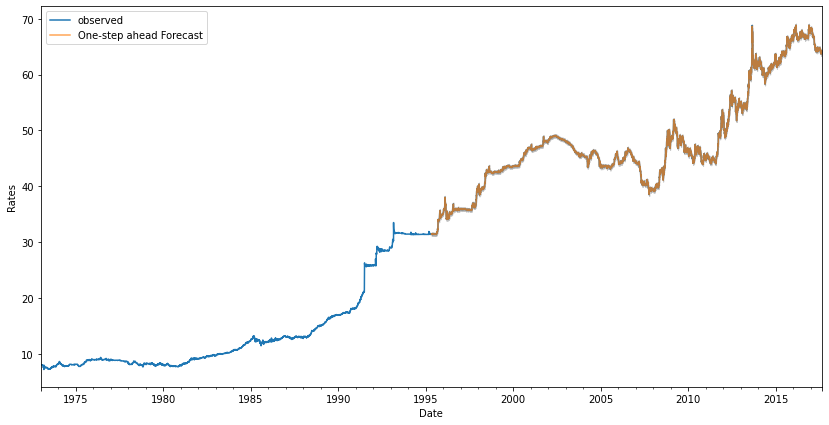

In [65]:
ax = resampled_series['1973':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Rates')
plt.legend()

plt.show()

### Visualisation for Rolling Forecast

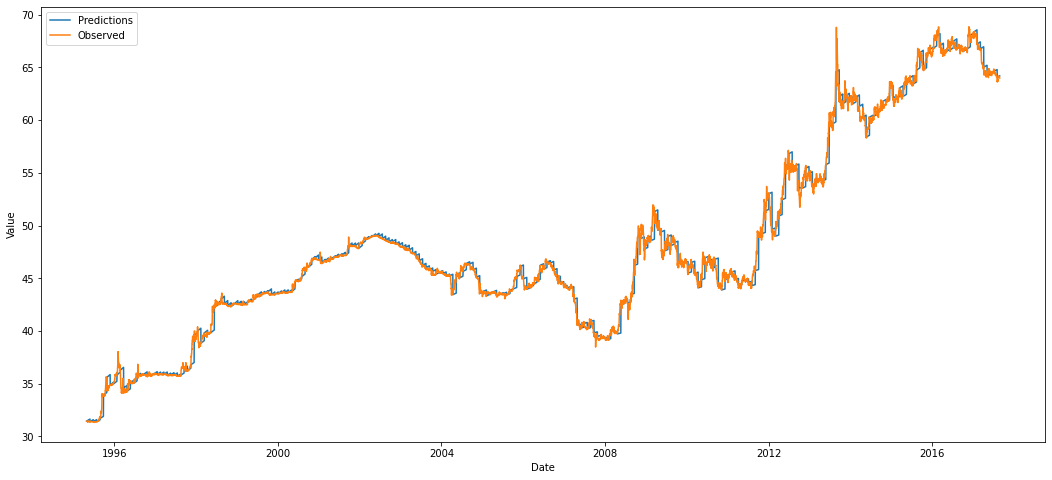

In [97]:
plt.plot(test_dates[:len(rolling_predictions)],rolling_predictions,label='Predictions') 
plt.plot(test_dates[:len(rolling_predictions)],true_rolling_history[len(train_data):],label='Observed')
#plt.plot(all_dates,true_rolling_history)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

### MAE, MSE, RMSE and Forecast Error

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [76]:
mae = mean_absolute_error(history, predictions)
print("MAE: ",mae)

MAE:  0.09139938173637605


In [77]:
mse = mean_squared_error(history, predictions)
rmse = mse**(0.5)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % rmse)

MSE: 0.034
RMSE: 0.184


Forecast error = (Observed - Predicted) / Observed

In [80]:
forecast_error = [(history[i]-predictions[i])/history[i] for i in range(len(predictions))]

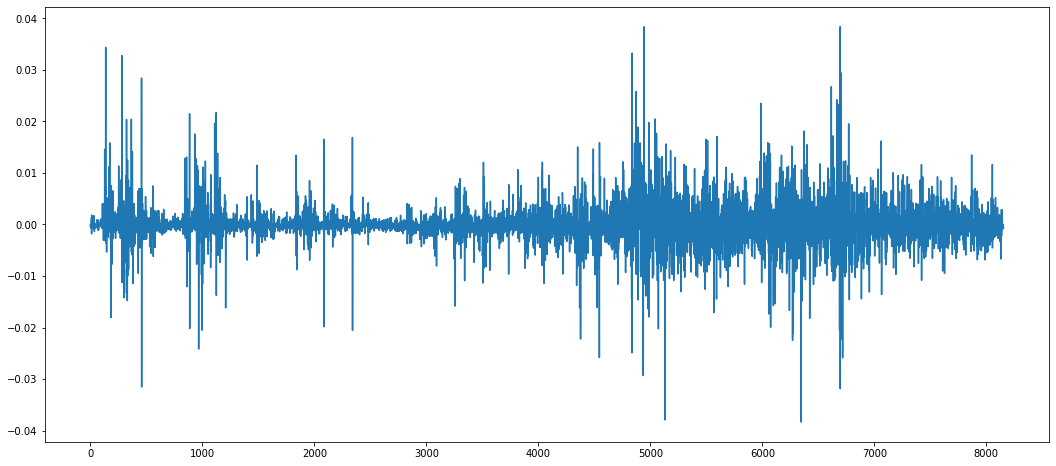

In [81]:
plt.plot(forecast_error)

### Monthly Rolling Forecast MAE, MSE, RMSE, Forecast Error

In [78]:
mae_rolling = mean_absolute_error(true_rolling_history[len(train_data):], rolling_predictions)
print("MAE: ",mae_rolling)

MAE:  0.4546229487242681


In [79]:
mse_rolling = mean_squared_error(true_rolling_history[len(train_data):], rolling_predictions)
rmse_rolling = mse**(0.5)
print('MSE: %.3f' % mse_rolling)
print('RMSE: %.3f' % rmse)

MSE: 0.517
RMSE: 0.184


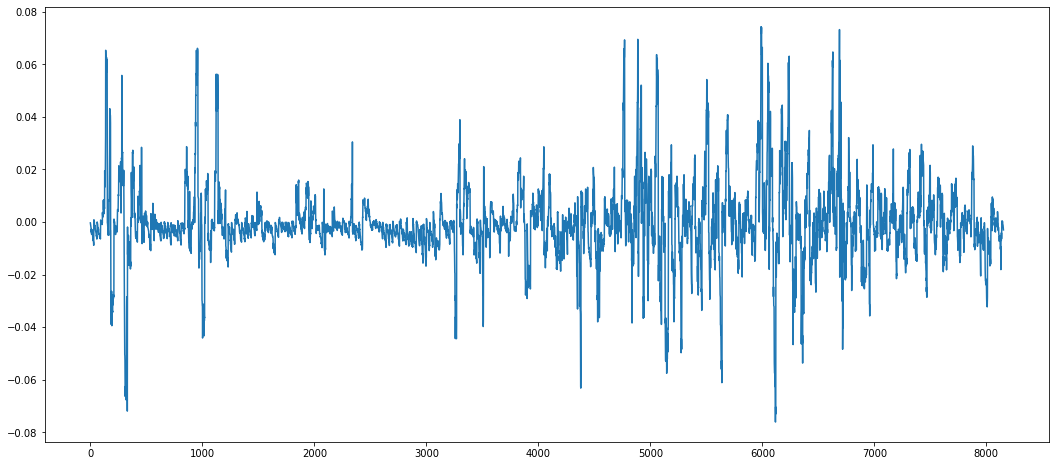

In [82]:
forecast_error_rolling = [(true_rolling_history[len(train_data)+i]-rolling_predictions[i])/true_rolling_history[len(train_data)+i] for i in range(len(rolling_predictions))]
plt.plot(forecast_error_rolling)

### Residuals of the Test Data

In [83]:
mod = sm.tsa.statespace.SARIMAX(resampled_series,
                                            order=(1,0,1),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
results = mod.fit()

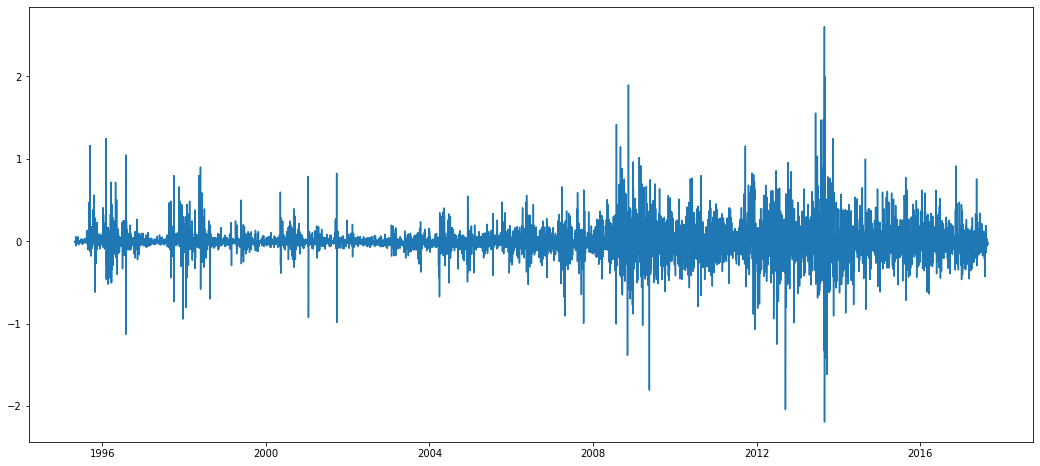

In [84]:
plt.plot(results.resid[train_size:])

### Comparing Models for SARIMAX

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 \nAIC = {} \nBIC = {} \nSSE = {}'.format(param,param_seasonal,results.aic,results.bic,results.sse))
            
            #R square calculation
            data_mean = sum(train_data)/len(train_data)
            TSS_list = train_data-data_mean
            TSS_list = [i**2 for i in TSS_list]
            TSS = sum(TSS_list)
            R_squared = 1 - results.sse/TSS
            print("R squared = ",R_squared)
            
            #Adjusted R square calculation
            N = len(train_data)
            p = sum(param) + sum(param_seasonal)
            R_squared_adj = 1 - ((1 - R_squared)*(N-1))/(N - (p + 1))
            print("Adjusted R squared = ",R_squared_adj)
            
            #Standard Error of Regression Calculation
            std_dev = pow(TSS/N,0.5)
            SER = pow(1 - R_squared_adj,0.5) * std_dev
            print("SER = ",SER)
            print("------------------------------")
        except:
            continue
